# initializing notebook

In [47]:
!pip install pandas
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [49]:
sns.set_theme(style="whitegrid")

In [112]:
step_length = 1.0                # meters per grid‐move/step
base_speed = 1.5                 # m/s
time_per_step = step_length / base_speed    # seconds per simulation step

In [51]:
step_length / base_speed

0.6666666666666666

In [88]:
time_per_step

0.6666666666666666

In [53]:
print("Expected max time_s:", 90 * (1.0 / 1.5))  # Should print 60.0

Expected max time_s: 60.0


In [54]:
# to save it later
download_dir = Path.home() / "Downloads" / "evacuation_plots"
download_dir.mkdir(parents=True, exist_ok=True)

In [191]:
def load_report_data(folder_name, step_length=step_length, time_per_step=time_per_step):
    path = Path("reports/all_risk_areas") / folder_name
    files = list(path.glob("*.csv"))
    dfs = []

    for file in files:
        try:
            df = pd.read_csv(file)
            if df.empty or 'evacuated' not in df.columns:
                print(f"⚠️ Skipping empty or invalid file: {file.name}")
                continue

            df['evacuated'] = df['evacuated'].astype(bool)
            df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
            df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
            df['steps'] = pd.to_numeric(df['steps'], errors='coerce')

            df['distance_m'] = df['distance'] * step_length
            df['time_s'] = df['time_spent'] * time_per_step
            df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)

            dfs.append(df)
        except Exception as e:
            print(f"{file.name}: {e}")
            continue

    if dfs:
        return pd.concat(dfs, ignore_index=True)
    else:
        return pd.DataFrame()


In [171]:
report_folders = ["minuto_1", "minuto_3", "minuto_5", "final_simulacao"]

In [193]:
report_dfs = {folder: load_report_data(folder) for folder in report_folders}

In [115]:
def count_csv_files(folder_name):
    path = Path("reports/no_landslide") / folder_name
    files = list(path.glob("*.csv"))
    print(f"{len(files)} CSV files found in '{folder_name}' folder.")

# Example usage
count_csv_files("all_done")

0 CSV files found in 'all_done' folder.


# Analysis

## No landslide cenario

In [116]:
df_all_done = load_report_data("final_simulacao", step_length, time_per_step)

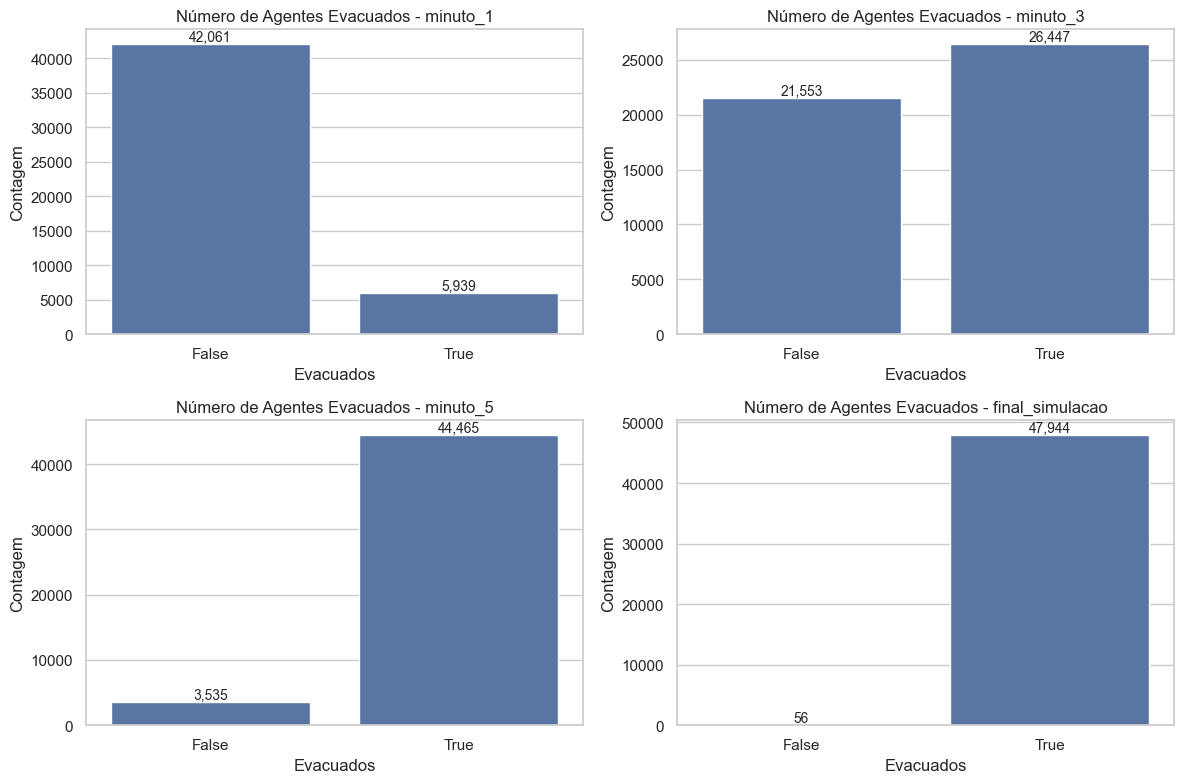

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    sns.countplot(data=df, x='evacuated', order=[False, True], ax=ax)

    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f"{count:,}", 
                    (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='bottom', fontsize=10)

    ax.set(title=f"Número de Agentes Evacuados - {folder}", xlabel="Evacuados", ylabel="Contagem")

fig.tight_layout()
fig.savefig(download_dir / "grid_evacuated_count_LINEAR.png")
plt.show()
plt.close(fig)


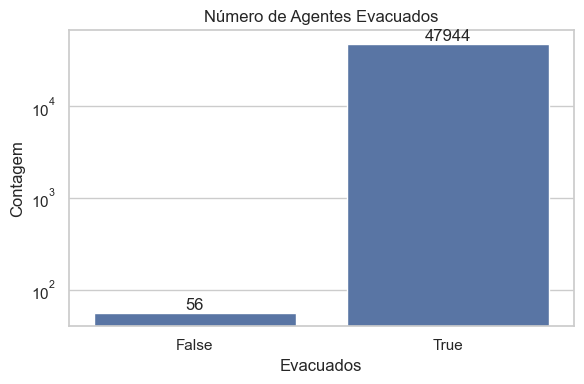

In [135]:
# 1. Histogram: evacuation status
fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot with both True and False
sns.countplot(data=df_all_done, x='evacuated', order=[False, True], ax=ax)

# Show bar values above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(str(count), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

# Apply log scale to y-axis to make tiny bars visible
ax.set_yscale("log")

# Titles (same as before)
ax.set(title="Número de Agentes Evacuados", xlabel="Evacuados", ylabel="Contagem")

# Save and show
fig.tight_layout()
fig.savefig(download_dir / "evacuated_count_logscale.png")
plt.show()
plt.close(fig)

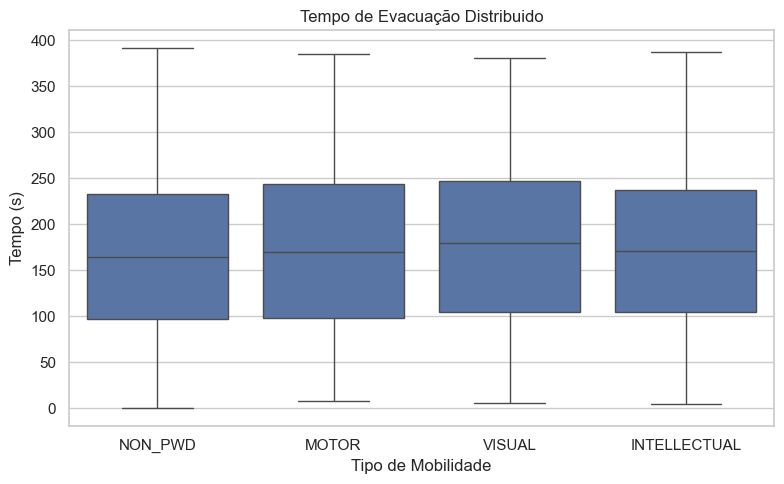

In [112]:
# 2) Evacuation Time Distribution (boxplot) ** final
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(data=df_all_done, x='mobility_type', y='time_s', ax=ax)
ax.set(title="Tempo de Evacuação Distribuido", xlabel="Tipo de Mobilidade", ylabel="Tempo (s)")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "boxplot_time.png")
plt.close(fig)

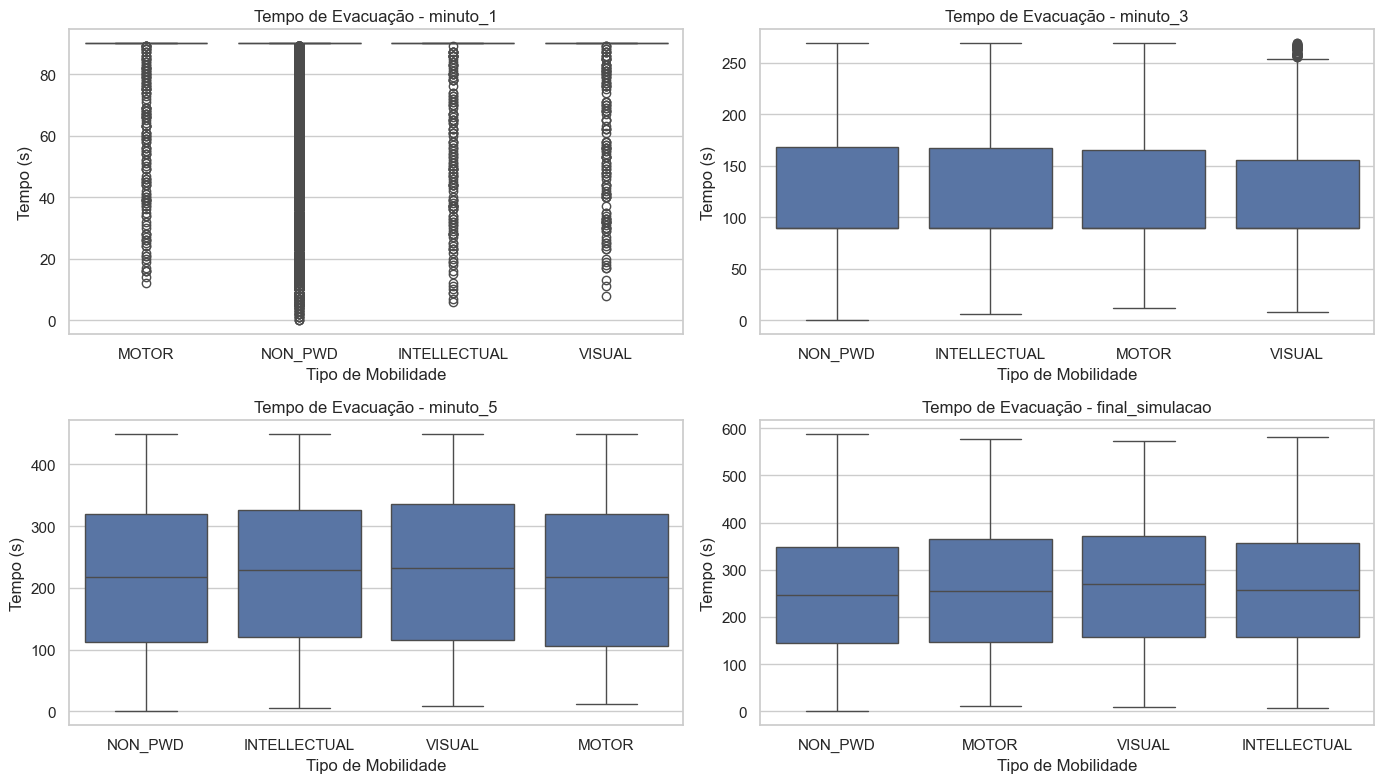

In [173]:
# boxplot ao longo da simulação
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'mobility_type' in df.columns and 'time_s' in df.columns and not df.empty:
        sns.boxplot(data=df, x='mobility_type', y='time_s', ax=ax)
        ax.set(title=f"Tempo de Evacuação - {folder}", xlabel="Tipo de Mobilidade", ylabel="Tempo (s)")
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set(title=f"Tempo de Evacuação - {folder}")

fig.tight_layout()
fig.savefig(download_dir / "grid_boxplot_time.png")
plt.show()
plt.close(fig)

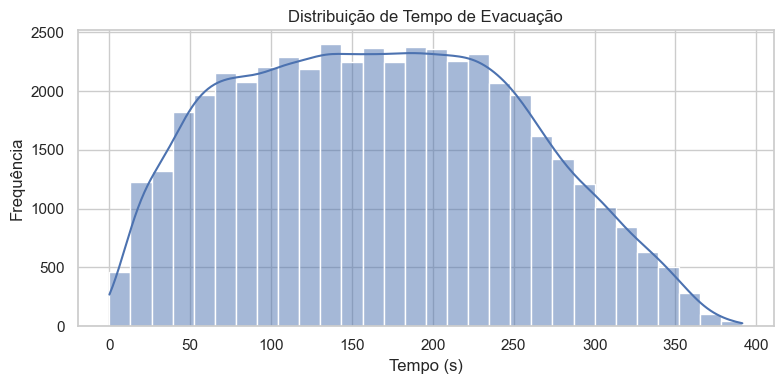

In [113]:
# 3) Distribution of Evacuation Time (histogram) * - final - normal
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=df_all_done, x='time_s', bins=30, kde=True, ax=ax)
ax.set(title="Distribuição de Tempo de Evacuação", xlabel="Tempo (s)", ylabel="Frequência")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "hist_time.png")
plt.close(fig)

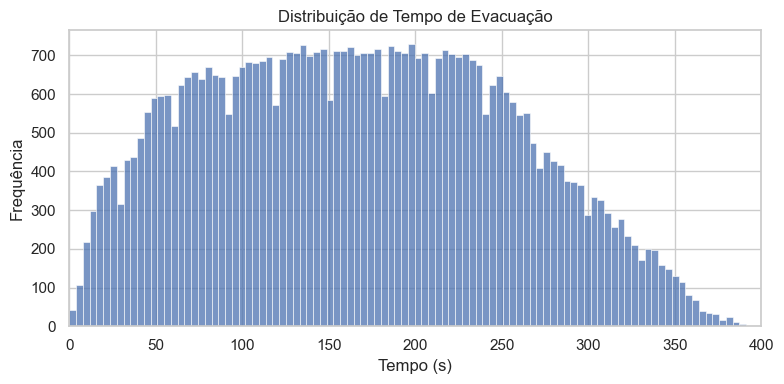

In [64]:
# 3) Distribution of Evacuation Time (histogram) * - final - com mais bins
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(df[df["evacuated"] == True], x="time_s", bins=100)
plt.xlim(0, 400)
ax.set(title="Distribuição de Tempo de Evacuação", xlabel="Tempo (s)", ylabel="Frequência")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "hist_time.png")
plt.close(fig)

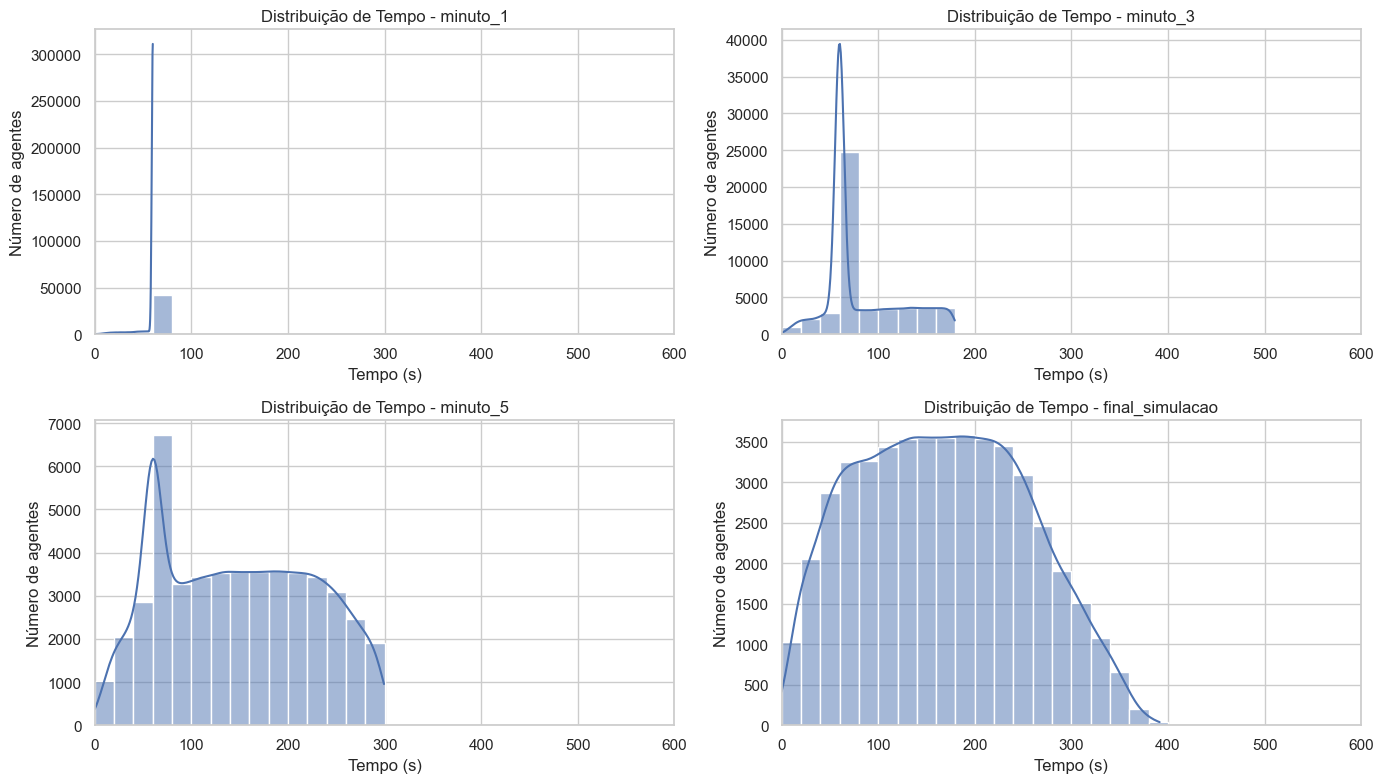

In [119]:
# distribuicao ao longo do tempo
# X-axis (time_s) = how long agents took to evacuate
# Y-axis (frequência) = how many agents had that evacuation time (binned)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'time_s' in df.columns and not df['time_s'].dropna().empty:
        sns.histplot(data=df, x='time_s', bins=30, binrange=(0,600), kde=True, ax=ax)
        ax.set_xlim(0, 600)
        ax.set(title=f"Distribuição de Tempo - {folder}", xlabel="Tempo (s)", ylabel="Número de agentes")
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set(title=f"Distribuição de Tempo - {folder}")

fig.tight_layout()
fig.savefig(download_dir / "grid_hist_time.png")
plt.show()
plt.close(fig)


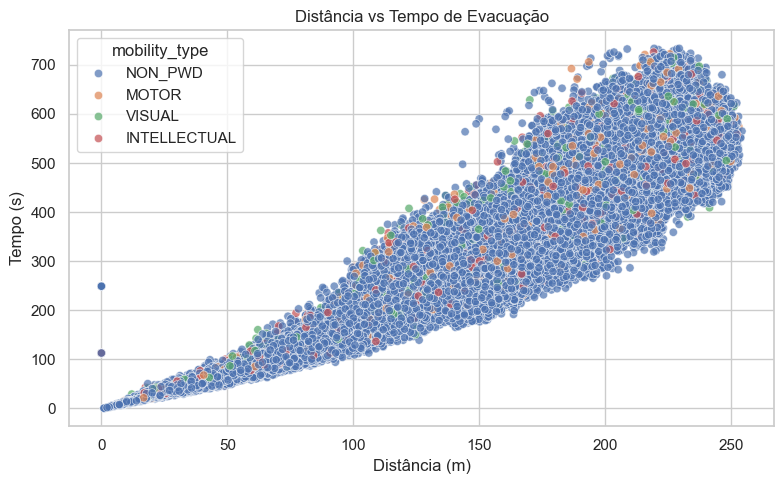

In [172]:
# Distance vs. Time (scatter)
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=df_all_done, x='distance_m', y='time_s', hue='mobility_type', alpha=0.7, ax=ax)
ax.set(title="Distância vs Tempo de Evacuação", xlabel="Distância (m)", ylabel="Tempo (s)")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "scatter_dist_vs_time.png")
plt.close(fig)

In [340]:
# descobrir tempo total da simulação
from pathlib import Path
import pandas as pd

# CONFIGURAÇÕES - AJUSTE PARA SEU CENÁRIO
report_folders = ["minuto_1", "minuto_3", "minuto_5", "final_simulacao"]
base_path = Path("reports/no_landslide")  # <<<< MUDE AQUI

# Configurações da simulação (mantenha iguais)
step_length = 1.0
base_speed = 1.5
time_per_step = step_length / base_speed

print("=== DESCOBRINDO TEMPO TOTAL DA SIMULAÇÃO ===")
print(f"Analisando pasta: {base_path}")
print()

# Função para descobrir o tempo máximo em cada momento
def discover_max_time(folder_path):
    """Descobre o tempo máximo real da simulação analisando os dados"""
    try:
        # Pegar o arquivo mais recente
        all_csvs = list(folder_path.glob("*.csv"))
        if not all_csvs:
            return None, "Nenhum arquivo CSV encontrado"
        
        latest_file = min(all_csvs, key=lambda x: x.stat().st_mtime)
        df = pd.read_csv(latest_file)
        
        # Converter dados
        df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
        
        # Para descobrir o tempo total, precisamos analisar os agentes evacuados
        # pois eles têm o tempo completo até a evacuação
        evacuated_agents = df[df['evacuated'] == True]
        
        if len(evacuated_agents) > 0:
            max_time_ticks = evacuated_agents['time_spent'].max()
            max_time_seconds = max_time_ticks * time_per_step
            
            return max_time_seconds, f"Baseado em {len(evacuated_agents)} agentes evacuados"
        else:
            # Se ninguém foi evacuado, usar o máximo geral
            max_time_ticks = df['time_spent'].max()
            max_time_seconds = max_time_ticks * time_per_step
            
            return max_time_seconds, "Baseado no máximo geral (nenhum agente evacuado)"
            
    except Exception as e:
        return None, f"Erro: {e}"

# Descobrir os tempos para cada momento
discovered_times = {}
for folder in report_folders:
    folder_path = base_path / folder
    max_time, info = discover_max_time(folder_path)
    
    if max_time is not None:
        discovered_times[folder] = max_time
        print(f"{folder}:")
        print(f"  Tempo máximo descoberto: {max_time:.1f} segundos")
        print(f"  Info: {info}")
        print()
    else:
        print(f"{folder}: ERRO - {info}")
        print()

# Gerar o código que você deve usar no script principal
print("="*50)
print("CÓDIGO PARA USAR NO SEU SCRIPT PRINCIPAL:")
print("="*50)
print()
print("# Tempos descobertos automaticamente:")
print("simulation_elapsed_time = {")
for folder, time_val in discovered_times.items():
    print(f'    "{folder}": {time_val:.1f},')
print("}")
print()

# Validação - os tempos fazem sentido?
print("="*30)
print("VALIDAÇÃO:")
print("="*30)
expected_times = {
    "minuto_1": 60,
    "minuto_3": 180, 
    "minuto_5": 300
}

for folder, expected in expected_times.items():
    if folder in discovered_times:
        discovered = discovered_times[folder]
        if abs(discovered - expected) > 30:  # Margem de 30 segundos
            print(f"⚠️  {folder}: Esperado ~{expected}s, descoberto {discovered:.1f}s")
        else:
            print(f"✅ {folder}: OK ({discovered:.1f}s ≈ {expected}s)")
    else:
        print(f"❌ {folder}: Não foi possível descobrir o tempo")

if "final_simulacao" in discovered_times:
    final_time = discovered_times["final_simulacao"]
    print(f"✅ final_simulacao: {final_time:.1f}s (tempo total da simulação)")

=== DESCOBRINDO TEMPO TOTAL DA SIMULAÇÃO ===
Analisando pasta: reports/no_landslide

minuto_1:
  Tempo máximo descoberto: 59.3 segundos
  Info: Baseado em 59 agentes evacuados

minuto_3:
  Tempo máximo descoberto: 179.3 segundos
  Info: Baseado em 269 agentes evacuados

minuto_5:
  Tempo máximo descoberto: 299.3 segundos
  Info: Baseado em 446 agentes evacuados

final_simulacao:
  Tempo máximo descoberto: 344.7 segundos
  Info: Baseado em 479 agentes evacuados

CÓDIGO PARA USAR NO SEU SCRIPT PRINCIPAL:

# Tempos descobertos automaticamente:
simulation_elapsed_time = {
    "minuto_1": 59.3,
    "minuto_3": 179.3,
    "minuto_5": 299.3,
    "final_simulacao": 344.7,
}

VALIDAÇÃO:
✅ minuto_1: OK (59.3s ≈ 60s)
✅ minuto_3: OK (179.3s ≈ 180s)
✅ minuto_5: OK (299.3s ≈ 300s)
✅ final_simulacao: 344.7s (tempo total da simulação)


minuto_1: minute_1_report_20250531-211007.csv
minuto_3: minute_3_report_20250531-211532.csv
minuto_5: minute_5_report_20250531-211615.csv
final_simulacao: all_done_report_20250531-211616.csv

=== minuto_1 ===
Total de agentes: 480
Não evacuados: 421
time_spent (ticks) - min: 10.0, max: 90.0
time_s (segundos) - min: 6.7, max: 60.0
Tempo decorrido na simulação: 60 segundos
Eficiência média de movimento: 95.2%
⚠️  11 agentes com baixa eficiência de movimento (<30%)

=== minuto_3 ===
Total de agentes: 480
Não evacuados: 211
time_spent (ticks) - min: 10.0, max: 269.0
time_s (segundos) - min: 6.7, max: 179.3
Tempo decorrido na simulação: 180 segundos
Eficiência média de movimento: 46.6%
⚠️  49 agentes com baixa eficiência de movimento (<30%)

=== minuto_5 ===
Total de agentes: 480
Não evacuados: 34
time_spent (ticks) - min: 10.0, max: 449.0
time_s (segundos) - min: 6.7, max: 299.3
Tempo decorrido na simulação: 300 segundos
Eficiência média de movimento: 49.5%
⚠️  142 agentes com baixa eficiê

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/946118442.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


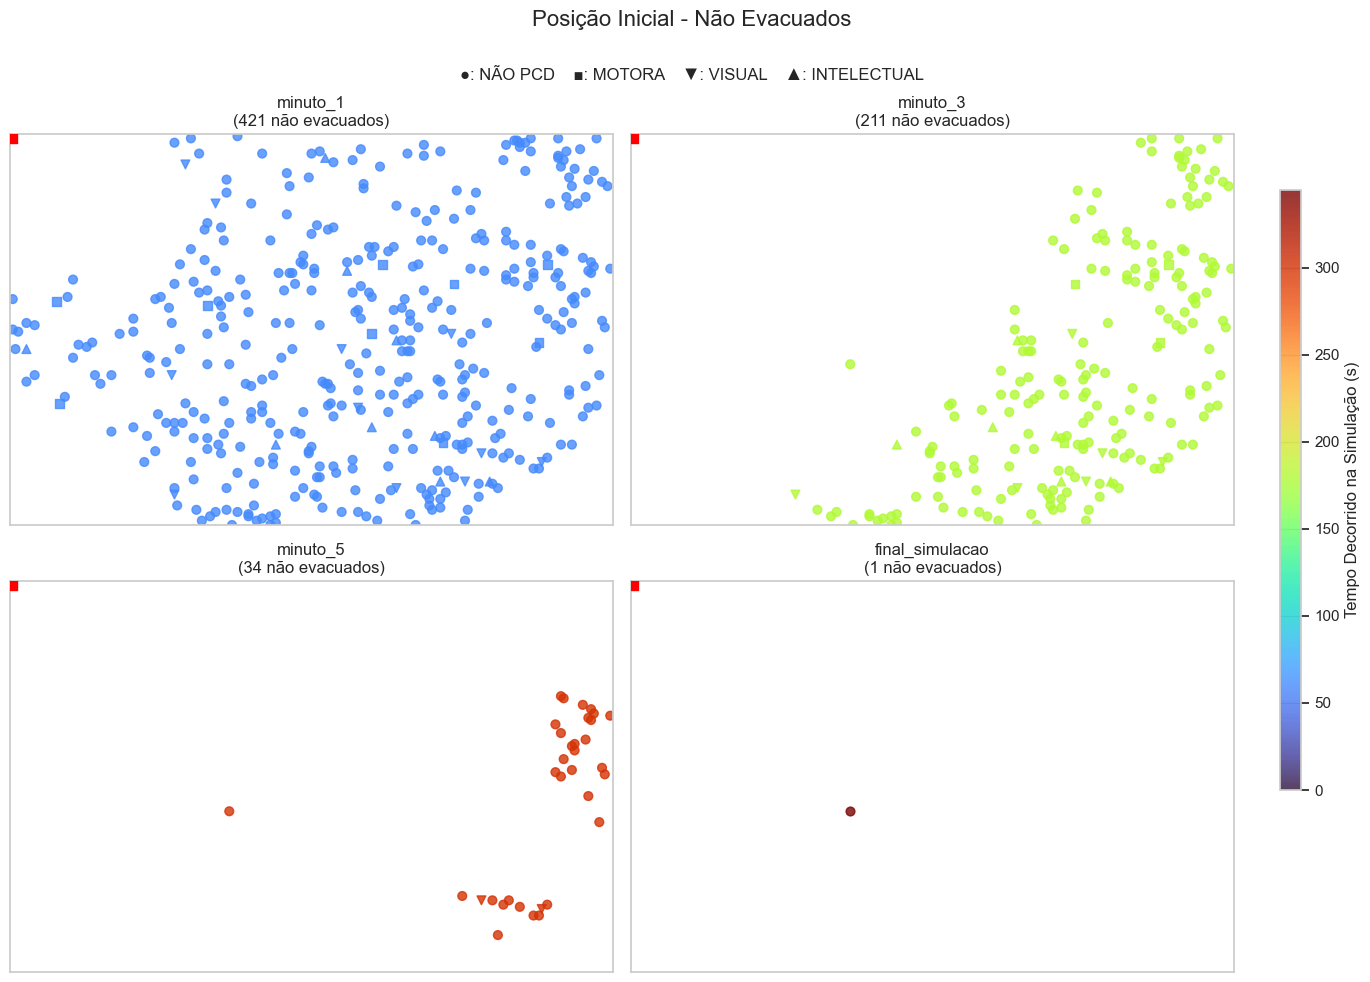


ANÁLISE DETALHADA

minuto_1:
  Agentes não evacuados: 421
  Time_spent (ticks): count    421.0
mean      90.0
std        0.0
min       90.0
25%       90.0
50%       90.0
75%       90.0
max       90.0
Name: time_spent, dtype: float64
  Time_s (segundos): count    421.0
mean      60.0
std        0.0
min       60.0
25%       60.0
50%       60.0
75%       60.0
max       60.0
Name: time_s, dtype: float64

minuto_3:
  Agentes não evacuados: 211
  Time_spent (ticks): count    211.000000
mean      90.516588
std        7.503869
min       90.000000
25%       90.000000
50%       90.000000
75%       90.000000
max      199.000000
Name: time_spent, dtype: float64
  Time_s (segundos): count    211.000000
mean      60.344392
std        5.002580
min       60.000000
25%       60.000000
50%       60.000000
75%       60.000000
max      132.666667
Name: time_s, dtype: float64

minuto_5:
  Agentes não evacuados: 34
  Time_spent (ticks): count     34.000000
mean      93.205882
std       18.693346
min       

In [363]:
# pos inicial - nao evacuasos
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0                # metros por movimento/step
base_speed = 1.5                 # m/s
time_per_step = step_length / base_speed    # segundos por step de simulação

report_folders = ["minuto_1", "minuto_3", "minuto_5", "final_simulacao"]
base_path = Path("reports/no_landslide")

# Tempo decorrido na simulação para cada momento (em segundos)
simulation_elapsed_time = {
    "minuto_1": 60,
    "minuto_3": 180,
    "minuto_5": 300,
    "final_simulacao": 344.7  # Baseado no max observado
}

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step  # ESTA é a conversão correta para segundos
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Total de agentes: {len(df)}")
    print(f"Não evacuados: {len(df[df['evacuated'] == False])}")
    print(f"time_spent (ticks) - min: {df['time_spent'].min():.1f}, max: {df['time_spent'].max():.1f}")
    print(f"time_s (segundos) - min: {df['time_s'].min():.1f}, max: {df['time_s'].max():.1f}")
    print(f"Tempo decorrido na simulação: {simulation_elapsed_time[folder]} segundos")
    
    # Calcular eficiência de movimento (% do tempo que passaram se movendo)
    if simulation_elapsed_time[folder] > 0:
        df['movement_efficiency'] = (df['time_s'] / simulation_elapsed_time[folder]) * 100
        avg_efficiency = df['movement_efficiency'].mean()
        print(f"Eficiência média de movimento: {avg_efficiency:.1f}%")
        
        # Agentes que passaram muito pouco tempo se movendo (podem estar stuck)
        low_efficiency = df[df['movement_efficiency'] < 30]  # Menos de 30% do tempo se movendo
        if len(low_efficiency) > 0:
            print(f"⚠️  {len(low_efficiency)} agentes com baixa eficiência de movimento (<30%)")

# --- Step 3: Plotar os dados corrigidos ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Posição Inicial - Não Evacuados", fontsize=16)
fig.text(0.5, 0.91, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

# Determinar o range global para a cor (baseado no tempo decorrido da simulação)
vmin, vmax = 0, max(simulation_elapsed_time.values())

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    df_not_evacuated = df[df["evacuated"] == False].copy()
    ax = axes[i // 2, i % 2]
    
    # Tempo decorrido na simulação para este momento
    elapsed_time = simulation_elapsed_time[folder]

    if df_not_evacuated.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=12)
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder)
        continue

    # Extrair coordenadas x, y da posição inicial
    df_not_evacuated[['x', 'y']] = df_not_evacuated['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Plotar por tipo de mobilidade
    for mob, marker in mobility_markers.items():
        sub = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub.empty:
            # CORREÇÃO: usar o tempo decorrido da simulação em vez de time_s individual
            # Todos os agentes não evacuados têm o mesmo "tempo na simulação"
            time_color = [elapsed_time] * len(sub)
            sc = ax.scatter(sub['x'], sub['y'], c=time_color, cmap='turbo',
                           s=40, alpha=0.8, marker=marker, vmin=vmin, vmax=vmax, label=mob)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='s', label='Zona Segura', zorder=10)
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{folder}\n({len(df_not_evacuated)} não evacuados)")

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Tempo Decorrido na Simulação (s)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- Análise adicional para entender os dados ---
print("\n" + "="*50)
print("ANÁLISE DETALHADA")
print("="*50)

for folder in report_folders:
    df = dataframes[folder]
    df_not_evac = df[df["evacuated"] == False]
    
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df_not_evac)}")
    if len(df_not_evac) > 0:
        print(f"  Time_spent (ticks): {df_not_evac['time_spent'].describe()}")
        print(f"  Time_s (segundos): {df_not_evac['time_s'].describe()}")
        
        # Verificar se há agentes com time_spent inconsistente
        if folder == "minuto_1":
            max_expected_ticks = 60 / time_per_step  # ~90 ticks para 1 minuto
            weird_agents = df_not_evac[df_not_evac['time_spent'] > max_expected_ticks]
            if len(weird_agents) > 0:
                print(f"  ⚠️  Agentes com time_spent > {max_expected_ticks:.0f} ticks:")
                print(f"     {weird_agents[['agent_id', 'time_spent', 'time_s']].to_string()}")

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/3747381219.py:89: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/3747381219.py:89: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/3747381219.py:89: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbr

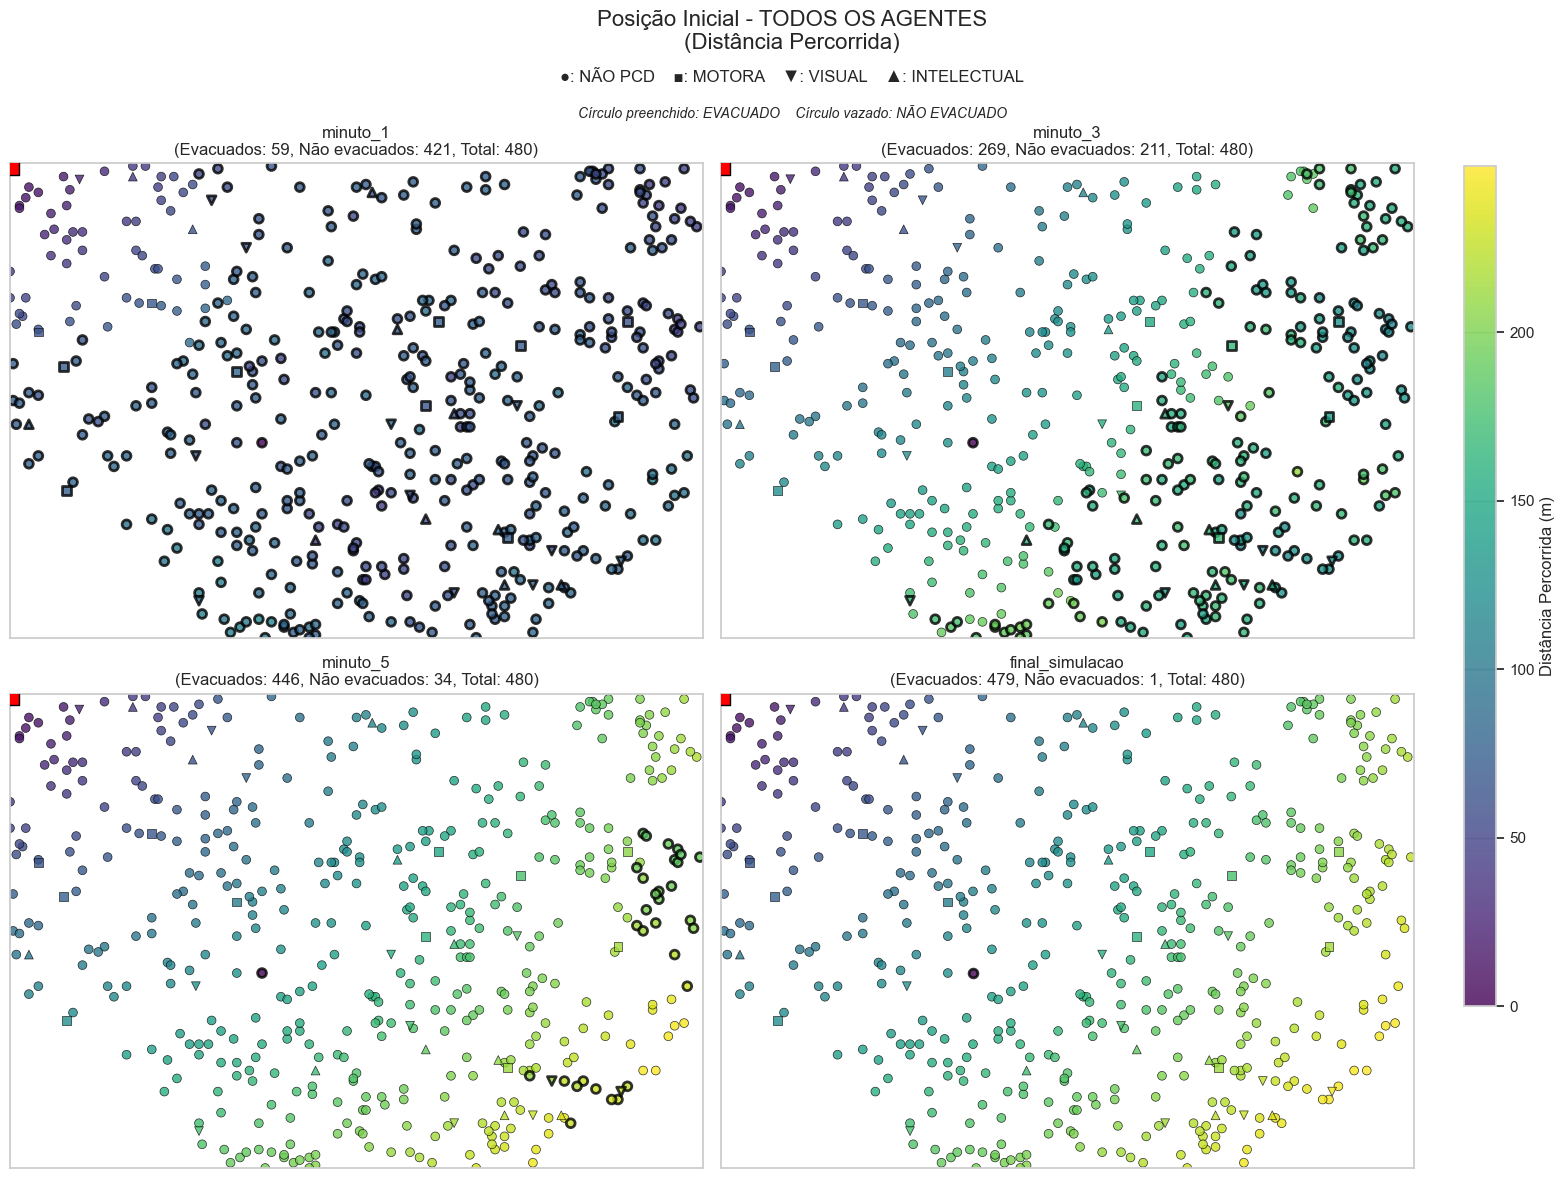

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/3747381219.py:165: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/3747381219.py:165: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/3747381219.py:165: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folde

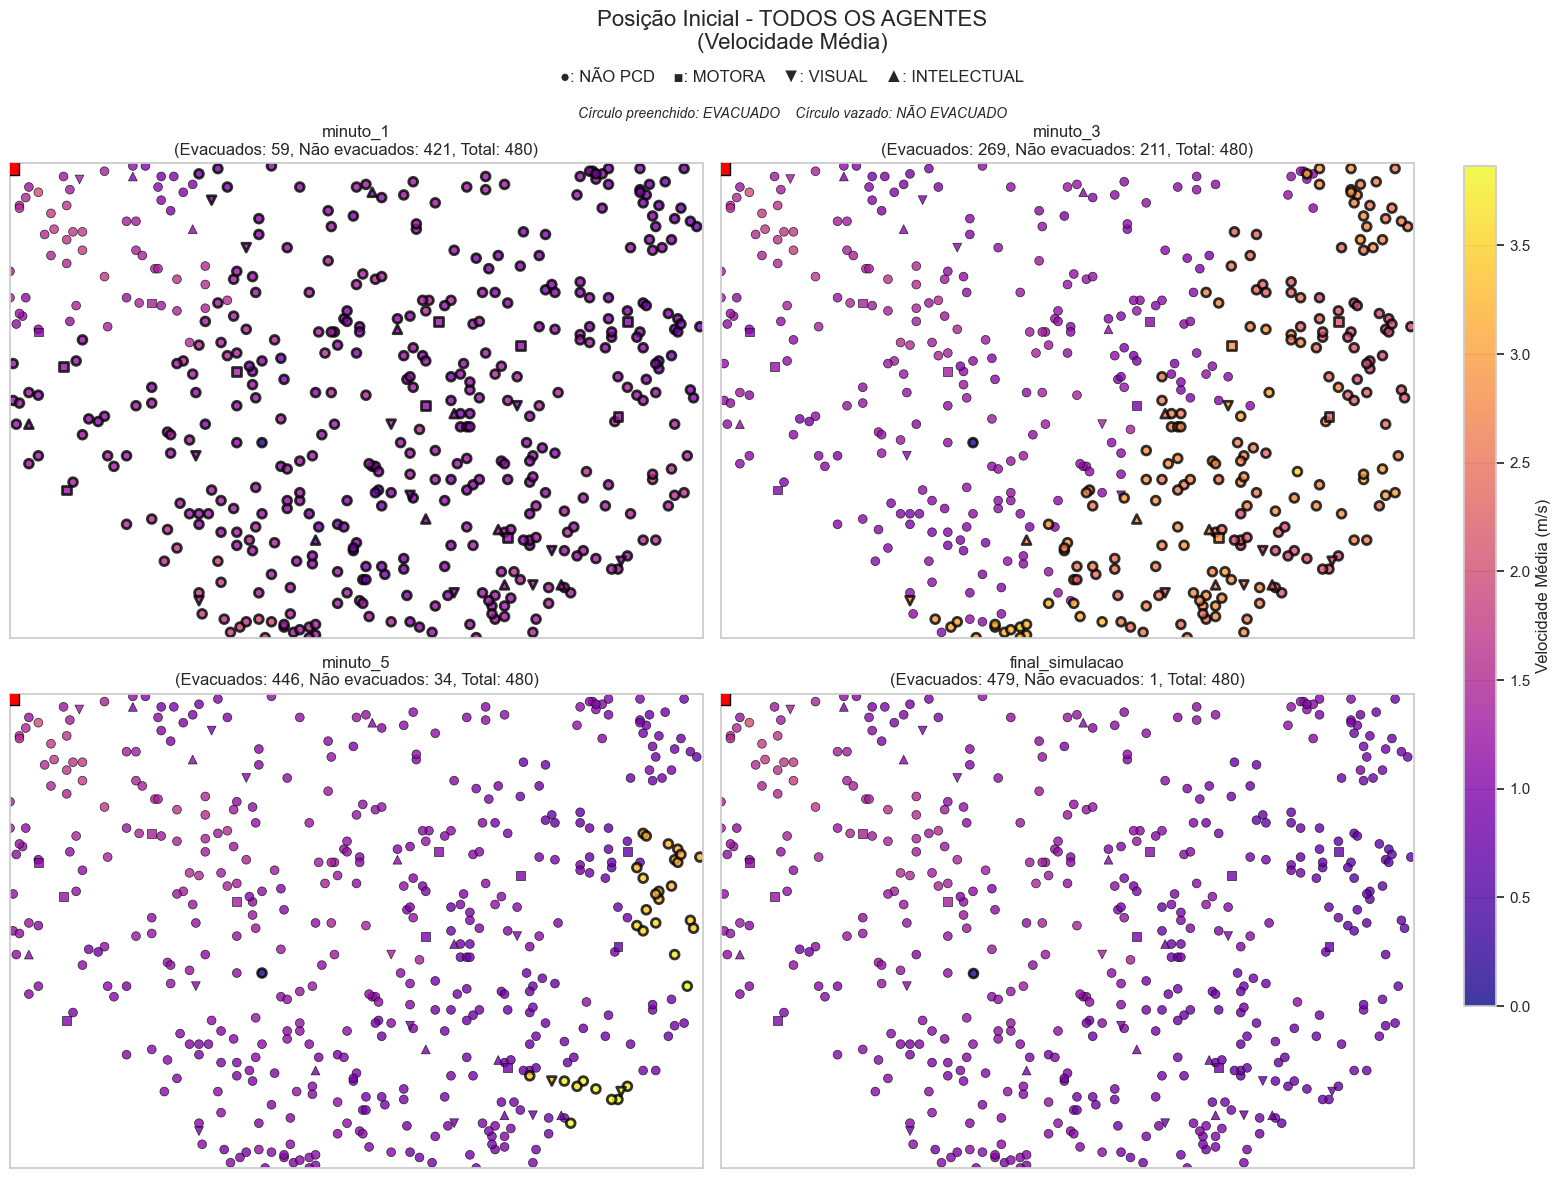


ESTATÍSTICAS COMPLETAS PARA O TCC

MINUTO_1:
  Total de agentes: 480
  Evacuados: 59 (12.3%)
  Não evacuados: 421 (87.7%)

  TODOS OS AGENTES:
    Distância percorrida:
      Média: 69.7m
      Min-Max: 0.0m - 115.3m
    Velocidade média:
      Média: 1.23 m/s
      Min-Max: 0.00 - 2.02 m/s

  AGENTES EVACUADOS:
    Distância média: 48.1m
    Velocidade média: 1.38 m/s
    Tempo médio: 36.6s

  AGENTES NÃO EVACUADOS:
    Distância média: 72.7m
    Velocidade média: 1.21 m/s
    Tempo: 60.0s

  POR TIPO DE MOBILIDADE:
    NON_PWD     : 446 agentes total, evacuação:  12.1%
                 dist:  69.9m, vel: 1.24m/s
    MOTOR       :  11 agentes total, evacuação:  18.2%
                 dist:  70.5m, vel: 1.20m/s
    VISUAL      :  12 agentes total, evacuação:   8.3%
                 dist:  66.9m, vel: 1.20m/s
    INTELLECTUAL:  11 agentes total, evacuação:  18.2%
                 dist:  64.3m, vel: 1.11m/s

MINUTO_3:
  Total de agentes: 480
  Evacuados: 269 (56.0%)
  Não evacuados: 211

In [362]:
# pos inicial todos os agentes - velocidade e distancia
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0
base_speed = 1.5
time_per_step = step_length / base_speed

report_folders = ["minuto_1", "minuto_3", "minuto_5", "final_simulacao"]
base_path = Path("reports/no_landslide")

# --- Carregar dados ---
latest_files = {}
for folder in report_folders:
    folder_path = base_path / folder
    all_csvs = list(folder_path.glob("*.csv"))
    latest_file = min(all_csvs, key=os.path.getmtime)
    latest_files[folder] = latest_file

dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    dataframes[folder] = df

# --- VISUALIZAÇÃO 1: TODOS OS AGENTES POR DISTÂNCIA PERCORRIDA ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Posição Inicial - TODOS OS AGENTES\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
         ha='center', fontsize=12)
fig.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
         ha='center', fontsize=10, style='italic')

# Encontrar range global de distâncias para todos os agentes
all_distances = []
for folder in report_folders:
    df = dataframes[folder]
    all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin, vmax = min(all_distances), max(all_distances)
else:
    vmin, vmax = 0, 100

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    ax = axes[i // 2, i % 2]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, facecolors='none', 
                           edgecolors='black', linewidth=2)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- VISUALIZAÇÃO 2: TODOS OS AGENTES POR VELOCIDADE MÉDIA ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle("Posição Inicial - TODOS OS AGENTES\n(Velocidade Média)", fontsize=16)
fig2.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
          ha='center', fontsize=12)
fig2.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
          ha='center', fontsize=10, style='italic')

# Range global de velocidades para todos os agentes
all_velocities = []
for folder in report_folders:
    df = dataframes[folder]
    all_velocities.extend(df['velocity_m_s'].tolist())

if all_velocities:
    vmin_vel, vmax_vel = min(all_velocities), max(all_velocities)
else:
    vmin_vel, vmax_vel = 0, 2

sc_for_colorbar2 = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    ax = axes2[i // 2, i % 2]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc2 = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, facecolors='none', 
                            edgecolors='black', linewidth=2)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Colorbar
if sc_for_colorbar2:
    cbar_ax2 = fig2.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar2 = fig2.colorbar(sc_for_colorbar2, cax=cbar_ax2, label="Velocidade Média (m/s)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- ESTATÍSTICAS COMPARATIVAS COMPLETAS ---
print("\n" + "="*80)
print("ESTATÍSTICAS COMPLETAS PARA O TCC")
print("="*80)

for folder in report_folders:
    df = dataframes[folder]
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    print(f"\n{folder.upper()}:")
    print(f"  Total de agentes: {len(df)}")
    print(f"  Evacuados: {len(df_evacuated)} ({len(df_evacuated)/len(df)*100:.1f}%)")
    print(f"  Não evacuados: {len(df_not_evacuated)} ({len(df_not_evacuated)/len(df)*100:.1f}%)")
    
    if len(df) > 0:
        print(f"\n  TODOS OS AGENTES:")
        print(f"    Distância percorrida:")
        print(f"      Média: {df['distance_m'].mean():.1f}m")
        print(f"      Min-Max: {df['distance_m'].min():.1f}m - {df['distance_m'].max():.1f}m")
        print(f"    Velocidade média:")
        print(f"      Média: {df['velocity_m_s'].mean():.2f} m/s")
        print(f"      Min-Max: {df['velocity_m_s'].min():.2f} - {df['velocity_m_s'].max():.2f} m/s")
        
        # Análise por status de evacuação
        if len(df_evacuated) > 0:
            print(f"\n  AGENTES EVACUADOS:")
            print(f"    Distância média: {df_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo médio: {df_evacuated['time_s'].mean():.1f}s")
        
        if len(df_not_evacuated) > 0:
            print(f"\n  AGENTES NÃO EVACUADOS:")
            print(f"    Distância média: {df_not_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_not_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo: {df_not_evacuated['time_s'].iloc[0]:.1f}s")
        
        # Análise por tipo de mobilidade
        print(f"\n  POR TIPO DE MOBILIDADE:")
        for mob_type in df['mobility_type'].unique():
            subset = df[df['mobility_type'] == mob_type]
            evacuated_subset = subset[subset['evacuated'] == True]
            not_evacuated_subset = subset[subset['evacuated'] == False]
            
            evacuation_rate = len(evacuated_subset) / len(subset) * 100 if len(subset) > 0 else 0
            avg_dist = subset['distance_m'].mean()
            avg_vel = subset['velocity_m_s'].mean()
            
            print(f"    {mob_type:12}: {len(subset):3} agentes total, "
                  f"evacuação: {evacuation_rate:5.1f}%")
            print(f"                 dist: {avg_dist:5.1f}m, vel: {avg_vel:.2f}m/s")

print("\n" + "="*80)
print("RESUMO COMPARATIVO ENTRE TEMPOS:")
print("="*80)

# Comparação de taxa de evacuação entre os tempos
evacuation_rates = {}
for folder in report_folders:
    df = dataframes[folder]
    rate = len(df[df['evacuated'] == True]) / len(df) * 100 if len(df) > 0 else 0
    evacuation_rates[folder] = rate

print("\nTaxas de Evacuação:")
for folder, rate in evacuation_rates.items():
    print(f"  {folder:15}: {rate:5.1f}%")

# Comparação de desempenho médio
print("\nDesempenho Médio (Todos os Agentes):")
for folder in report_folders:
    df = dataframes[folder]
    if len(df) > 0:
        avg_dist = df['distance_m'].mean()
        avg_vel = df['velocity_m_s'].mean()
        print(f"  {folder:15}: dist={avg_dist:5.1f}m, vel={avg_vel:.2f}m/s")

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_87125/3747381219.py:89: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_87125/3747381219.py:89: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_87125/3747381219.py:89: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbr

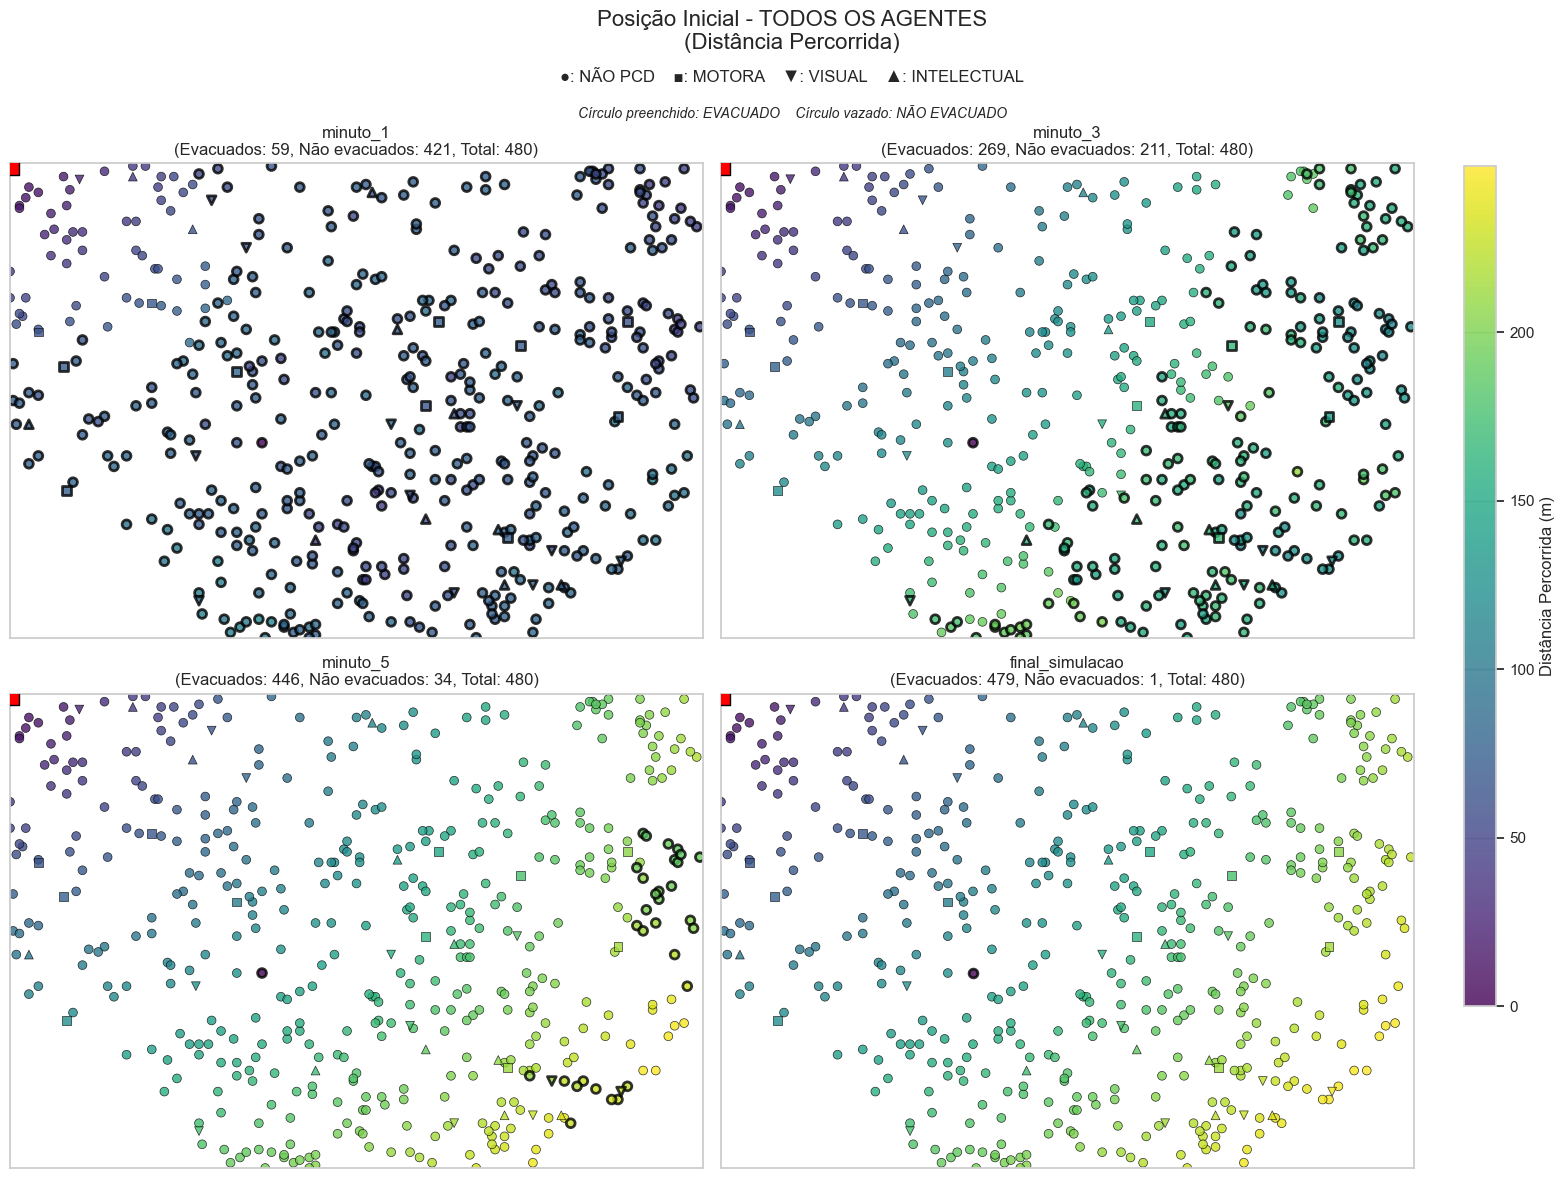

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_87125/3747381219.py:165: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_87125/3747381219.py:165: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_87125/3747381219.py:165: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folde

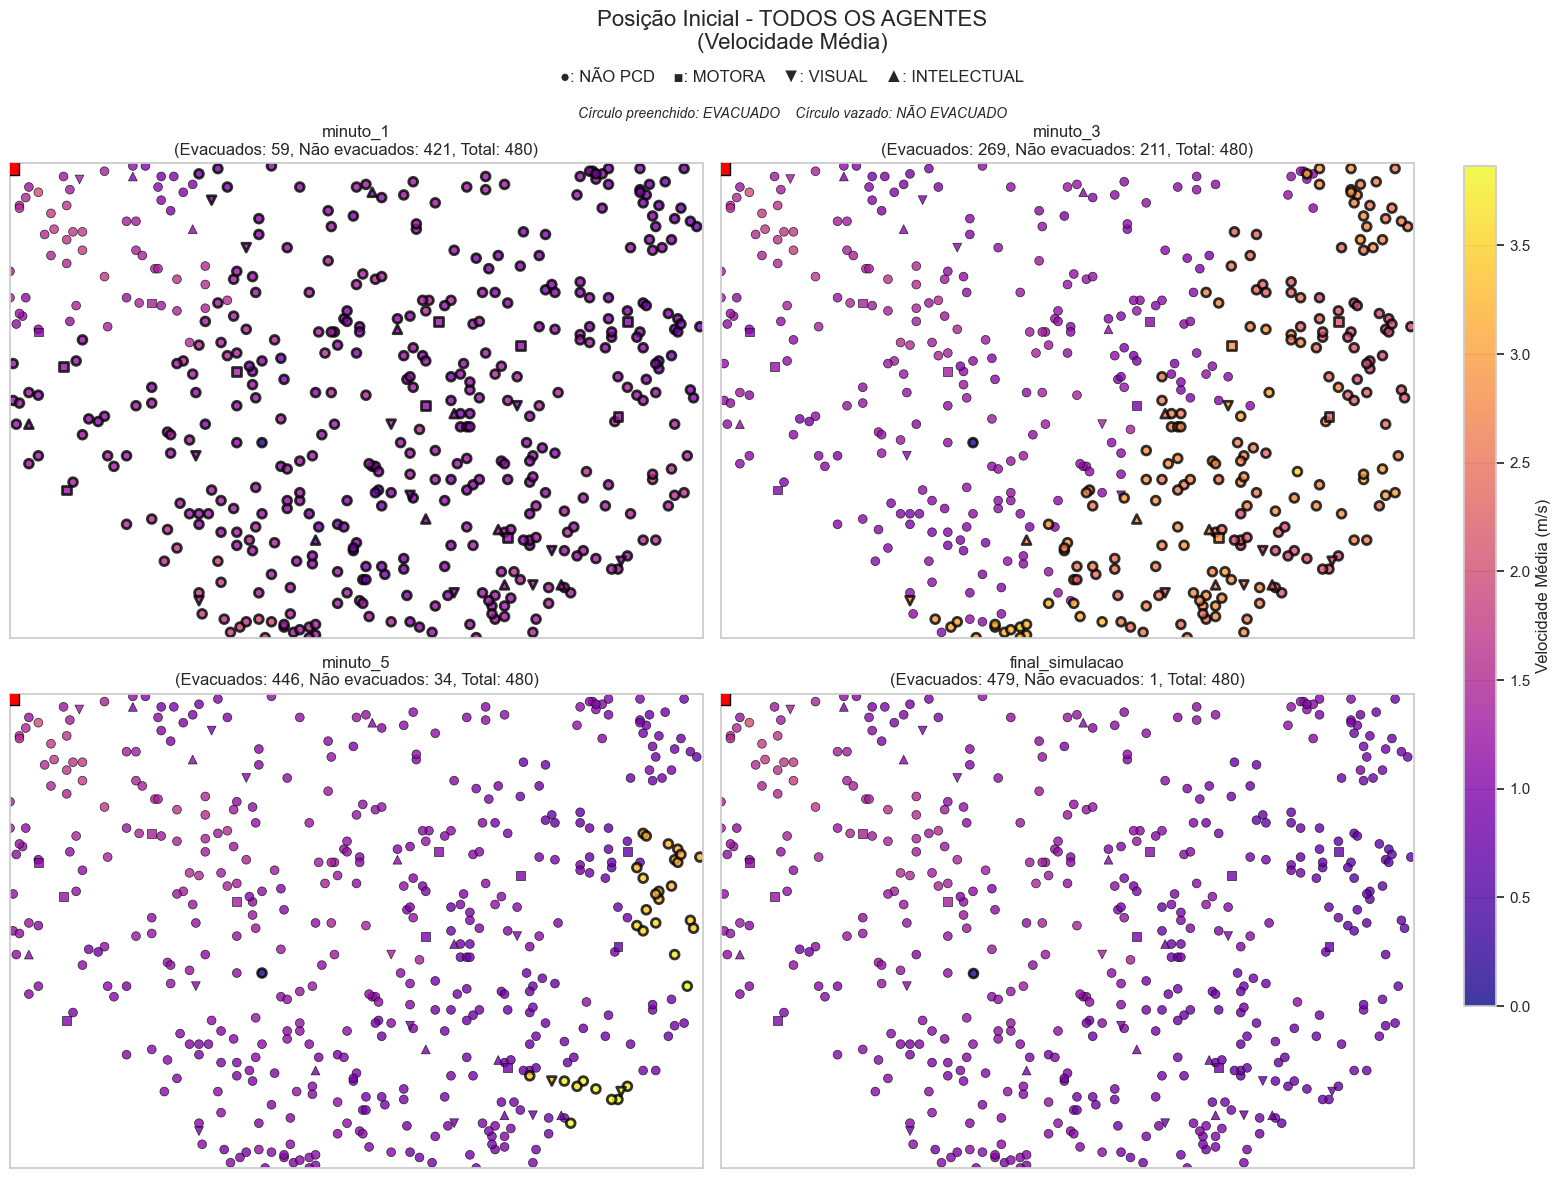


ESTATÍSTICAS COMPLETAS PARA O TCC

MINUTO_1:
  Total de agentes: 480
  Evacuados: 59 (12.3%)
  Não evacuados: 421 (87.7%)

  TODOS OS AGENTES:
    Distância percorrida:
      Média: 69.7m
      Min-Max: 0.0m - 115.3m
    Velocidade média:
      Média: 1.23 m/s
      Min-Max: 0.00 - 2.02 m/s

  AGENTES EVACUADOS:
    Distância média: 48.1m
    Velocidade média: 1.38 m/s
    Tempo médio: 36.6s

  AGENTES NÃO EVACUADOS:
    Distância média: 72.7m
    Velocidade média: 1.21 m/s
    Tempo: 60.0s

  POR TIPO DE MOBILIDADE:
    NON_PWD     : 446 agentes total, evacuação:  12.1%
                 dist:  69.9m, vel: 1.24m/s
    MOTOR       :  11 agentes total, evacuação:  18.2%
                 dist:  70.5m, vel: 1.20m/s
    VISUAL      :  12 agentes total, evacuação:   8.3%
                 dist:  66.9m, vel: 1.20m/s
    INTELLECTUAL:  11 agentes total, evacuação:  18.2%
                 dist:  64.3m, vel: 1.11m/s

MINUTO_3:
  Total de agentes: 480
  Evacuados: 269 (56.0%)
  Não evacuados: 211

In [33]:
# pos inicial
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0
base_speed = 1.5
time_per_step = step_length / base_speed

report_folders = ["minuto_1", "minuto_3", "minuto_5", "final_simulacao"]
base_path = Path("reports/no_landslide")

# --- Carregar dados ---
latest_files = {}
for folder in report_folders:
    folder_path = base_path / folder
    all_csvs = list(folder_path.glob("*.csv"))
    latest_file = min(all_csvs, key=os.path.getmtime)
    latest_files[folder] = latest_file

dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    dataframes[folder] = df

# --- VISUALIZAÇÃO 1: TODOS OS AGENTES POR DISTÂNCIA PERCORRIDA ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Posição Inicial - TODOS OS AGENTES\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
         ha='center', fontsize=12)
fig.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
         ha='center', fontsize=10, style='italic')

# Encontrar range global de distâncias para todos os agentes
all_distances = []
for folder in report_folders:
    df = dataframes[folder]
    all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin, vmax = min(all_distances), max(all_distances)
else:
    vmin, vmax = 0, 100

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    ax = axes[i // 2, i % 2]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, facecolors='none', 
                           edgecolors='black', linewidth=2)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- VISUALIZAÇÃO 2: TODOS OS AGENTES POR VELOCIDADE MÉDIA ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle("Posição Inicial - TODOS OS AGENTES\n(Velocidade Média)", fontsize=16)
fig2.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
          ha='center', fontsize=12)
fig2.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
          ha='center', fontsize=10, style='italic')

# Range global de velocidades para todos os agentes
all_velocities = []
for folder in report_folders:
    df = dataframes[folder]
    all_velocities.extend(df['velocity_m_s'].tolist())

if all_velocities:
    vmin_vel, vmax_vel = min(all_velocities), max(all_velocities)
else:
    vmin_vel, vmax_vel = 0, 2

sc_for_colorbar2 = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    ax = axes2[i // 2, i % 2]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc2 = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, facecolors='none', 
                            edgecolors='black', linewidth=2)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Colorbar
if sc_for_colorbar2:
    cbar_ax2 = fig2.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar2 = fig2.colorbar(sc_for_colorbar2, cax=cbar_ax2, label="Velocidade Média (m/s)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- ESTATÍSTICAS COMPARATIVAS COMPLETAS ---
print("\n" + "="*80)
print("ESTATÍSTICAS COMPLETAS PARA O TCC")
print("="*80)

for folder in report_folders:
    df = dataframes[folder]
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    print(f"\n{folder.upper()}:")
    print(f"  Total de agentes: {len(df)}")
    print(f"  Evacuados: {len(df_evacuated)} ({len(df_evacuated)/len(df)*100:.1f}%)")
    print(f"  Não evacuados: {len(df_not_evacuated)} ({len(df_not_evacuated)/len(df)*100:.1f}%)")
    
    if len(df) > 0:
        print(f"\n  TODOS OS AGENTES:")
        print(f"    Distância percorrida:")
        print(f"      Média: {df['distance_m'].mean():.1f}m")
        print(f"      Min-Max: {df['distance_m'].min():.1f}m - {df['distance_m'].max():.1f}m")
        print(f"    Velocidade média:")
        print(f"      Média: {df['velocity_m_s'].mean():.2f} m/s")
        print(f"      Min-Max: {df['velocity_m_s'].min():.2f} - {df['velocity_m_s'].max():.2f} m/s")
        
        # Análise por status de evacuação
        if len(df_evacuated) > 0:
            print(f"\n  AGENTES EVACUADOS:")
            print(f"    Distância média: {df_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo médio: {df_evacuated['time_s'].mean():.1f}s")
        
        if len(df_not_evacuated) > 0:
            print(f"\n  AGENTES NÃO EVACUADOS:")
            print(f"    Distância média: {df_not_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_not_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo: {df_not_evacuated['time_s'].iloc[0]:.1f}s")
        
        # Análise por tipo de mobilidade
        print(f"\n  POR TIPO DE MOBILIDADE:")
        for mob_type in df['mobility_type'].unique():
            subset = df[df['mobility_type'] == mob_type]
            evacuated_subset = subset[subset['evacuated'] == True]
            not_evacuated_subset = subset[subset['evacuated'] == False]
            
            evacuation_rate = len(evacuated_subset) / len(subset) * 100 if len(subset) > 0 else 0
            avg_dist = subset['distance_m'].mean()
            avg_vel = subset['velocity_m_s'].mean()
            
            print(f"    {mob_type:12}: {len(subset):3} agentes total, "
                  f"evacuação: {evacuation_rate:5.1f}%")
            print(f"                 dist: {avg_dist:5.1f}m, vel: {avg_vel:.2f}m/s")

print("\n" + "="*80)
print("RESUMO COMPARATIVO ENTRE TEMPOS:")
print("="*80)

# Comparação de taxa de evacuação entre os tempos
evacuation_rates = {}
for folder in report_folders:
    df = dataframes[folder]
    rate = len(df[df['evacuated'] == True]) / len(df) * 100 if len(df) > 0 else 0
    evacuation_rates[folder] = rate

print("\nTaxas de Evacuação:")
for folder, rate in evacuation_rates.items():
    print(f"  {folder:15}: {rate:5.1f}%")

# Comparação de desempenho médio
print("\nDesempenho Médio (Todos os Agentes):")
for folder in report_folders:
    df = dataframes[folder]
    if len(df) > 0:
        avg_dist = df['distance_m'].mean()
        avg_vel = df['velocity_m_s'].mean()
        print(f"  {folder:15}: dist={avg_dist:5.1f}m, vel={avg_vel:.2f}m/s")

minuto_1: minute_1_report_20250531-211007.csv
minuto_3: minute_3_report_20250531-211532.csv
minuto_5: minute_5_report_20250531-211615.csv
final_simulacao: all_done_report_20250531-211616.csv

=== minuto_1 ===
Agentes não evacuados: 421
Distância percorrida - min: 0.0m, max: 115.3m
Velocidade média - min: 0.00m/s, max: 1.92m/s

=== minuto_3 ===
Agentes não evacuados: 211
Distância percorrida - min: 0.0m, max: 210.6m
Velocidade média - min: 0.00m/s, max: 3.51m/s

=== minuto_5 ===
Agentes não evacuados: 34
Distância percorrida - min: 0.0m, max: 231.9m
Velocidade média - min: 0.00m/s, max: 3.87m/s

=== final_simulacao ===
Agentes não evacuados: 1
Distância percorrida - min: 0.0m, max: 0.0m
Velocidade média - min: 0.00m/s, max: 0.00m/s


/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/3858143177.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


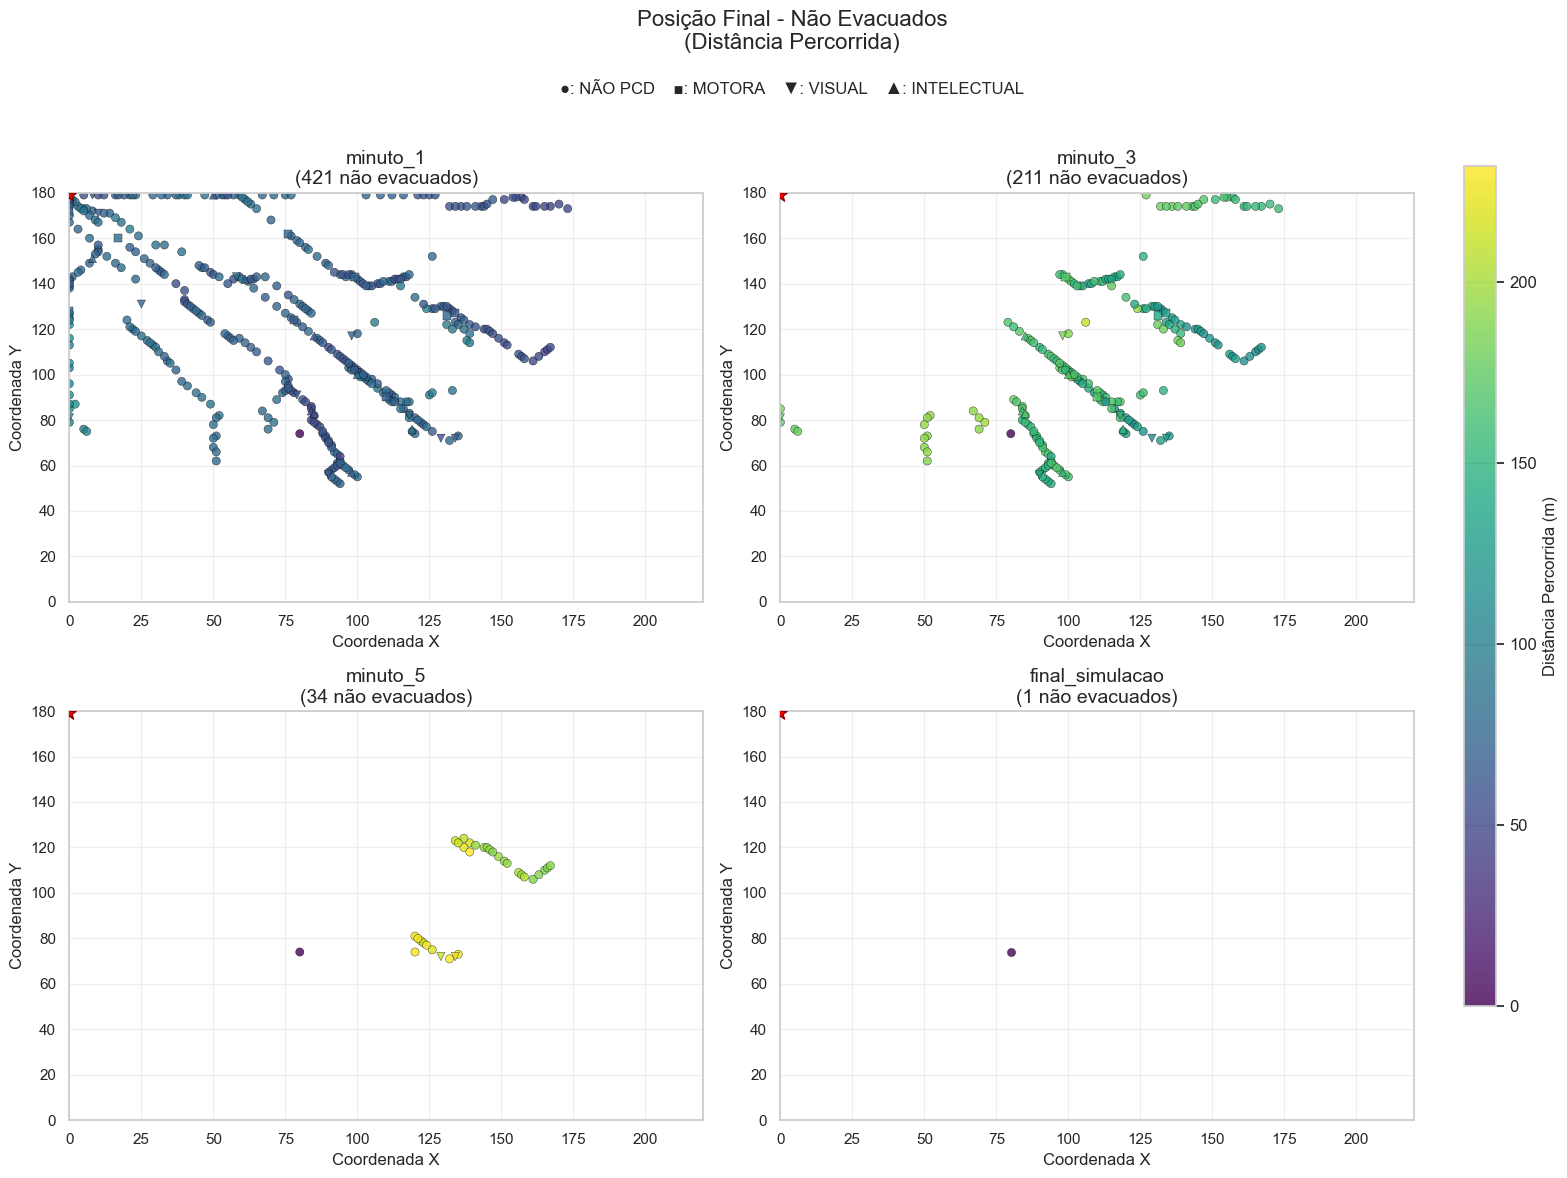


ANÁLISE ESTATÍSTICA DETALHADA

minuto_1:
  Agentes não evacuados: 421
  Distância percorrida (m):
    Min: 0.0m
    Max: 115.3m
    Média: 72.7m
    Mediana: 73.2m
    Q1 (25%): 64.0m
    Q3 (75%): 80.7m
  Agentes com baixa mobilidade (≤64.0m): 106 (25.2%)
  Agentes com alta mobilidade (≥80.7m): 106 (25.2%)
  Por tipo de mobilidade:
    INTELLECTUAL: 9 agentes
      Distância média: 67.3m (mediana: 66.8m)
      Velocidade média: 1.12m/s
    MOTOR: 9 agentes
      Distância média: 71.4m (mediana: 71.1m)
      Velocidade média: 1.19m/s
    NON_PWD: 392 agentes
      Distância média: 72.9m (mediana: 73.5m)
      Velocidade média: 1.21m/s
    VISUAL: 11 agentes
      Distância média: 70.9m (mediana: 69.3m)
      Velocidade média: 1.18m/s
  Regiões com agentes de baixa mobilidade:
    Região (80-100, 60-80): 12 agentes
    Região (140-160, 160-180): 8 agentes
    Região (140-160, 100-120): 8 agentes

minuto_3:
  Agentes não evacuados: 211
  Distância percorrida (m):
    Min: 0.0m
    Max: 

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/3858143177.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/3858143177.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/3858143177.py:187: SettingWithCopyWarning: 
A 

In [97]:
# pos final - nao evacuados
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0                # metros por movimento/step
base_speed = 1.5                 # m/s
time_per_step = step_length / base_speed    # segundos por step de simulação

report_folders = ["minuto_1", "minuto_3", "minuto_5", "final_simulacao"]
base_path = Path("reports/no_landslide")

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Filtrar apenas não evacuados
    df = df[df["evacuated"] != True].copy()
    
    if df.empty:
        dataframes[folder] = df
        print(f"\n=== {folder} ===")
        print("Todos os agentes foram evacuados!")
        continue
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    # Extrair coordenadas x, y da posição final
    df[['x', 'y']] = df['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Agentes não evacuados: {len(df)}")
    print(f"Distância percorrida - min: {df['distance_m'].min():.1f}m, max: {df['distance_m'].max():.1f}m")
    print(f"Velocidade média - min: {df['velocity_m_s'].min():.2f}m/s, max: {df['velocity_m_s'].max():.2f}m/s")

# --- Step 3: Plotar com DISTÂNCIA como variável de cor ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Determinar o range global para distância
all_distances = []
for df in dataframes.values():
    if not df.empty:
        all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin_dist, vmax_dist = 0, max(all_distances)
else:
    vmin_dist, vmax_dist = 0, 100

# Criar gráfico
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Posição Final - Não Evacuados\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.91, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    ax = axes[i // 2, i % 2]

    if df.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, weight='bold')
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder, fontsize=14)
        continue
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = df[df["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=35, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, edgecolors='black', linewidth=0.3)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=12)
    ax.set_ylabel('Coordenada Y', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{folder}\n({len(df)} não evacuados)", fontsize=14)

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()

# --- Análise estatística aprimorada ---
print("\n" + "="*70)
print("ANÁLISE ESTATÍSTICA DETALHADA")
print("="*70)

for folder in report_folders:
    df = dataframes[folder]
    
    if df.empty:
        print(f"\n{folder}: Todos evacuados!")
        continue
        
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df)}")
    print(f"  Distância percorrida (m):")
    print(f"    Min: {df['distance_m'].min():.1f}m")
    print(f"    Max: {df['distance_m'].max():.1f}m")
    print(f"    Média: {df['distance_m'].mean():.1f}m")
    print(f"    Mediana: {df['distance_m'].median():.1f}m")
    
    # Análise por quartis de distância
    q1 = df['distance_m'].quantile(0.25)
    q3 = df['distance_m'].quantile(0.75)
    print(f"    Q1 (25%): {q1:.1f}m")
    print(f"    Q3 (75%): {q3:.1f}m")
    
    # Identificar agentes com baixa mobilidade
    low_mobility = df[df['distance_m'] <= q1]
    high_mobility = df[df['distance_m'] >= q3]
    
    print(f"  Agentes com baixa mobilidade (≤{q1:.1f}m): {len(low_mobility)} ({len(low_mobility)/len(df)*100:.1f}%)")
    print(f"  Agentes com alta mobilidade (≥{q3:.1f}m): {len(high_mobility)} ({len(high_mobility)/len(df)*100:.1f}%)")
    
    # Análise por tipo de mobilidade
    print(f"  Por tipo de mobilidade:")
    mobility_stats = df.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median', 'std'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        median_dist = mobility_stats.loc[mob_type, ('distance_m', 'median')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        print(f"    {mob_type}: {count} agentes")
        print(f"      Distância média: {mean_dist:.1f}m (mediana: {median_dist:.1f}m)")
        print(f"      Velocidade média: {mean_vel:.2f}m/s")
    
    # Análise espacial - onde estão os agentes com menor mobilidade
    if len(low_mobility) > 0:
        print(f"  Regiões com agentes de baixa mobilidade:")
        # Agrupar por regiões aproximadas
        low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
        low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
        
        regions = low_mobility.groupby(['region_x', 'region_y']).size().sort_values(ascending=False)
        for (x, y), count in regions.head(3).items():
            print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {count} agentes")

print("\n" + "="*70)
print("INTERPRETAÇÃO PARA SEU TCC:")
print("="*70)
print("1. A coloração por DISTÂNCIA revela padrões espaciais importantes")
print("2. Agentes com cores mais escuras (menor distância) podem indicar:")
print("   - Obstáculos locais que impedem movimento")
print("   - Gargalos de evacuação")
print("   - Problemas de pathfinding")
print("3. A uniformidade temporal confirma que o fator crítico é ESPACIAL, não temporal")
print("4. Diferentes tipos de mobilidade mostram padrões distintos de movimento")

minuto_1: minute_1_report_20250531-211007.csv
final_simulacao: all_done_report_20250531-211616.csv

=== minuto_1 ===
Agentes não evacuados: 421
Distância percorrida - min: 0.0m, max: 115.3m
Velocidade média - min: 0.00m/s, max: 1.92m/s

=== final_simulacao ===
Agentes não evacuados: 1
Distância percorrida - min: 0.0m, max: 0.0m
Velocidade média - min: 0.00m/s, max: 0.00m/s


/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/4200371890.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


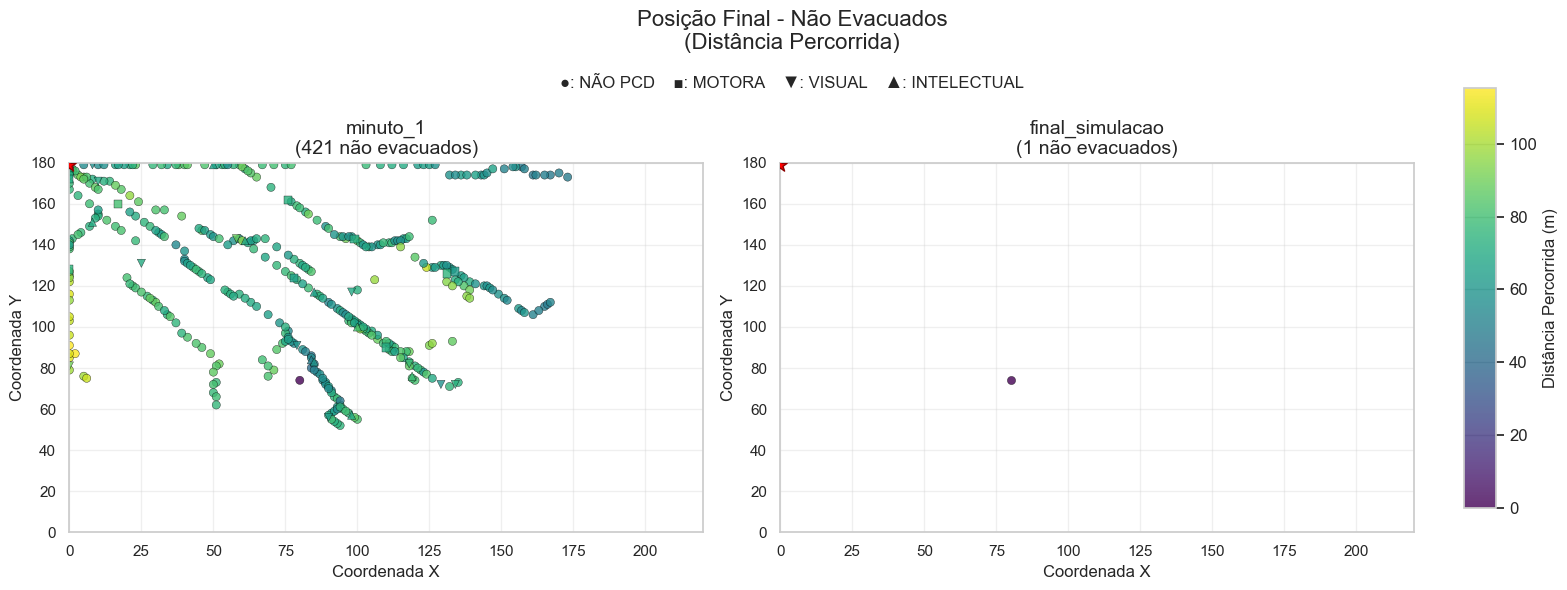


ANÁLISE ESTATÍSTICA DETALHADA

minuto_1:
  Agentes não evacuados: 421
  Distância percorrida (m):
    Min: 0.0m
    Max: 115.3m
    Média: 72.7m
    Mediana: 73.2m
    Q1 (25%): 64.0m
    Q3 (75%): 80.7m
  Agentes com baixa mobilidade (≤64.0m): 106 (25.2%)
  Agentes com alta mobilidade (≥80.7m): 106 (25.2%)
  Por tipo de mobilidade:
    INTELLECTUAL: 9 agentes
      Distância média: 67.3m (mediana: 66.8m)
      Velocidade média: 1.12m/s
    MOTOR: 9 agentes
      Distância média: 71.4m (mediana: 71.1m)
      Velocidade média: 1.19m/s
    NON_PWD: 392 agentes
      Distância média: 72.9m (mediana: 73.5m)
      Velocidade média: 1.21m/s
    VISUAL: 11 agentes
      Distância média: 70.9m (mediana: 69.3m)
      Velocidade média: 1.18m/s
  Regiões com agentes de baixa mobilidade:
    Região (80-100, 60-80): 12 agentes
    Região (140-160, 160-180): 8 agentes
    Região (140-160, 100-120): 8 agentes

final_simulacao:
  Agentes não evacuados: 1
  Distância percorrida (m):
    Min: 0.0m
    

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/4200371890.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/4200371890.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_y'] = (low_mobility['y'] // 20) * 20


In [107]:
# pos final - nao evacuados - dois plots
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0                # metros por movimento/step
base_speed = 1.5                 # m/s
time_per_step = step_length / base_speed    # segundos por step de simulação

report_folders = ["minuto_1","final_simulacao"]
base_path = Path("reports/no_landslide")

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Filtrar apenas não evacuados
    df = df[df["evacuated"] != True].copy()
    
    if df.empty:
        dataframes[folder] = df
        print(f"\n=== {folder} ===")
        print("Todos os agentes foram evacuados!")
        continue
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    # Extrair coordenadas x, y da posição final
    df[['x', 'y']] = df['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Agentes não evacuados: {len(df)}")
    print(f"Distância percorrida - min: {df['distance_m'].min():.1f}m, max: {df['distance_m'].max():.1f}m")
    print(f"Velocidade média - min: {df['velocity_m_s'].min():.2f}m/s, max: {df['velocity_m_s'].max():.2f}m/s")

# --- Step 3: Plotar com DISTÂNCIA como variável de cor ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Determinar o range global para distância
all_distances = []
for df in dataframes.values():
    if not df.empty:
        all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin_dist, vmax_dist = 0, max(all_distances)
else:
    vmin_dist, vmax_dist = 0, 100

# Criar gráfico
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Posição Final - Não Evacuados\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.85, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    ax = axes[i]

    if df.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, weight='bold')
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder, fontsize=14)
        continue
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = df[df["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=35, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, edgecolors='black', linewidth=0.3)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=12)
    ax.set_ylabel('Coordenada Y', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{folder}\n({len(df)} não evacuados)", fontsize=14)

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()

# --- Análise estatística aprimorada ---
print("\n" + "="*70)
print("ANÁLISE ESTATÍSTICA DETALHADA")
print("="*70)

for folder in report_folders:
    df = dataframes[folder]
    
    if df.empty:
        print(f"\n{folder}: Todos evacuados!")
        continue
        
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df)}")
    print(f"  Distância percorrida (m):")
    print(f"    Min: {df['distance_m'].min():.1f}m")
    print(f"    Max: {df['distance_m'].max():.1f}m")
    print(f"    Média: {df['distance_m'].mean():.1f}m")
    print(f"    Mediana: {df['distance_m'].median():.1f}m")
    
    # Análise por quartis de distância
    q1 = df['distance_m'].quantile(0.25)
    q3 = df['distance_m'].quantile(0.75)
    print(f"    Q1 (25%): {q1:.1f}m")
    print(f"    Q3 (75%): {q3:.1f}m")
    
    # Identificar agentes com baixa mobilidade
    low_mobility = df[df['distance_m'] <= q1]
    high_mobility = df[df['distance_m'] >= q3]
    
    print(f"  Agentes com baixa mobilidade (≤{q1:.1f}m): {len(low_mobility)} ({len(low_mobility)/len(df)*100:.1f}%)")
    print(f"  Agentes com alta mobilidade (≥{q3:.1f}m): {len(high_mobility)} ({len(high_mobility)/len(df)*100:.1f}%)")
    
    # Análise por tipo de mobilidade
    print(f"  Por tipo de mobilidade:")
    mobility_stats = df.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median', 'std'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        median_dist = mobility_stats.loc[mob_type, ('distance_m', 'median')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        print(f"    {mob_type}: {count} agentes")
        print(f"      Distância média: {mean_dist:.1f}m (mediana: {median_dist:.1f}m)")
        print(f"      Velocidade média: {mean_vel:.2f}m/s")
    
    # Análise espacial - onde estão os agentes com menor mobilidade
    if len(low_mobility) > 0:
        print(f"  Regiões com agentes de baixa mobilidade:")
        # Agrupar por regiões aproximadas
        low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
        low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
        
        regions = low_mobility.groupby(['region_x', 'region_y']).size().sort_values(ascending=False)
        for (x, y), count in regions.head(3).items():
            print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {count} agentes")

print("\n" + "="*70)
print("INTERPRETAÇÃO PARA SEU TCC:")
print("="*70)
print("1. A coloração por DISTÂNCIA revela padrões espaciais importantes")
print("2. Agentes com cores mais escuras (menor distância) podem indicar:")
print("   - Obstáculos locais que impedem movimento")
print("   - Gargalos de evacuação")
print("   - Problemas de pathfinding")
print("3. A uniformidade temporal confirma que o fator crítico é ESPACIAL, não temporal")
print("4. Diferentes tipos de mobilidade mostram padrões distintos de movimento")

In [200]:
summary_time_related = df_all_done.groupby('mobility_type').agg({
    'time_s':       'mean',
    'distance_m':   'mean',
    'steps':        'mean',
    'velocity_m_s': 'mean',
    'agent_id':     'count'
}).rename(columns={'agent_id':'count_agents'})

In [201]:
df_all_done[df_all_done['time_s'] == 0][['agent_id', 'mobility_type', 'distance_m', 'time_s', 'velocity_m_s']]

agent_id mobility_type  distance_m  time_s  velocity_m_s
5271        471       NON_PWD    1.414214     0.0           0.0
24583       103       NON_PWD    1.000000     0.0           0.0
37842       402       NON_PWD    1.000000     0.0           0.0

In [202]:
summary_time_related

time_s  distance_m       steps  velocity_m_s  count_agents
mobility_type                                                                
INTELLECTUAL   323.422682  151.679782  135.802548      0.517113          1413
MOTOR          325.950717  150.643218  134.665950      0.510760          1395
NON_PWD        312.635488  151.537817  135.193802      0.541708         43823
VISUAL         333.693389  153.170524  136.571950      0.502067          1369

In [203]:
total_agents = len(df_all_done)
evacuated_count = df_all_done['evacuated'].sum()
not_evacuated_count = total_agents - evacuated_count
impacted_count = df_all_done['impacted_by_landslide'].sum()
not_impacted_count = total_agents - impacted_count

In [204]:
summary_evacuation = pd.DataFrame({
    'metric': [
        'total_agents',
        'evacuated',
        'not_evacuated',
        'impacted_by_landslide',
        'not_impacted_by_landslide'
    ],
    'count': [
        total_agents,
        evacuated_count,
        not_evacuated_count,
        impacted_count,
        not_impacted_count
    ]
})

In [212]:
import pandas as pd
from pathlib import Path

# Folder path
folder = Path("reports/no_landslide/final_simulacao")

# Read and combine all CSV files
dfs = []
for file in folder.glob("*.csv"):
    df = pd.read_csv(file)
    dfs.append(df)

# Combine all into one DataFrame
all_data = pd.concat(dfs, ignore_index=True)

# Filter non-evacuated
non_evacuated = all_data[all_data["evacuated"] != True]

# Count how many are missing final_pos
missing_final_pos = non_evacuated["final_pos"].isna().sum()

print(f"Total non-evacuated agents: {len(non_evacuated)}")
print(f"Missing final_pos: {missing_final_pos}")


Total non-evacuated agents: 56
Missing final_pos: 0


In [205]:
summary_evacuation

metric  count
0               total_agents  48000
1                  evacuated  47944
2              not_evacuated     56
3      impacted_by_landslide      0
4  not_impacted_by_landslide  48000

## One risk area

In [154]:
df_one_risk_area_all_done = load_report_data("final_simulacao", step_length, time_per_step)

In [160]:
report_folders = ["minuto_1", "minuto_3", "final_simulacao"]

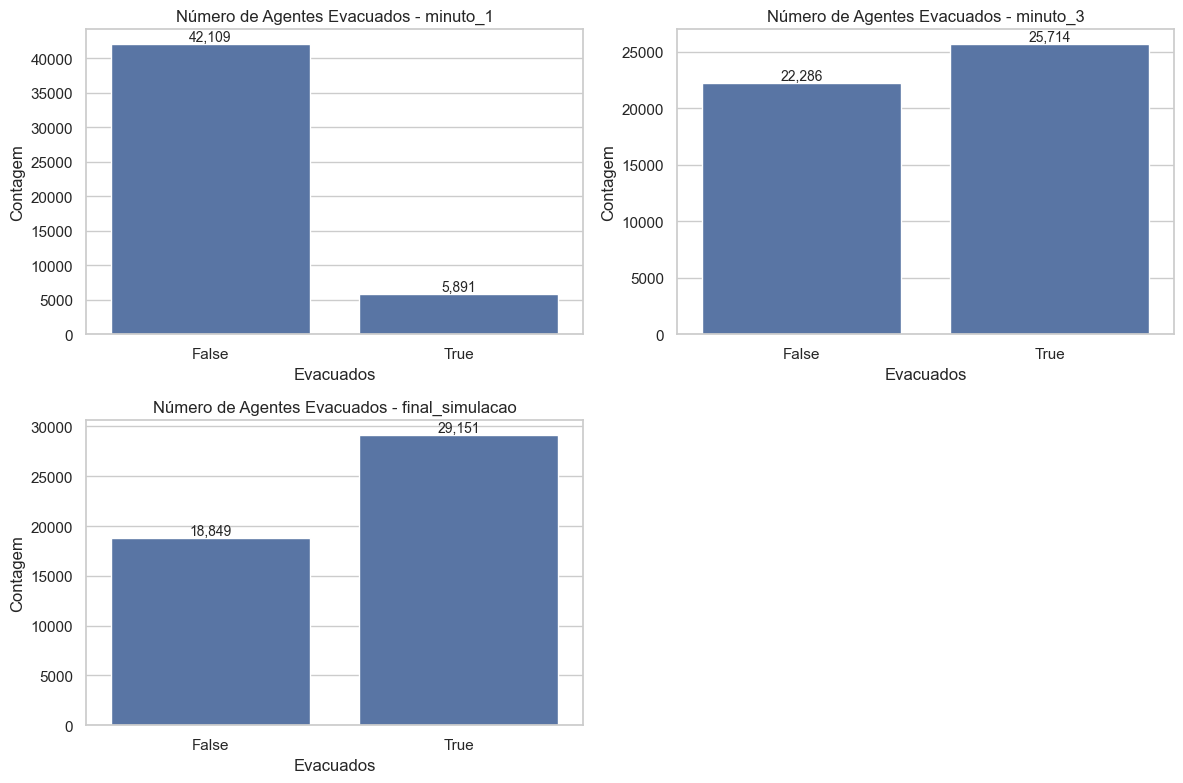

In [235]:
# número de agentes evacuados ao longo da simulação
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    sns.countplot(data=df, x='evacuated', order=[False, True], ax=ax)

    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f"{count:,}", 
                    (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='bottom', fontsize=10)

    ax.set(title=f"Número de Agentes Evacuados - {folder}", xlabel="Evacuados", ylabel="Contagem")

# Hide any unused subplot axes
for j in range(len(report_folders), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
fig.savefig(download_dir / "grid_evacuated_count_LINEAR.png")
plt.show()
plt.close(fig)


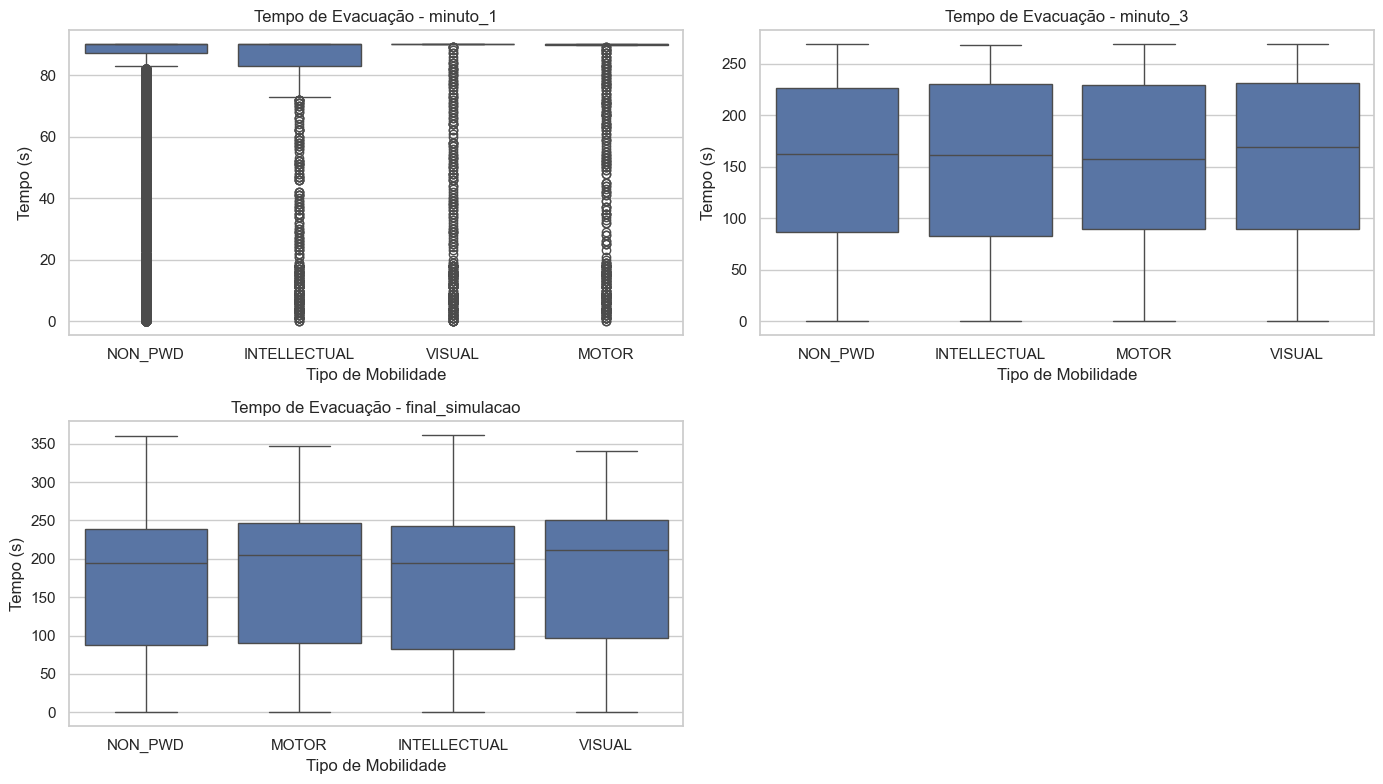

In [237]:
# boxplot ao longo da simulação
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'mobility_type' in df.columns and 'time_s' in df.columns and not df.empty:
        sns.boxplot(data=df, x='mobility_type', y='time_s', ax=ax)
        ax.set(title=f"Tempo de Evacuação - {folder}", xlabel="Tipo de Mobilidade", ylabel="Tempo (s)")
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set(title=f"Tempo de Evacuação - {folder}")

for j in range(len(report_folders), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
fig.savefig(download_dir / "grid_boxplot_time.png")
plt.show()
plt.close(fig)


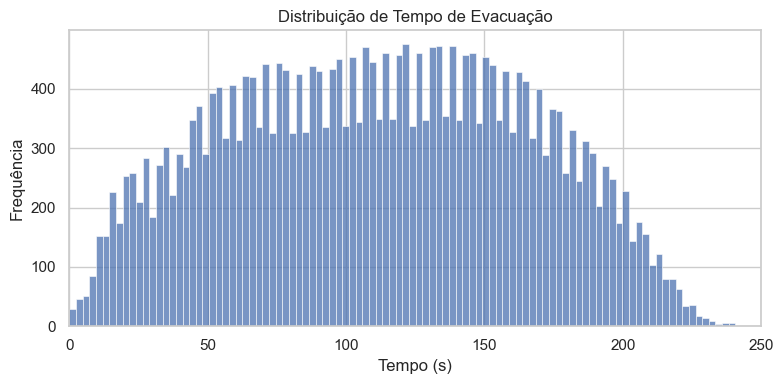

In [156]:
# Distribution of Evacuation Time (histograma)
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(df_one_risk_area_all_done[df_one_risk_area_all_done["evacuated"] == True], x="time_s", bins=100)
plt.xlim(0, 250)
ax.set(title="Distribuição de Tempo de Evacuação", xlabel="Tempo (s)", ylabel="Frequência")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "hist_time.png")
plt.close(fig)

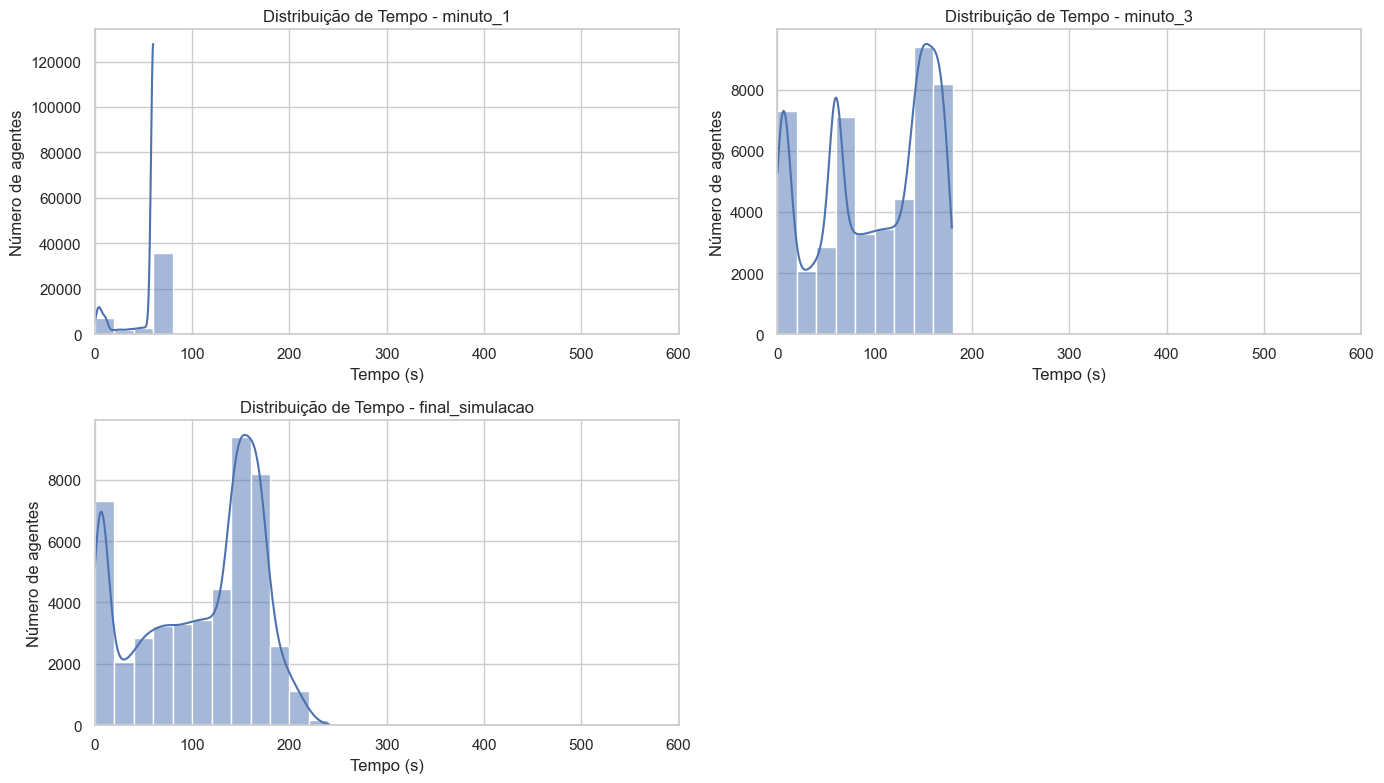

In [164]:
# distribuição do tempo de movimento

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'time_s' in df.columns and not df['time_s'].dropna().empty:
        sns.histplot(data=df, x='time_s', bins=30, binrange=(0,600), kde=True, ax=ax)
        ax.set_xlim(0, 600)
        ax.set(title=f"Distribuição de Tempo - {folder}", xlabel="Tempo (s)", ylabel="Número de agentes")
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set(title=f"Distribuição de Tempo - {folder}")

axes[3].remove()

fig.tight_layout()
fig.savefig(download_dir / "grid_hist_time.png")
plt.show()
plt.close(fig)

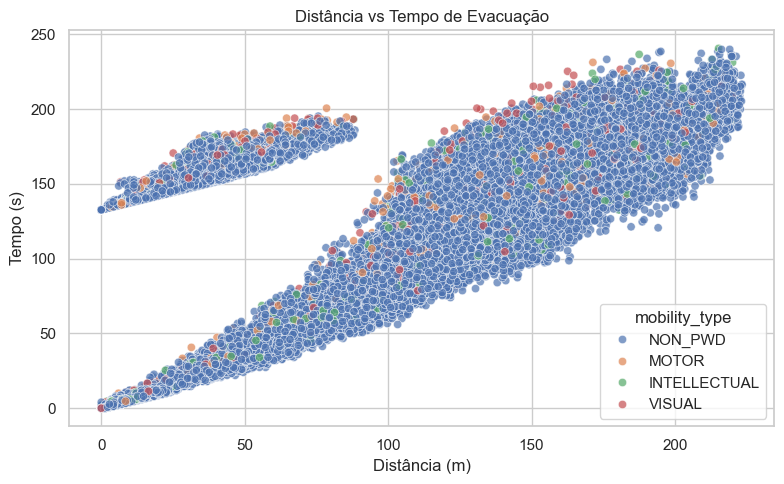

In [64]:
# Distance vs. Time (scatter)
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=df_one_risk_area_all_done, x='distance_m', y='time_s', hue='mobility_type', alpha=0.7, ax=ax)
ax.set(title="Distância vs Tempo de Evacuação", xlabel="Distância (m)", ylabel="Tempo (s)")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "scatter_dist_vs_time.png")
plt.close(fig)

Agentes com baixa eficiência (dist < 100m e tempo > 150s): 8409
Percentual do total: 17.5%


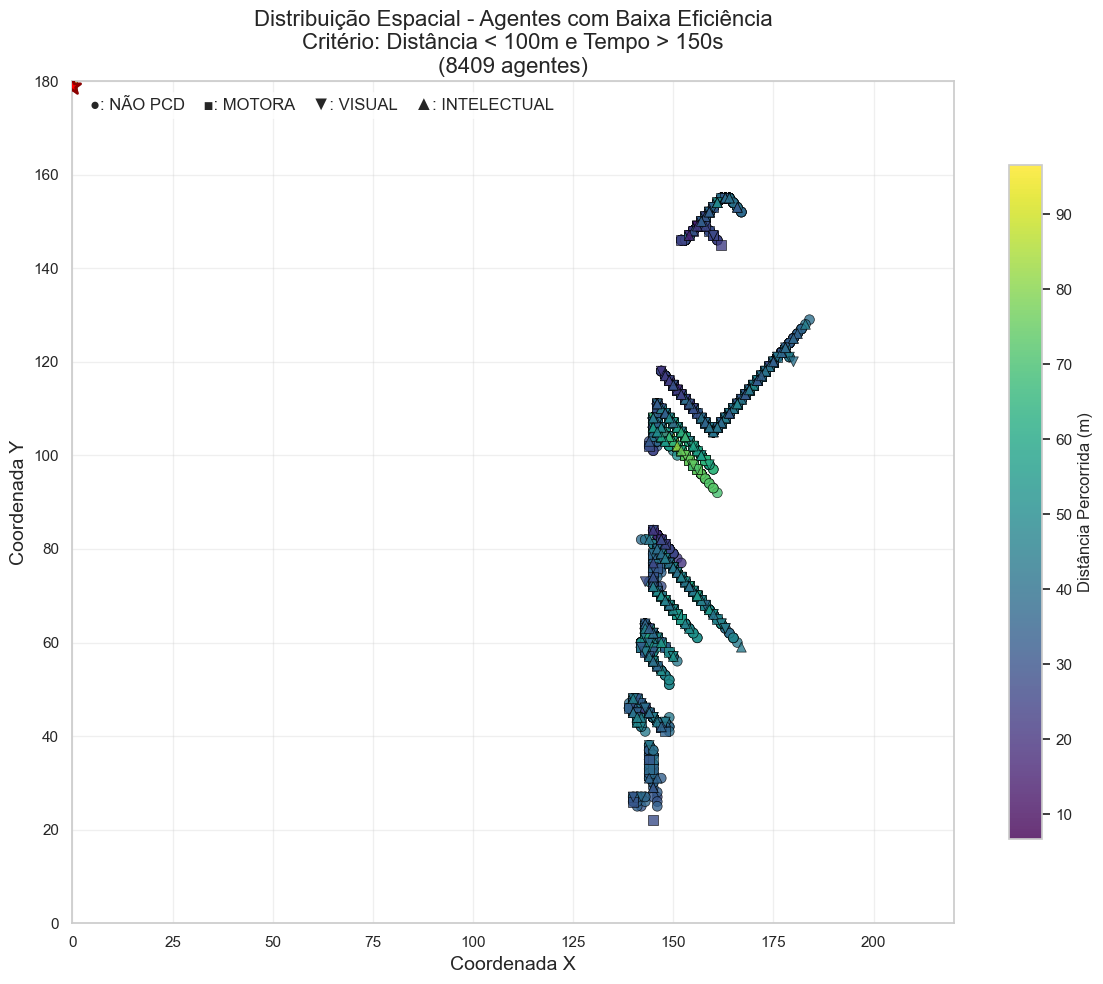


ANÁLISE ESTATÍSTICA DOS AGENTES INEFICIENTES

Resumo Geral:
  Total de agentes ineficientes: 8409
  Distância percorrida:
    Min: 6.7m
    Max: 96.5m
    Média: 44.8m
    Mediana: 43.2m
  Tempo gasto:
    Min: 150.7s
    Max: 200.7s
    Média: 164.4s
    Mediana: 164.0s
  Velocidade média:
    Min: 0.044m/s
    Max: 0.629m/s
    Média: 0.270m/s

Por tipo de mobilidade:
  INTELLECTUAL: 266 agentes (3.2%)
    Distância média: 42.4m
    Tempo médio: 165.4s
    Velocidade média: 0.250m/s
  MOTOR: 289 agentes (3.4%)
    Distância média: 44.1m
    Tempo médio: 167.5s
    Velocidade média: 0.260m/s
  NON_PWD: 7582 agentes (90.2%)
    Distância média: 45.0m
    Tempo médio: 164.2s
    Velocidade média: 0.270m/s
  VISUAL: 272 agentes (3.2%)
    Distância média: 42.1m
    Tempo médio: 166.7s
    Velocidade média: 0.250m/s

Análise Espacial - Regiões com maior concentração:
  Top 5 regiões com mais agentes ineficientes:
    Região (140-160, 100-120): 2958.0 agentes
      Dist. média: 47.5m, Tem

In [85]:
# filtrar scatter 
# filtrar scatter
# Análise Espacial - Agentes com Alta Ineficiência (Baixa Distância + Alto Tempo)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Filtrar agentes com alta ineficiência ---
# Critério: distância < 100m E tempo > 150s
inefficient_agents = df_one_risk_area_all_done[
    (df_one_risk_area_all_done['distance_m'] < 100) & 
    (df_one_risk_area_all_done['time_s'] > 150)
].copy()

print(f"Agentes com baixa eficiência (dist < 100m e tempo > 150s): {len(inefficient_agents)}")
print(f"Percentual do total: {len(inefficient_agents)/len(df_one_risk_area_all_done)*100:.1f}%")

if inefficient_agents.empty:
    print("Nenhum agente encontrado com os critérios especificados!")
else:
    # Extrair coordenadas x, y da posição final
    inefficient_agents[['x', 'y']] = inefficient_agents['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # --- Configurações do plot ---
    mobility_markers = {
        "NON_PWD": "o", 
        "MOTOR": "s", 
        "VISUAL": "v", 
        "INTELLECTUAL": "^"
    }
    
    # Determinar range para distância (para coloração)
    vmin_dist = inefficient_agents['distance_m'].min()
    vmax_dist = inefficient_agents['distance_m'].max()
    
    # --- Criar gráfico ---
    fig, ax = plt.subplots(figsize=(12, 10))
    
    sc_for_colorbar = None
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = inefficient_agents[inefficient_agents["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=50, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, 
                           edgecolors='black', linewidth=0.5)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc
    
    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=150, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=2)
    
    # Configurações do plot
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=14)
    ax.set_ylabel('Coordenada Y', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Distribuição Espacial - Agentes com Baixa Eficiência\n" +
                f"Critério: Distância < 100m e Tempo > 150s\n" +
                f"({len(inefficient_agents)} agentes)", fontsize=16)
    
    # Legenda dos marcadores
    ax.text(0.02, 0.98, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Adicionar colorbar
    if sc_for_colorbar:
        cbar = plt.colorbar(sc_for_colorbar, ax=ax, shrink=0.8)
        cbar.set_label("Distância Percorrida (m)", fontsize=12)
        cbar.ax.tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # --- Análise estatística detalhada ---
    print("\n" + "="*70)
    print("ANÁLISE ESTATÍSTICA DOS AGENTES INEFICIENTES")
    print("="*70)
    
    print(f"\nResumo Geral:")
    print(f"  Total de agentes ineficientes: {len(inefficient_agents)}")
    print(f"  Distância percorrida:")
    print(f"    Min: {inefficient_agents['distance_m'].min():.1f}m")
    print(f"    Max: {inefficient_agents['distance_m'].max():.1f}m")
    print(f"    Média: {inefficient_agents['distance_m'].mean():.1f}m")
    print(f"    Mediana: {inefficient_agents['distance_m'].median():.1f}m")
    
    print(f"  Tempo gasto:")
    print(f"    Min: {inefficient_agents['time_s'].min():.1f}s")
    print(f"    Max: {inefficient_agents['time_s'].max():.1f}s")
    print(f"    Média: {inefficient_agents['time_s'].mean():.1f}s")
    print(f"    Mediana: {inefficient_agents['time_s'].median():.1f}s")
    
    print(f"  Velocidade média:")
    print(f"    Min: {inefficient_agents['velocity_m_s'].min():.3f}m/s")
    print(f"    Max: {inefficient_agents['velocity_m_s'].max():.3f}m/s")
    print(f"    Média: {inefficient_agents['velocity_m_s'].mean():.3f}m/s")
    
    # Análise por tipo de mobilidade
    print(f"\nPor tipo de mobilidade:")
    mobility_stats = inefficient_agents.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median'],
        'time_s': ['mean', 'median'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        mean_time = mobility_stats.loc[mob_type, ('time_s', 'mean')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        percentage = (count / len(inefficient_agents)) * 100
        
        print(f"  {mob_type}: {count} agentes ({percentage:.1f}%)")
        print(f"    Distância média: {mean_dist:.1f}m")
        print(f"    Tempo médio: {mean_time:.1f}s")
        print(f"    Velocidade média: {mean_vel:.3f}m/s")
    
    # Análise espacial - regiões com maior concentração
    print(f"\nAnálise Espacial - Regiões com maior concentração:")
    inefficient_agents['region_x'] = (inefficient_agents['x'] // 20) * 20  # Grupos de 20 unidades
    inefficient_agents['region_y'] = (inefficient_agents['y'] // 20) * 20
    
    regions = inefficient_agents.groupby(['region_x', 'region_y']).agg({
        'agent_id': 'count',
        'distance_m': 'mean',
        'time_s': 'mean',
        'velocity_m_s': 'mean'
    }).round(2)
    regions.columns = ['count', 'avg_dist', 'avg_time', 'avg_velocity']
    regions = regions.sort_values('count', ascending=False)
    
    print("  Top 5 regiões com mais agentes ineficientes:")
    for (x, y), row in regions.head(5).iterrows():
        print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {row['count']} agentes")
        print(f"      Dist. média: {row['avg_dist']:.1f}m, Tempo médio: {row['avg_time']:.1f}s")
        print(f"      Velocidade média: {row['avg_velocity']:.3f}m/s")
    
    # Status de evacuação
    print(f"\nStatus de Evacuação:")
    evacuation_stats = inefficient_agents['evacuated'].value_counts()
    for status, count in evacuation_stats.items():
        percentage = (count / len(inefficient_agents)) * 100
        status_name = "Evacuados" if status else "Não Evacuados"
        print(f"  {status_name}: {count} agentes ({percentage:.1f}%)")
    
    # Outros status importantes
    if 'stuck' in inefficient_agents.columns:
        stuck_count = inefficient_agents['stuck'].sum()
        print(f"  Agentes 'stuck': {stuck_count} ({stuck_count/len(inefficient_agents)*100:.1f}%)")
    
    if 'impacted_by_landslide' in inefficient_agents.columns:
        landslide_count = inefficient_agents['impacted_by_landslide'].sum()
        print(f"  Impactados por deslizamento: {landslide_count} ({landslide_count/len(inefficient_agents)*100:.1f}%)")
    
    print("\n" + "="*70)
    print("INTERPRETAÇÃO PARA SEU TCC:")
    print("="*70)
    print("1. Agentes com ALTA INEFICIÊNCIA (baixa distância + alto tempo) indicam:")
    print("   - Gargalos críticos no sistema de evacuação")
    print("   - Obstáculos ou barreiras que impedem movimento eficiente")
    print("   - Possíveis falhas no algoritmo de pathfinding")
    print("   - Aglomerações que causam congestionamento")
    print("\n2. A distribuição espacial revela:")
    print("   - Zonas problemáticas específicas no ambiente")
    print("   - Padrões de concentração de agentes ineficientes")
    print("   - Relação entre localização e performance de evacuação")
    print("\n3. A análise por tipo de mobilidade mostra:")
    print("   - Se algum grupo específico é mais afetado")
    print("   - Diferenças na capacidade de superar obstáculos")
    print("   - Necessidades específicas de cada tipo de agente")

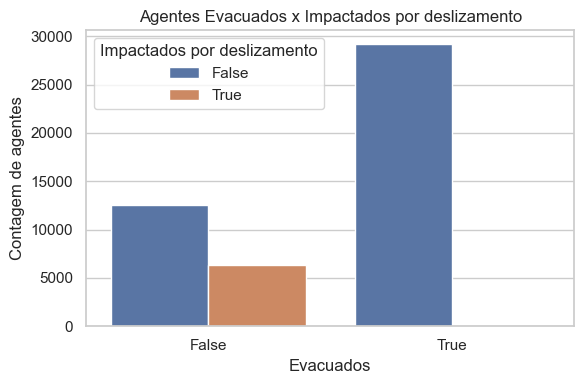

In [258]:
# Evacuation Count by Landslide Impact (hue) - final
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=df_one_risk_area_all_done, x='evacuated', hue='impacted_by_landslide', ax=ax)
ax.set(title="Agentes Evacuados x Impactados por deslizamento",
       xlabel="Evacuados", ylabel="Contagem de agentes")
ax.legend(title="Impactados por deslizamento")
fig.tight_layout()
fig.savefig(download_dir / "evacuated_by_landslide_hue.png")
plt.show()
plt.close(fig)

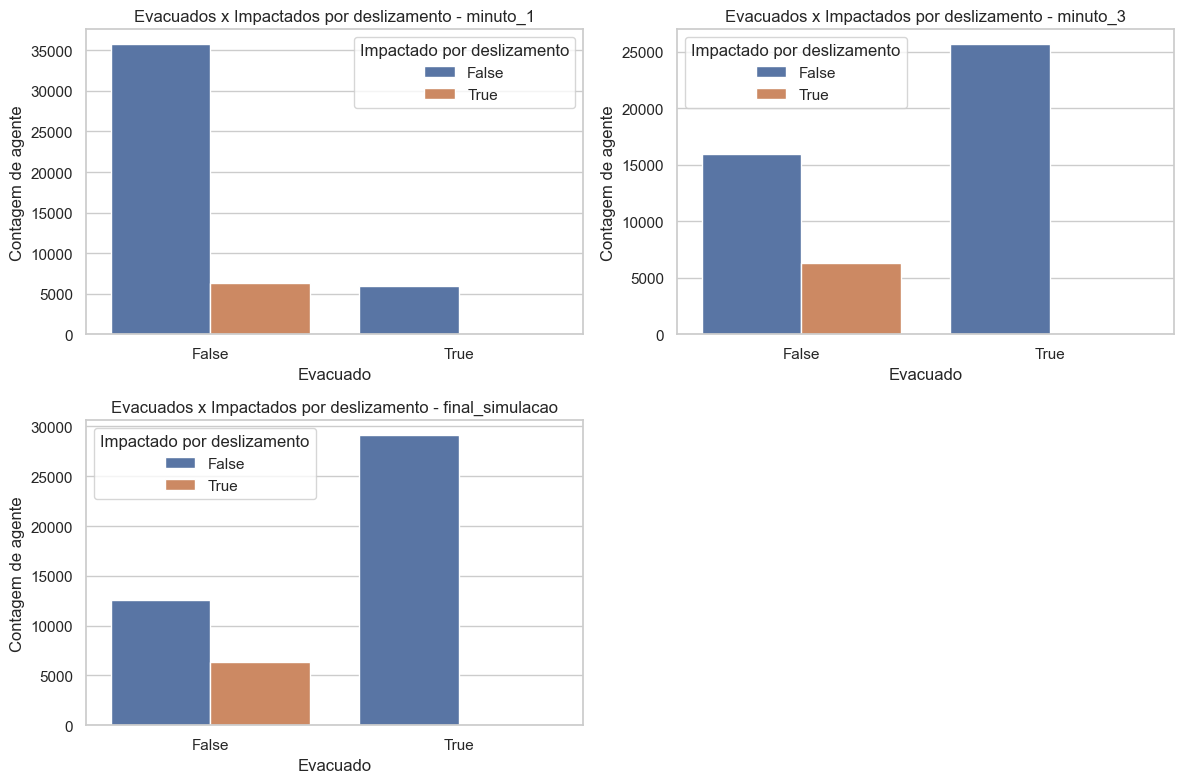

In [257]:
# evacuados x impactados por deslizamentos ao longo da simulação
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'evacuated' in df.columns and 'impacted_by_landslide' in df.columns:
        sns.countplot(data=df, x='evacuated', hue='impacted_by_landslide', ax=ax)
        ax.set(title=f"Evacuados x Impactados por deslizamento - {folder}",
               xlabel="Evacuado", ylabel="Contagem de agente")
        ax.legend(title="Impactado por deslizamento")
    else:
        ax.text(0.5, 0.5, "No data", ha='center', va='center')
        ax.set_xticks([]); ax.set_yticks([])

for j in range(len(report_folders), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
fig.savefig(download_dir / "grid_evacuated_by_landslide_hue.png")
plt.show()
plt.close(fig)

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/1967549854.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/1967549854.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_63409/1967549854.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


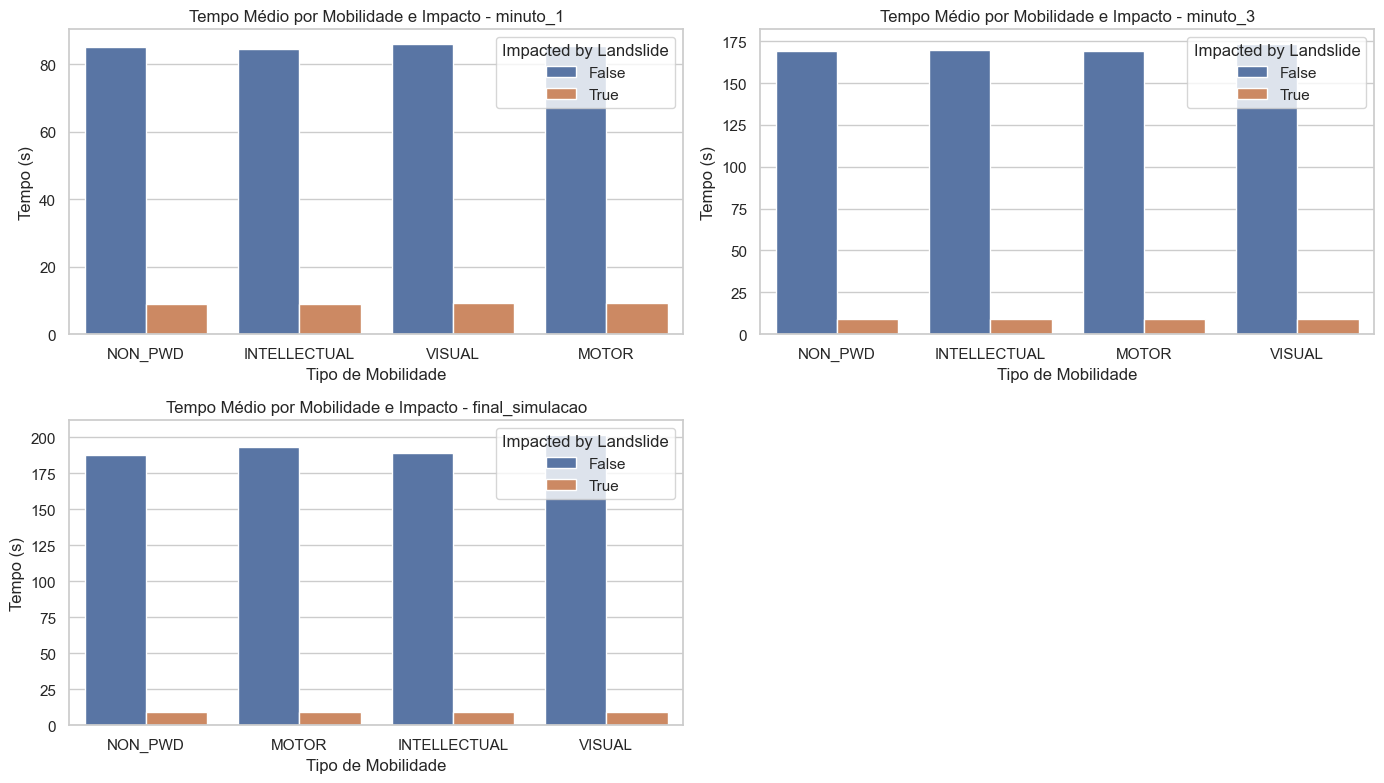

In [245]:
# tempo médio por mobilidade e impacto pela simulação toda
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'mobility_type' in df.columns and 'time_s' in df.columns and 'impacted_by_landslide' in df.columns:
        sns.barplot(
            data=df, x='mobility_type', y='time_s',
            hue='impacted_by_landslide', ci=None, ax=ax
        )
        ax.set(title=f"Tempo Médio por Mobilidade e Impacto - {folder}",
               xlabel="Tipo de Mobilidade", ylabel="Tempo (s)")
        ax.legend(title="Impacted by Landslide")
    else:
        ax.text(0.5, 0.5, "No data", ha='center', va='center')
        ax.set_xticks([]); ax.set_yticks([])

for j in range(len(report_folders), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
fig.savefig(download_dir / "grid_avg_time_by_landslide.png")
plt.show()
plt.close(fig)

In [196]:
# descobrir tempo total de simulação
from pathlib import Path
import pandas as pd

# CONFIGURAÇÕES - AJUSTE PARA SEU CENÁRIO
base_path = Path("reports/one_risk_area")

# Configurações da simulação (mantenha iguais)
step_length = 1.0
base_speed = 1.5
time_per_step = step_length / base_speed

print("=== DESCOBRINDO TEMPO TOTAL DA SIMULAÇÃO ===")
print(f"Analisando pasta: {base_path}")
print()

# Função para descobrir o tempo máximo em cada momento
def discover_max_time(folder_path):
    """Descobre o tempo máximo real da simulação analisando os dados"""
    try:
        # Pegar o arquivo mais recente
        all_csvs = list(folder_path.glob("*.csv"))
        if not all_csvs:
            return None, "Nenhum arquivo CSV encontrado"
        
        latest_file = min(all_csvs, key=lambda x: x.stat().st_mtime)
        df = pd.read_csv(latest_file)
        
        # Converter dados
        df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
        
        # Para descobrir o tempo total, precisamos analisar os agentes evacuados
        # pois eles têm o tempo completo até a evacuação
        evacuated_agents = df[df['evacuated'] == True]
        
        if len(evacuated_agents) > 0:
            max_time_ticks = evacuated_agents['time_spent'].max()
            max_time_seconds = max_time_ticks * time_per_step
            
            return max_time_seconds, f"Baseado em {len(evacuated_agents)} agentes evacuados"
        else:
            # Se ninguém foi evacuado, usar o máximo geral
            max_time_ticks = df['time_spent'].max()
            max_time_seconds = max_time_ticks * time_per_step
            
            return max_time_seconds, "Baseado no máximo geral (nenhum agente evacuado)"
            
    except Exception as e:
        return None, f"Erro: {e}"

# Descobrir os tempos para cada momento
discovered_times = {}
for folder in report_folders:
    folder_path = base_path / folder
    max_time, info = discover_max_time(folder_path)
    
    if max_time is not None:
        discovered_times[folder] = max_time
        print(f"{folder}:")
        print(f"  Tempo máximo descoberto: {max_time:.1f} segundos")
        print(f"  Info: {info}")
        print()
    else:
        print(f"{folder}: ERRO - {info}")
        print()

# Gerar o código que você deve usar no script principal
print("="*50)
print("CÓDIGO PARA USAR NO SEU SCRIPT PRINCIPAL:")
print("="*50)
print()
print("# Tempos descobertos automaticamente:")
print("simulation_elapsed_time = {")
for folder, time_val in discovered_times.items():
    print(f'    "{folder}": {time_val:.1f},')
print("}")
print()

# Validação - os tempos fazem sentido?
print("="*30)
print("VALIDAÇÃO:")
print("="*30)
expected_times = {
    "minuto_1": 60,
    "minuto_3": 180, 
    "minuto_5": 300
}

if "final_simulacao" in discovered_times:
    final_time = discovered_times["final_simulacao"]
    print(f"final_simulacao: {final_time:.1f}s (tempo total da simulação)")

=== DESCOBRINDO TEMPO TOTAL DA SIMULAÇÃO ===
Analisando pasta: reports/one_risk_area

minuto_1:
  Tempo máximo descoberto: 59.3 segundos
  Info: Baseado em 60 agentes evacuados

minuto_3:
  Tempo máximo descoberto: 179.3 segundos
  Info: Baseado em 266 agentes evacuados

final_simulacao:
  Tempo máximo descoberto: 214.7 segundos
  Info: Baseado em 295 agentes evacuados

CÓDIGO PARA USAR NO SEU SCRIPT PRINCIPAL:

# Tempos descobertos automaticamente:
simulation_elapsed_time = {
    "minuto_1": 59.3,
    "minuto_3": 179.3,
    "final_simulacao": 214.7,
}

VALIDAÇÃO:
final_simulacao: 214.7s (tempo total da simulação)


minuto_1: minute_1_report_20250601-200230.csv
minuto_3: minute_3_report_20250601-201155.csv
final_simulacao: all_done_report_20250601-201155.csv

=== minuto_1 ===
Total de agentes: 480
Não evacuados: 420
time_spent (ticks) - min: 0.0, max: 90.0
time_s (segundos) - min: 0.0, max: 60.0
Tempo decorrido na simulação: 60 segundos
Eficiência média de movimento: 82.5%
⚠️  74 agentes com baixa eficiência de movimento (<30%)

=== minuto_3 ===
Total de agentes: 480
Não evacuados: 214
time_spent (ticks) - min: 0.0, max: 269.0
time_s (segundos) - min: 0.0, max: 179.3
Tempo decorrido na simulação: 180 segundos
Eficiência média de movimento: 54.8%
⚠️  119 agentes com baixa eficiência de movimento (<30%)

=== final_simulacao ===
Total de agentes: 480
Não evacuados: 185
time_spent (ticks) - min: 0.0, max: 322.0
time_s (segundos) - min: 0.0, max: 214.7
Tempo decorrido na simulação: 214.7 segundos
Eficiência média de movimento: 49.9%
⚠️  131 agentes com baixa eficiência de movimento (<30%)


/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2903897836.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


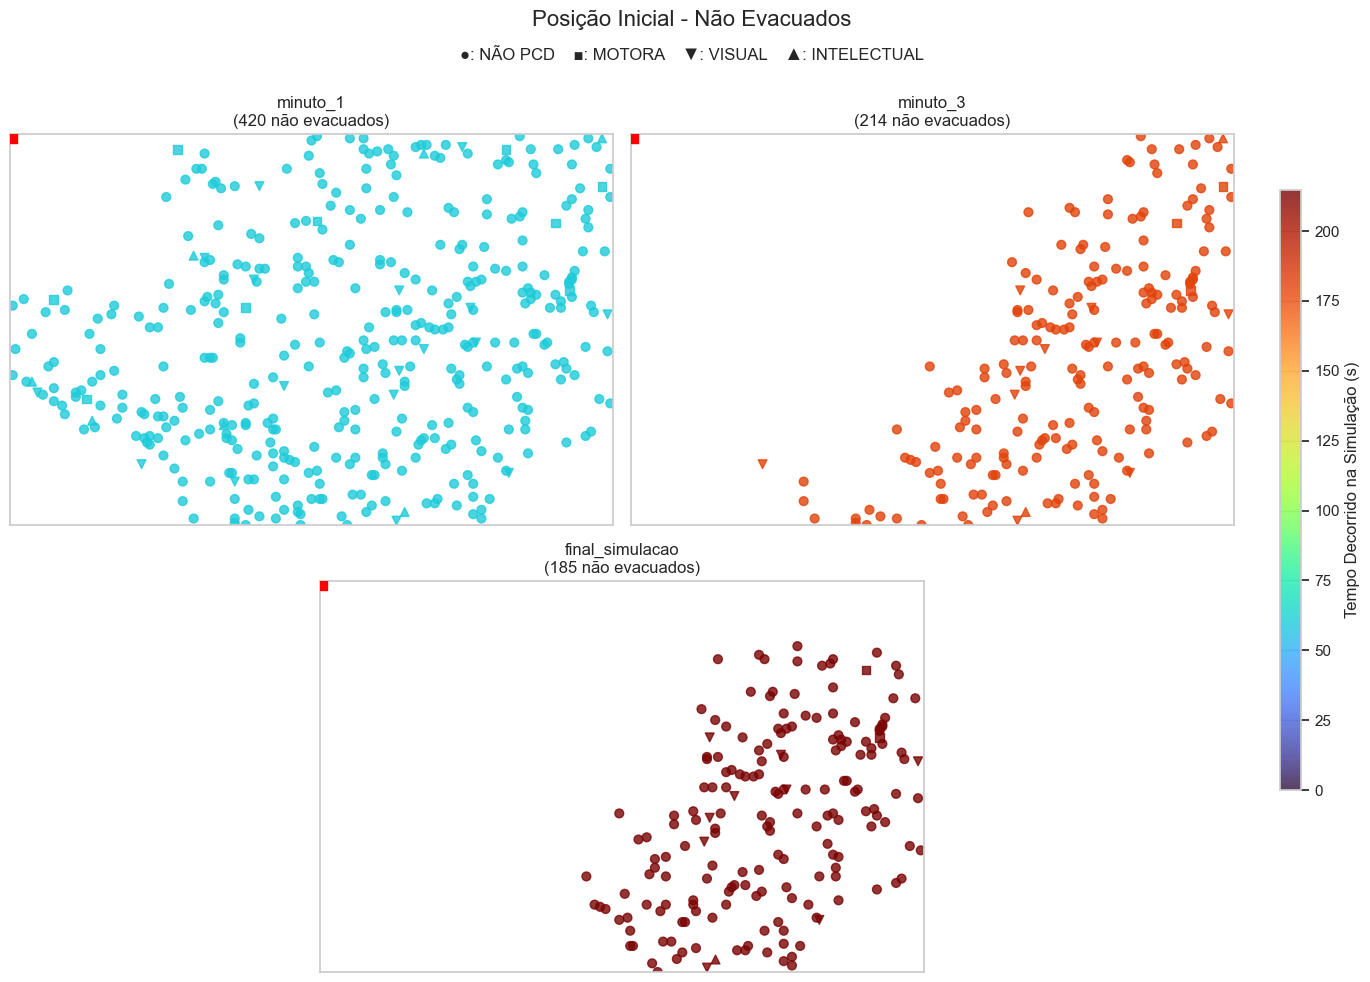


ANÁLISE DETALHADA

minuto_1:
  Agentes não evacuados: 420
  Time_spent (ticks): count    420.000000
mean      77.280952
std       29.826821
min        0.000000
25%       90.000000
50%       90.000000
75%       90.000000
max       90.000000
Name: time_spent, dtype: float64
  Time_s (segundos): count    420.000000
mean      51.520635
std       19.884547
min        0.000000
25%       60.000000
50%       60.000000
75%       60.000000
max       60.000000
Name: time_s, dtype: float64

minuto_3:
  Agentes não evacuados: 214
  Time_spent (ticks): count    214.000000
mean     144.873832
std      103.909440
min        0.000000
25%       13.000000
50%      213.500000
75%      236.750000
max      263.000000
Name: time_spent, dtype: float64
  Time_s (segundos): count    214.000000
mean      96.582555
std       69.272960
min        0.000000
25%        8.666667
50%      142.333333
75%      157.833333
max      175.333333
Name: time_s, dtype: float64

final_simulacao:
  Agentes não evacuados: 185
  Ti

In [15]:
# posicao inicial - nao evacuados
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

base_path = Path("reports/one_risk_area")

# Tempo decorrido na simulação para cada momento (em segundos)
simulation_elapsed_time = {
    "minuto_1": 60,
    "minuto_3": 180,
    "final_simulacao": 214.7  # Baseado no max observado
}

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step  # ESTA é a conversão correta para segundos
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Total de agentes: {len(df)}")
    print(f"Não evacuados: {len(df[df['evacuated'] == False])}")
    print(f"time_spent (ticks) - min: {df['time_spent'].min():.1f}, max: {df['time_spent'].max():.1f}")
    print(f"time_s (segundos) - min: {df['time_s'].min():.1f}, max: {df['time_s'].max():.1f}")
    print(f"Tempo decorrido na simulação: {simulation_elapsed_time[folder]} segundos")
    
    # Calcular eficiência de movimento (% do tempo que passaram se movendo)
    if simulation_elapsed_time[folder] > 0:
        df['movement_efficiency'] = (df['time_s'] / simulation_elapsed_time[folder]) * 100
        avg_efficiency = df['movement_efficiency'].mean()
        print(f"Eficiência média de movimento: {avg_efficiency:.1f}%")
        
        # Agentes que passaram muito pouco tempo se movendo (podem estar stuck)
        low_efficiency = df[df['movement_efficiency'] < 30]  # Menos de 30% do tempo se movendo
        if len(low_efficiency) > 0:
            print(f"⚠️  {len(low_efficiency)} agentes com baixa eficiência de movimento (<30%)")

# --- Step 3: Plotar os dados corrigidos (3 plots) ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Criar figura com 3 subplots: 2 em cima, 1 embaixo centralizado
fig = plt.figure(figsize=(14, 10))
fig.suptitle("Posição Inicial - Não Evacuados", fontsize=16)
fig.text(0.5, 0.93, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

# Criar os 3 subplots manualmente com GridSpec para controlar proporções
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])  # Primeiro plot (metade superior esquerda)
ax2 = fig.add_subplot(gs[0, 2:4])  # Segundo plot (metade superior direita)
ax3 = fig.add_subplot(gs[1, 1:3])  # Terceiro plot (centro inferior, mesma largura)
axes = [ax1, ax2, ax3]

# Determinar o range global para a cor (baseado no tempo decorrido da simulação)
vmin, vmax = 0, max(simulation_elapsed_time.values())

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    df_not_evacuated = df[df["evacuated"] == False].copy()
    ax = axes[i]
    
    # Tempo decorrido na simulação para este momento
    elapsed_time = simulation_elapsed_time[folder]

    if df_not_evacuated.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=12)
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder)
        continue

    # Extrair coordenadas x, y da posição inicial
    df_not_evacuated[['x', 'y']] = df_not_evacuated['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Plotar por tipo de mobilidade
    for mob, marker in mobility_markers.items():
        sub = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub.empty:
            # CORREÇÃO: usar o tempo decorrido da simulação em vez de time_s individual
            # Todos os agentes não evacuados têm o mesmo "tempo na simulação"
            time_color = [elapsed_time] * len(sub)
            sc = ax.scatter(sub['x'], sub['y'], c=time_color, cmap='turbo',
                           s=40, alpha=0.8, marker=marker, vmin=vmin, vmax=vmax, label=mob)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='s', label='Zona Segura', zorder=10)
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{folder}\n({len(df_not_evacuated)} não evacuados)")

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Tempo Decorrido na Simulação (s)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- Análise adicional para entender os dados ---
print("\n" + "="*50)
print("ANÁLISE DETALHADA")
print("="*50)

for folder in report_folders:
    df = dataframes[folder]
    df_not_evac = df[df["evacuated"] == False]
    
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df_not_evac)}")
    if len(df_not_evac) > 0:
        print(f"  Time_spent (ticks): {df_not_evac['time_spent'].describe()}")
        print(f"  Time_s (segundos): {df_not_evac['time_s'].describe()}")
        
        # Verificar se há agentes com time_spent inconsistente
        if folder == "minuto_1":
            max_expected_ticks = 60 / time_per_step  # ~90 ticks para 1 minuto
            weird_agents = df_not_evac[df_not_evac['time_spent'] > max_expected_ticks]
            if len(weird_agents) > 0:
                print(f"  ⚠️  Agentes com time_spent > {max_expected_ticks:.0f} ticks:")
                print(f"     {weird_agents[['agent_id', 'time_spent', 'time_s']].to_string()}")

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/561805628.py:92: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/561805628.py:92: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/561805628.py:92: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1

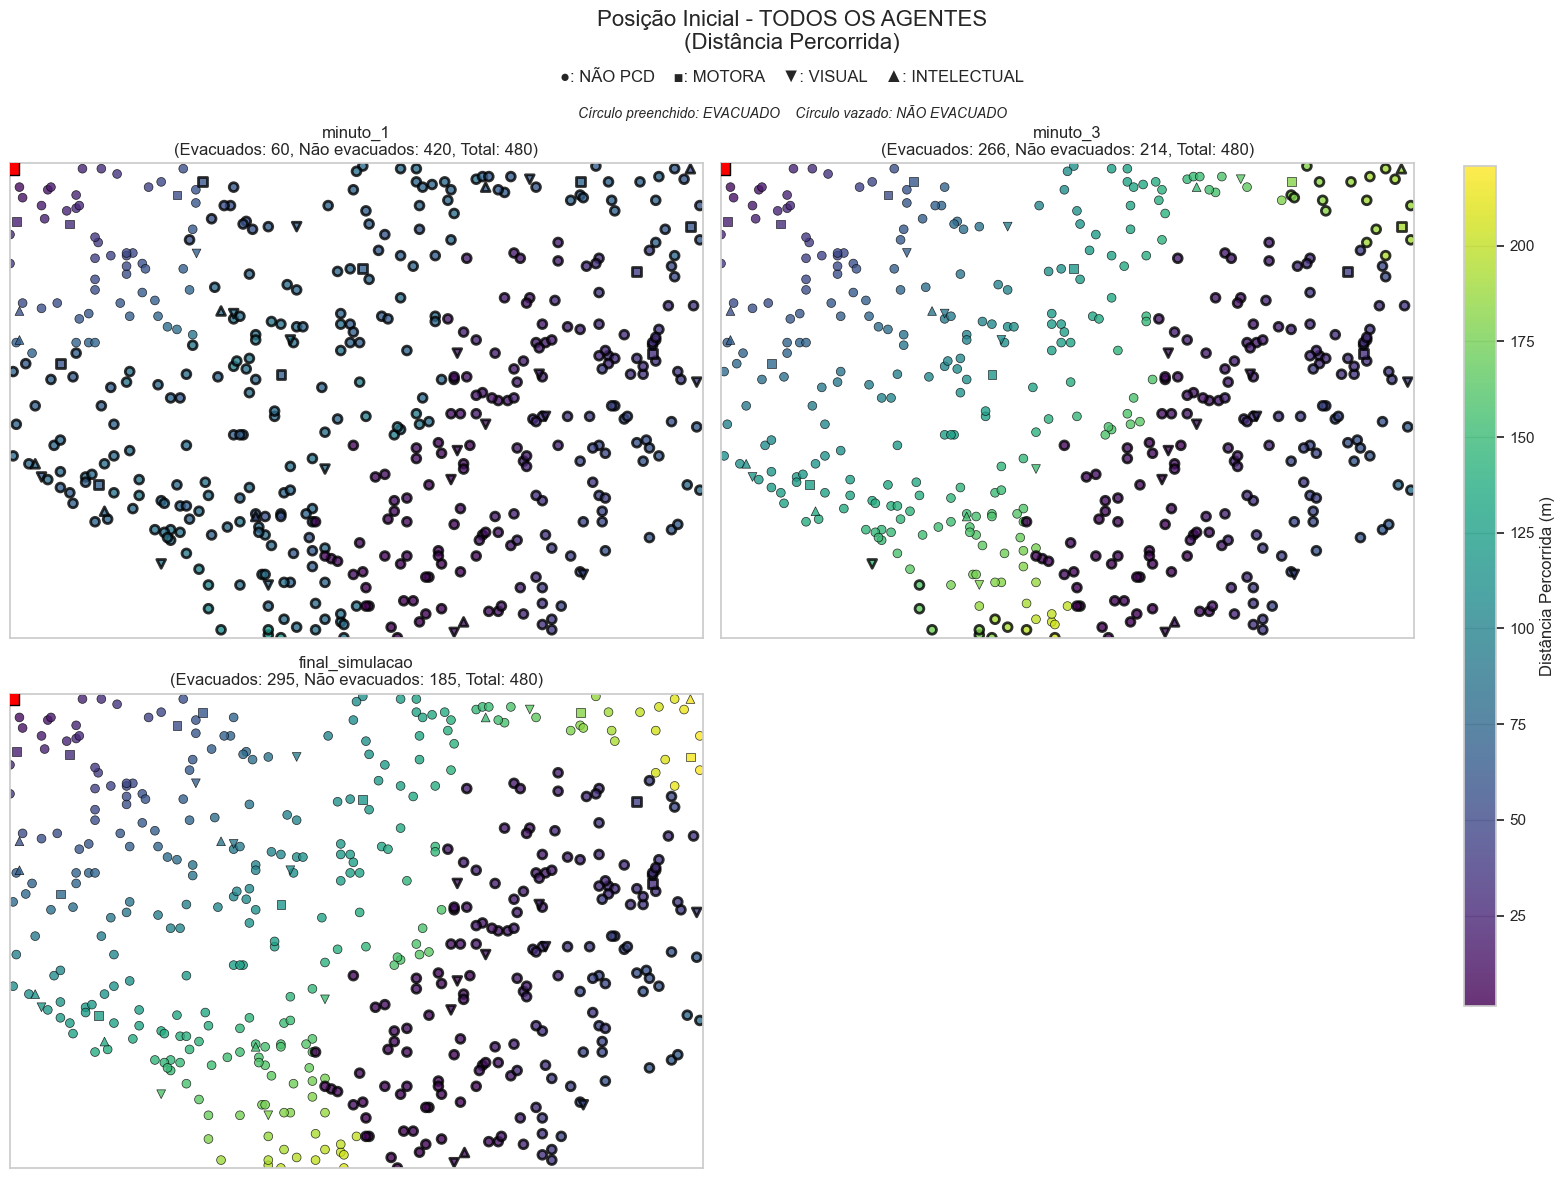

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/561805628.py:172: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/561805628.py:172: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/561805628.py:172: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/

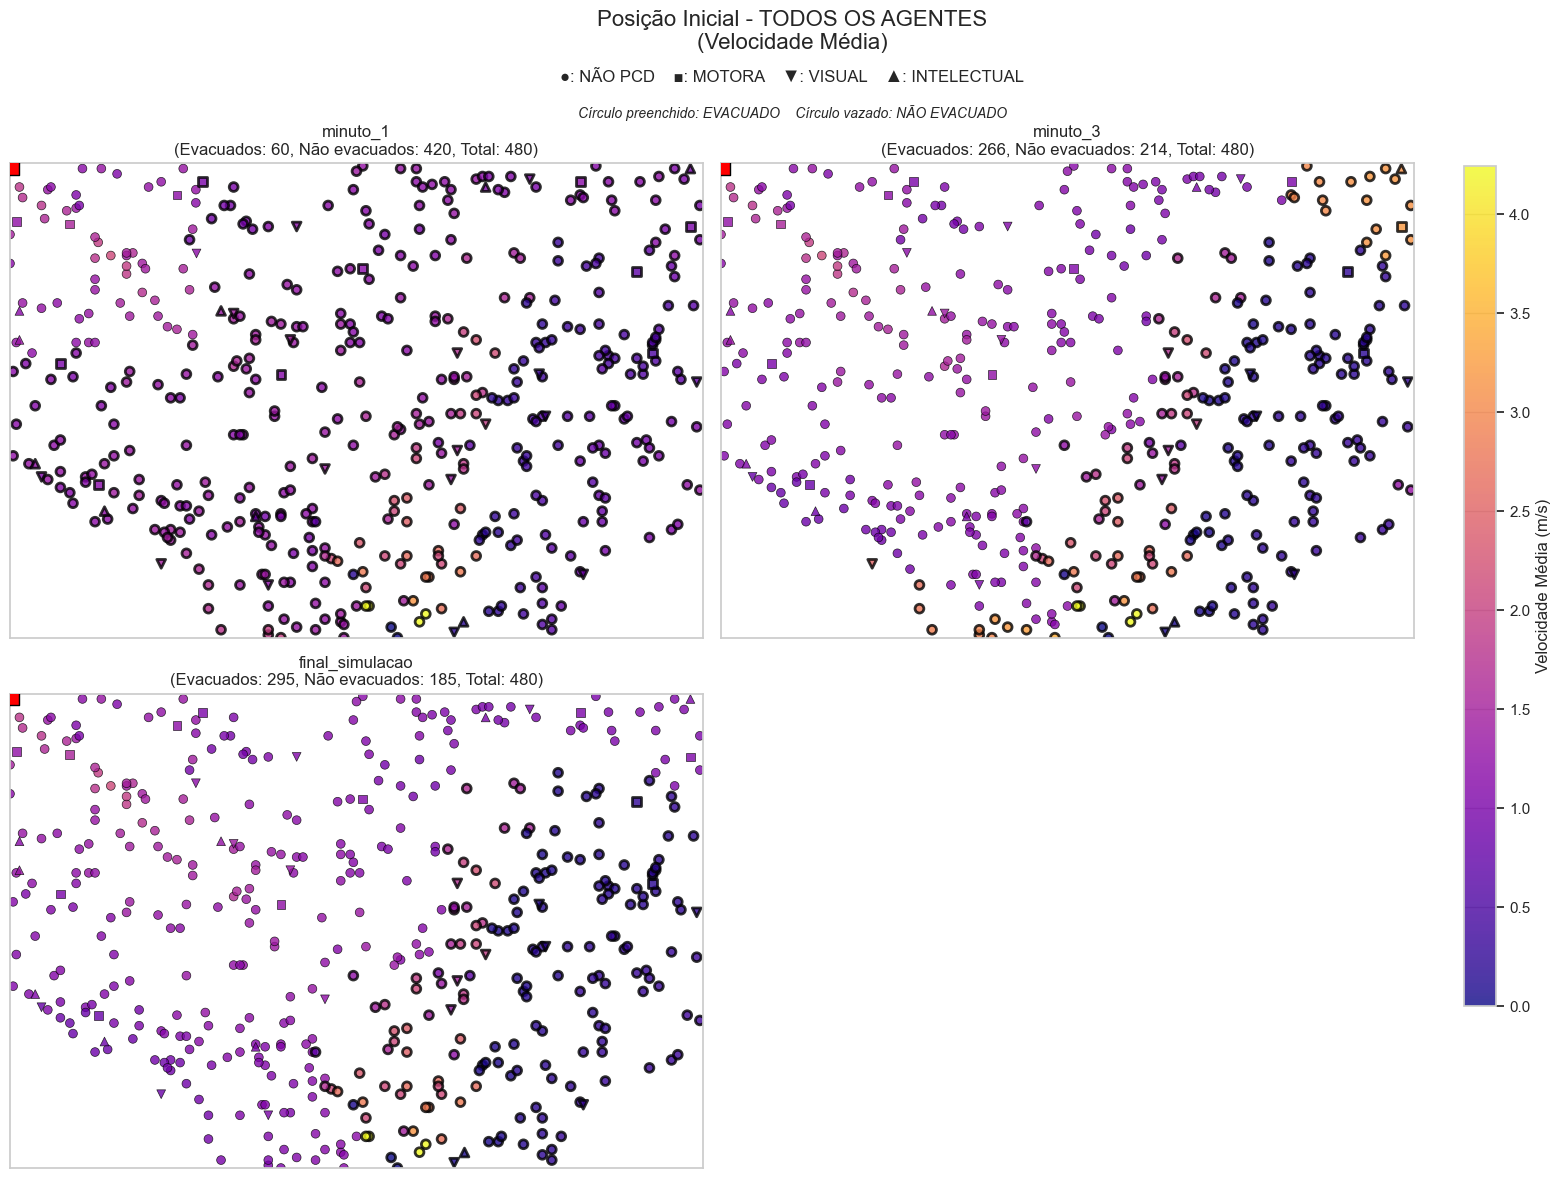


ESTATÍSTICAS COMPLETAS PARA O TCC

MINUTO_1:
  Total de agentes: 480
  Evacuados: 60 (12.5%)
  Não evacuados: 420 (87.5%)

  TODOS OS AGENTES:
    Distância percorrida:
      Média: 53.6m
      Min-Max: 1.4m - 118.8m
    Velocidade média:
      Média: 1.22 m/s
      Min-Max: 0.00 - 4.24 m/s

  AGENTES EVACUADOS:
    Distância média: 49.6m
    Velocidade média: 1.43 m/s
    Tempo médio: 35.6s

  AGENTES NÃO EVACUADOS:
    Distância média: 54.1m
    Velocidade média: 1.19 m/s
    Tempo: 60.0s

  POR TIPO DE MOBILIDADE:
    NON_PWD     : 441 agentes total, evacuação:  12.2%
                 dist:  53.6m, vel: 1.23m/s
    VISUAL      :  18 agentes total, evacuação:   5.6%
                 dist:  50.0m, vel: 1.15m/s
    INTELLECTUAL:   9 agentes total, evacuação:  22.2%
                 dist:  59.8m, vel: 1.05m/s
    MOTOR       :  12 agentes total, evacuação:  25.0%
                 dist:  53.2m, vel: 1.08m/s

MINUTO_3:
  Total de agentes: 480
  Evacuados: 266 (55.4%)
  Não evacuados: 214

In [17]:
# pos inicial - todos os agentes - distancia e velocidade
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0
base_speed = 1.5
time_per_step = step_length / base_speed

base_path = Path("reports/one_risk_area")

# --- Carregar dados ---
latest_files = {}
for folder in report_folders:
    folder_path = base_path / folder
    all_csvs = list(folder_path.glob("*.csv"))
    latest_file = min(all_csvs, key=os.path.getmtime)
    latest_files[folder] = latest_file

dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    dataframes[folder] = df

# --- VISUALIZAÇÃO 1: TODOS OS AGENTES POR DISTÂNCIA PERCORRIDA ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Posição Inicial - TODOS OS AGENTES\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
         ha='center', fontsize=12)
fig.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
         ha='center', fontsize=10, style='italic')

# Encontrar range global de distâncias para todos os agentes
all_distances = []
for folder in report_folders:
    df = dataframes[folder]
    all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin, vmax = min(all_distances), max(all_distances)
else:
    vmin, vmax = 0, 100

sc_for_colorbar = None

# Posições dos plots: [0,0], [0,1], [1,0] e [1,1] será vazio
plot_positions = [(0, 0), (0, 1), (1, 0)]

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    row, col = plot_positions[i]
    ax = axes[row, col]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, facecolors='none', 
                           edgecolors='black', linewidth=2)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Remover o subplot vazio (posição [1,1])
axes[1, 1].remove()

# Colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- VISUALIZAÇÃO 2: TODOS OS AGENTES POR VELOCIDADE MÉDIA ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle("Posição Inicial - TODOS OS AGENTES\n(Velocidade Média)", fontsize=16)
fig2.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
          ha='center', fontsize=12)
fig2.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
          ha='center', fontsize=10, style='italic')

# Range global de velocidades para todos os agentes
all_velocities = []
for folder in report_folders:
    df = dataframes[folder]
    all_velocities.extend(df['velocity_m_s'].tolist())

if all_velocities:
    vmin_vel, vmax_vel = min(all_velocities), max(all_velocities)
else:
    vmin_vel, vmax_vel = 0, 2

sc_for_colorbar2 = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    row, col = plot_positions[i]
    ax = axes2[row, col]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc2 = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, facecolors='none', 
                            edgecolors='black', linewidth=2)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Remover o subplot vazio (posição [1,1])
axes2[1, 1].remove()

# Colorbar
if sc_for_colorbar2:
    cbar_ax2 = fig2.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar2 = fig2.colorbar(sc_for_colorbar2, cax=cbar_ax2, label="Velocidade Média (m/s)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- ESTATÍSTICAS COMPARATIVAS COMPLETAS ---
print("\n" + "="*80)
print("ESTATÍSTICAS COMPLETAS PARA O TCC")
print("="*80)

for folder in report_folders:
    df = dataframes[folder]
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    print(f"\n{folder.upper()}:")
    print(f"  Total de agentes: {len(df)}")
    print(f"  Evacuados: {len(df_evacuated)} ({len(df_evacuated)/len(df)*100:.1f}%)")
    print(f"  Não evacuados: {len(df_not_evacuated)} ({len(df_not_evacuated)/len(df)*100:.1f}%)")
    
    if len(df) > 0:
        print(f"\n  TODOS OS AGENTES:")
        print(f"    Distância percorrida:")
        print(f"      Média: {df['distance_m'].mean():.1f}m")
        print(f"      Min-Max: {df['distance_m'].min():.1f}m - {df['distance_m'].max():.1f}m")
        print(f"    Velocidade média:")
        print(f"      Média: {df['velocity_m_s'].mean():.2f} m/s")
        print(f"      Min-Max: {df['velocity_m_s'].min():.2f} - {df['velocity_m_s'].max():.2f} m/s")
        
        # Análise por status de evacuação
        if len(df_evacuated) > 0:
            print(f"\n  AGENTES EVACUADOS:")
            print(f"    Distância média: {df_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo médio: {df_evacuated['time_s'].mean():.1f}s")
        
        if len(df_not_evacuated) > 0:
            print(f"\n  AGENTES NÃO EVACUADOS:")
            print(f"    Distância média: {df_not_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_not_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo: {df_not_evacuated['time_s'].iloc[0]:.1f}s")
        
        # Análise por tipo de mobilidade
        print(f"\n  POR TIPO DE MOBILIDADE:")
        for mob_type in df['mobility_type'].unique():
            subset = df[df['mobility_type'] == mob_type]
            evacuated_subset = subset[subset['evacuated'] == True]
            not_evacuated_subset = subset[subset['evacuated'] == False]
            
            evacuation_rate = len(evacuated_subset) / len(subset) * 100 if len(subset) > 0 else 0
            avg_dist = subset['distance_m'].mean()
            avg_vel = subset['velocity_m_s'].mean()
            
            print(f"    {mob_type:12}: {len(subset):3} agentes total, "
                  f"evacuação: {evacuation_rate:5.1f}%")
            print(f"                 dist: {avg_dist:5.1f}m, vel: {avg_vel:.2f}m/s")

print("\n" + "="*80)
print("RESUMO COMPARATIVO ENTRE TEMPOS:")
print("="*80)

# Comparação de taxa de evacuação entre os tempos
evacuation_rates = {}
for folder in report_folders:
    df = dataframes[folder]
    rate = len(df[df['evacuated'] == True]) / len(df) * 100 if len(df) > 0 else 0
    evacuation_rates[folder] = rate

print("\nTaxas de Evacuação:")
for folder, rate in evacuation_rates.items():
    print(f"  {folder:15}: {rate:5.1f}%")

# Comparação de desempenho médio
print("\nDesempenho Médio (Todos os Agentes):")
for folder in report_folders:
    df = dataframes[folder]
    if len(df) > 0:
        avg_dist = df['distance_m'].mean()
        avg_vel = df['velocity_m_s'].mean()
        print(f"  {folder:15}: dist={avg_dist:5.1f}m, vel={avg_vel:.2f}m/s")

minuto_1: minute_1_report_20250601-200230.csv
minuto_3: minute_3_report_20250601-201155.csv
final_simulacao: all_done_report_20250601-201155.csv

=== minuto_1 ===
Agentes não evacuados: 420
Distância percorrida - min: 1.4m, max: 118.8m
Velocidade média - min: 0.00m/s, max: 4.24m/s

=== minuto_3 ===
Agentes não evacuados: 214
Distância percorrida - min: 1.4m, max: 207.2m
Velocidade média - min: 0.00m/s, max: 4.24m/s

=== final_simulacao ===
Agentes não evacuados: 185
Distância percorrida - min: 1.4m, max: 79.3m
Velocidade média - min: 0.00m/s, max: 4.24m/s


/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2574041844.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


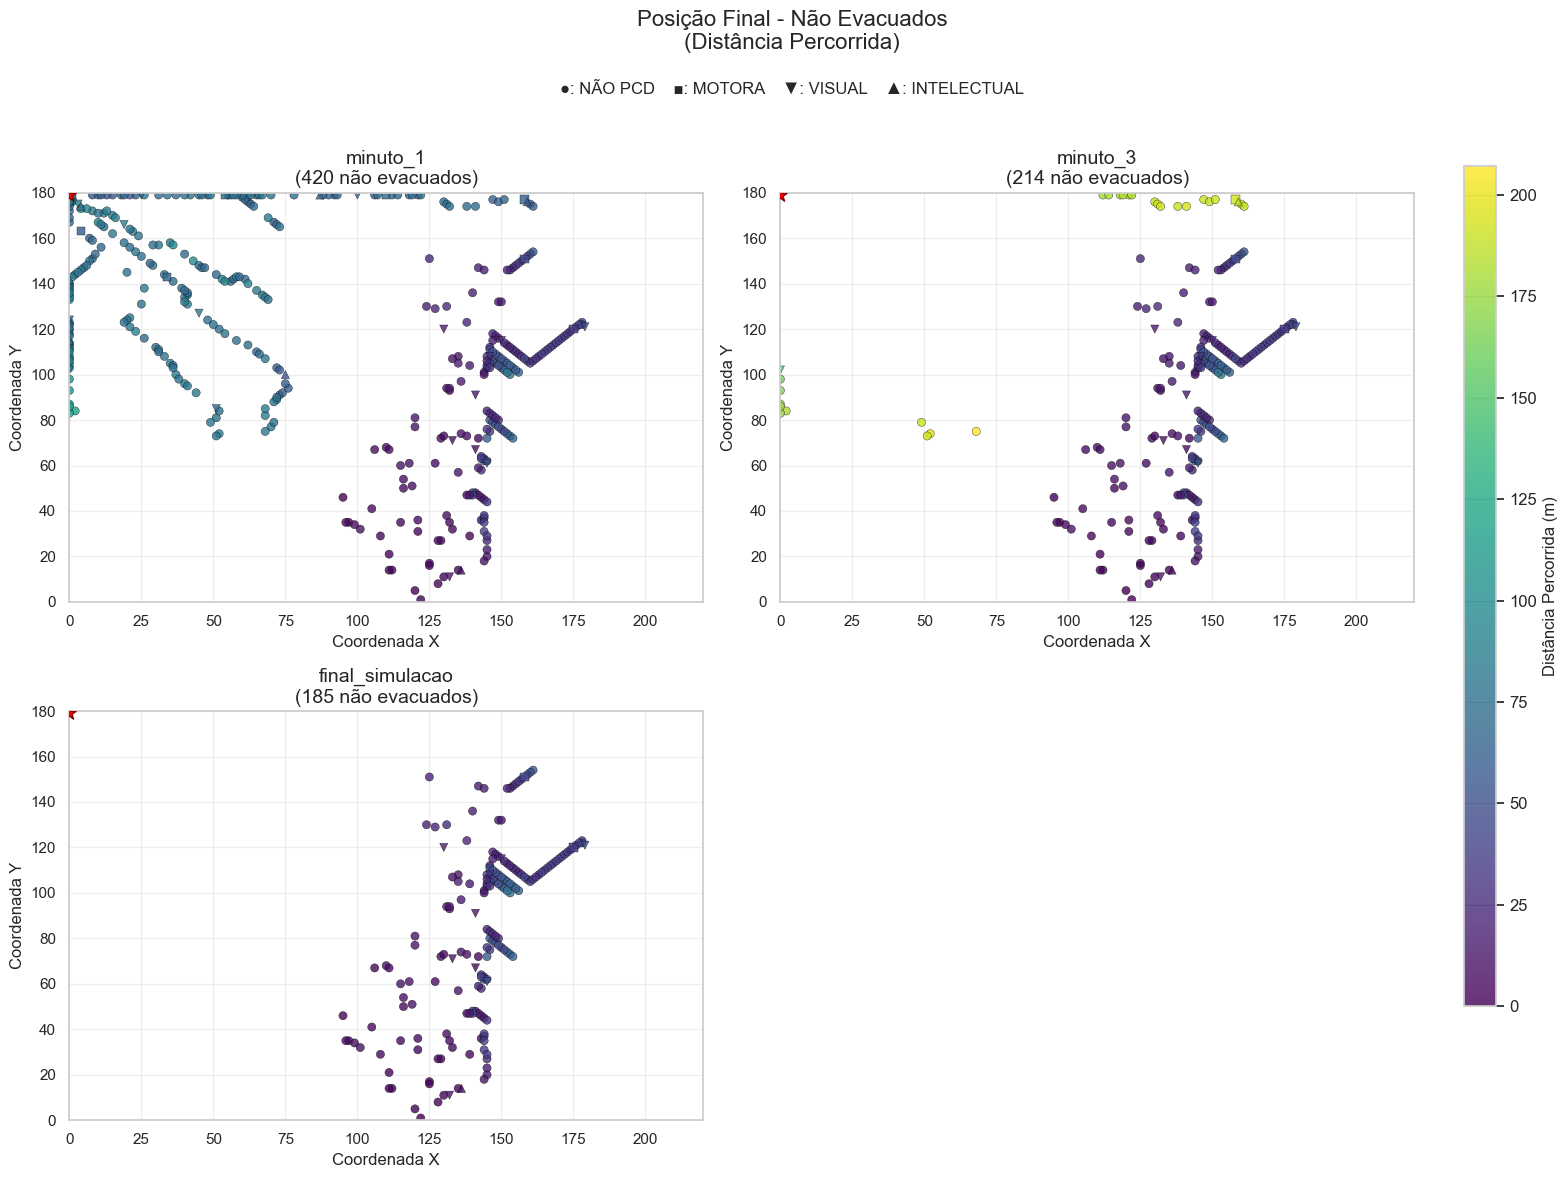


ANÁLISE ESTATÍSTICA DETALHADA

minuto_1:
  Agentes não evacuados: 420
  Distância percorrida (m):
    Min: 1.4m
    Max: 118.8m
    Média: 54.1m
    Mediana: 64.2m
    Q1 (25%): 27.0m
    Q3 (75%): 77.0m
  Agentes com baixa mobilidade (≤27.0m): 105 (25.0%)
  Agentes com alta mobilidade (≥77.0m): 105 (25.0%)
  Por tipo de mobilidade:
    INTELLECTUAL: 7 agentes
      Distância média: 59.6m (mediana: 64.5m)
      Velocidade média: 0.99m/s
    MOTOR: 9 agentes
      Distância média: 59.3m (mediana: 61.7m)
      Velocidade média: 0.99m/s
    NON_PWD: 387 agentes
      Distância média: 54.1m (mediana: 64.2m)
      Velocidade média: 1.20m/s
    VISUAL: 17 agentes
      Distância média: 48.9m (mediana: 52.3m)
      Velocidade média: 1.15m/s
  Regiões com agentes de baixa mobilidade:
    Região (140-160, 100-120): 16 agentes
    Região (120-140, 0-20): 9 agentes
    Região (120-140, 20-40): 8 agentes

minuto_3:
  Agentes não evacuados: 214
  Distância percorrida (m):
    Min: 1.4m
    Max: 20

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2574041844.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2574041844.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2574041844.py:187: SettingWithCopyWarning: 
A 

In [18]:
# pos final - nao evacuados
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

base_path = Path("reports/one_risk_area")

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Filtrar apenas não evacuados
    df = df[df["evacuated"] != True].copy()
    
    if df.empty:
        dataframes[folder] = df
        print(f"\n=== {folder} ===")
        print("Todos os agentes foram evacuados!")
        continue
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    # Extrair coordenadas x, y da posição final
    df[['x', 'y']] = df['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Agentes não evacuados: {len(df)}")
    print(f"Distância percorrida - min: {df['distance_m'].min():.1f}m, max: {df['distance_m'].max():.1f}m")
    print(f"Velocidade média - min: {df['velocity_m_s'].min():.2f}m/s, max: {df['velocity_m_s'].max():.2f}m/s")

# --- Step 3: Plotar com DISTÂNCIA como variável de cor ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Determinar o range global para distância
all_distances = []
for df in dataframes.values():
    if not df.empty:
        all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin_dist, vmax_dist = 0, max(all_distances)
else:
    vmin_dist, vmax_dist = 0, 100

# Criar gráfico
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Posição Final - Não Evacuados\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.91, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

sc_for_colorbar = None

# Posições dos plots: [0,0], [0,1], [1,0] e [1,1] será vazio
plot_positions = [(0, 0), (0, 1), (1, 0)]

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    row, col = plot_positions[i]
    ax = axes[row, col]

    if df.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, weight='bold')
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder, fontsize=14)
        continue
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = df[df["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=35, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, edgecolors='black', linewidth=0.3)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=12)
    ax.set_ylabel('Coordenada Y', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{folder}\n({len(df)} não evacuados)", fontsize=14)

# Remover o subplot vazio (posição [1,1])
axes[1, 1].remove()

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()

# --- Análise estatística aprimorada ---
print("\n" + "="*70)
print("ANÁLISE ESTATÍSTICA DETALHADA")
print("="*70)

for folder in report_folders:
    df = dataframes[folder]
    
    if df.empty:
        print(f"\n{folder}: Todos evacuados!")
        continue
        
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df)}")
    print(f"  Distância percorrida (m):")
    print(f"    Min: {df['distance_m'].min():.1f}m")
    print(f"    Max: {df['distance_m'].max():.1f}m")
    print(f"    Média: {df['distance_m'].mean():.1f}m")
    print(f"    Mediana: {df['distance_m'].median():.1f}m")
    
    # Análise por quartis de distância
    q1 = df['distance_m'].quantile(0.25)
    q3 = df['distance_m'].quantile(0.75)
    print(f"    Q1 (25%): {q1:.1f}m")
    print(f"    Q3 (75%): {q3:.1f}m")
    
    # Identificar agentes com baixa mobilidade
    low_mobility = df[df['distance_m'] <= q1]
    high_mobility = df[df['distance_m'] >= q3]
    
    print(f"  Agentes com baixa mobilidade (≤{q1:.1f}m): {len(low_mobility)} ({len(low_mobility)/len(df)*100:.1f}%)")
    print(f"  Agentes com alta mobilidade (≥{q3:.1f}m): {len(high_mobility)} ({len(high_mobility)/len(df)*100:.1f}%)")
    
    # Análise por tipo de mobilidade
    print(f"  Por tipo de mobilidade:")
    mobility_stats = df.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median', 'std'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        median_dist = mobility_stats.loc[mob_type, ('distance_m', 'median')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        print(f"    {mob_type}: {count} agentes")
        print(f"      Distância média: {mean_dist:.1f}m (mediana: {median_dist:.1f}m)")
        print(f"      Velocidade média: {mean_vel:.2f}m/s")
    
    # Análise espacial - onde estão os agentes com menor mobilidade
    if len(low_mobility) > 0:
        print(f"  Regiões com agentes de baixa mobilidade:")
        # Agrupar por regiões aproximadas
        low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
        low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
        
        regions = low_mobility.groupby(['region_x', 'region_y']).size().sort_values(ascending=False)
        for (x, y), count in regions.head(3).items():
            print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {count} agentes")

print("\n" + "="*70)
print("INTERPRETAÇÃO PARA SEU TCC:")
print("="*70)
print("1. A coloração por DISTÂNCIA revela padrões espaciais importantes")
print("2. Agentes com cores mais escuras (menor distância) podem indicar:")
print("   - Obstáculos locais que impedem movimento")
print("   - Gargalos de evacuação")
print("   - Problemas de pathfinding")
print("3. A uniformidade temporal confirma que o fator crítico é ESPACIAL, não temporal")
print("4. Diferentes tipos de mobilidade mostram padrões distintos de movimento")

minuto_1: minute_1_report_20250601-200230.csv
final_simulacao: all_done_report_20250601-201155.csv

=== minuto_1 ===
Agentes não evacuados: 420
Distância percorrida - min: 1.4m, max: 118.8m
Velocidade média - min: 0.00m/s, max: 4.24m/s

=== final_simulacao ===
Agentes não evacuados: 185
Distância percorrida - min: 1.4m, max: 79.3m
Velocidade média - min: 0.00m/s, max: 4.24m/s


/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736457172.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


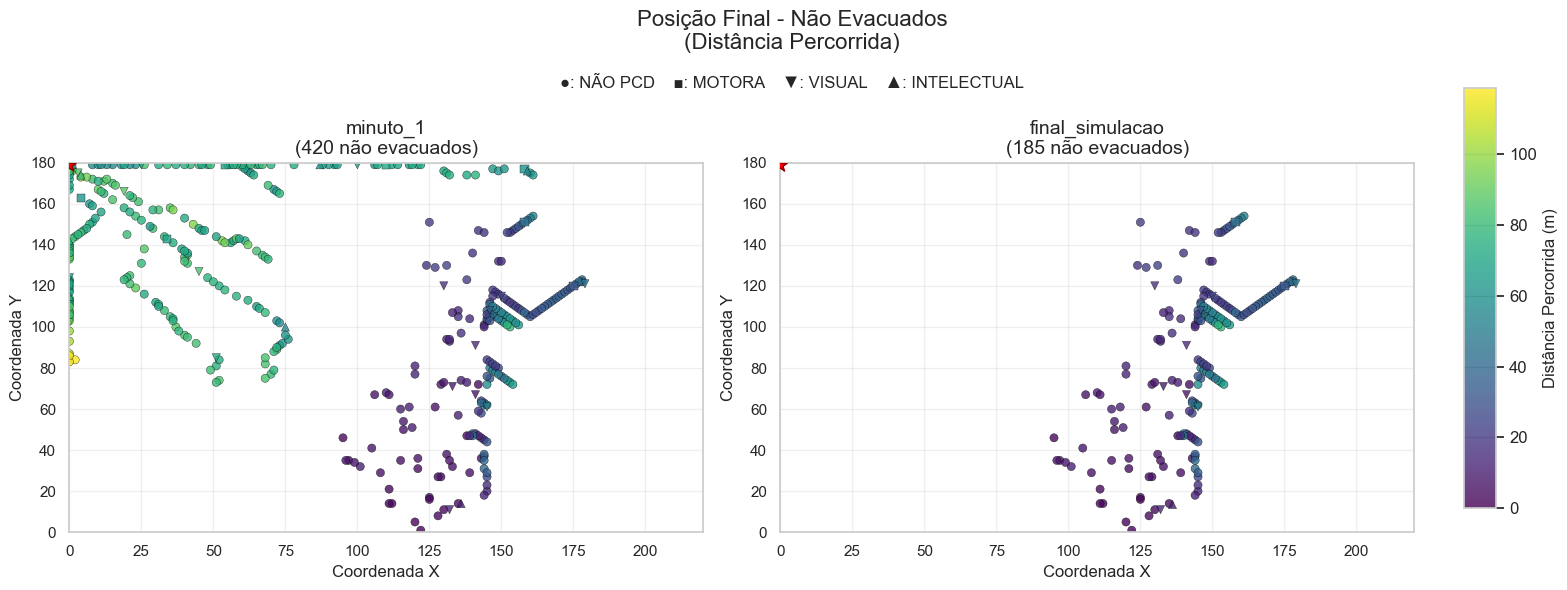


ANÁLISE ESTATÍSTICA DETALHADA

minuto_1:
  Agentes não evacuados: 420
  Distância percorrida (m):
    Min: 1.4m
    Max: 118.8m
    Média: 54.1m
    Mediana: 64.2m
    Q1 (25%): 27.0m
    Q3 (75%): 77.0m
  Agentes com baixa mobilidade (≤27.0m): 105 (25.0%)
  Agentes com alta mobilidade (≥77.0m): 105 (25.0%)
  Por tipo de mobilidade:
    INTELLECTUAL: 7 agentes
      Distância média: 59.6m (mediana: 64.5m)
      Velocidade média: 0.99m/s
    MOTOR: 9 agentes
      Distância média: 59.3m (mediana: 61.7m)
      Velocidade média: 0.99m/s
    NON_PWD: 387 agentes
      Distância média: 54.1m (mediana: 64.2m)
      Velocidade média: 1.20m/s
    VISUAL: 17 agentes
      Distância média: 48.9m (mediana: 52.3m)
      Velocidade média: 1.15m/s
  Regiões com agentes de baixa mobilidade:
    Região (140-160, 100-120): 16 agentes
    Região (120-140, 0-20): 9 agentes
    Região (120-140, 20-40): 8 agentes

final_simulacao:
  Agentes não evacuados: 185
  Distância percorrida (m):
    Min: 1.4m
    

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736457172.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736457172.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736457172.py:187: SettingWithCopyWarning: 
A 

In [109]:
# pos final - nao evacuados - dois plots
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0                # metros por movimento/step
base_speed = 1.5                 # m/s
time_per_step = step_length / base_speed    # segundos por step de simulação

report_folders = ["minuto_1","final_simulacao"]
base_path = Path("reports/one_risk_area")

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Filtrar apenas não evacuados
    df = df[df["evacuated"] != True].copy()
    
    if df.empty:
        dataframes[folder] = df
        print(f"\n=== {folder} ===")
        print("Todos os agentes foram evacuados!")
        continue
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    # Extrair coordenadas x, y da posição final
    df[['x', 'y']] = df['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Agentes não evacuados: {len(df)}")
    print(f"Distância percorrida - min: {df['distance_m'].min():.1f}m, max: {df['distance_m'].max():.1f}m")
    print(f"Velocidade média - min: {df['velocity_m_s'].min():.2f}m/s, max: {df['velocity_m_s'].max():.2f}m/s")

# --- Step 3: Plotar com DISTÂNCIA como variável de cor ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Determinar o range global para distância
all_distances = []
for df in dataframes.values():
    if not df.empty:
        all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin_dist, vmax_dist = 0, max(all_distances)
else:
    vmin_dist, vmax_dist = 0, 100

# Criar gráfico
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Posição Final - Não Evacuados\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.85, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    ax = axes[i]

    if df.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, weight='bold')
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder, fontsize=14)
        continue
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = df[df["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=35, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, edgecolors='black', linewidth=0.3)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=12)
    ax.set_ylabel('Coordenada Y', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{folder}\n({len(df)} não evacuados)", fontsize=14)

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()

# --- Análise estatística aprimorada ---
print("\n" + "="*70)
print("ANÁLISE ESTATÍSTICA DETALHADA")
print("="*70)

for folder in report_folders:
    df = dataframes[folder]
    
    if df.empty:
        print(f"\n{folder}: Todos evacuados!")
        continue
        
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df)}")
    print(f"  Distância percorrida (m):")
    print(f"    Min: {df['distance_m'].min():.1f}m")
    print(f"    Max: {df['distance_m'].max():.1f}m")
    print(f"    Média: {df['distance_m'].mean():.1f}m")
    print(f"    Mediana: {df['distance_m'].median():.1f}m")
    
    # Análise por quartis de distância
    q1 = df['distance_m'].quantile(0.25)
    q3 = df['distance_m'].quantile(0.75)
    print(f"    Q1 (25%): {q1:.1f}m")
    print(f"    Q3 (75%): {q3:.1f}m")
    
    # Identificar agentes com baixa mobilidade
    low_mobility = df[df['distance_m'] <= q1]
    high_mobility = df[df['distance_m'] >= q3]
    
    print(f"  Agentes com baixa mobilidade (≤{q1:.1f}m): {len(low_mobility)} ({len(low_mobility)/len(df)*100:.1f}%)")
    print(f"  Agentes com alta mobilidade (≥{q3:.1f}m): {len(high_mobility)} ({len(high_mobility)/len(df)*100:.1f}%)")
    
    # Análise por tipo de mobilidade
    print(f"  Por tipo de mobilidade:")
    mobility_stats = df.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median', 'std'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        median_dist = mobility_stats.loc[mob_type, ('distance_m', 'median')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        print(f"    {mob_type}: {count} agentes")
        print(f"      Distância média: {mean_dist:.1f}m (mediana: {median_dist:.1f}m)")
        print(f"      Velocidade média: {mean_vel:.2f}m/s")
    
    # Análise espacial - onde estão os agentes com menor mobilidade
    if len(low_mobility) > 0:
        print(f"  Regiões com agentes de baixa mobilidade:")
        # Agrupar por regiões aproximadas
        low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
        low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
        
        regions = low_mobility.groupby(['region_x', 'region_y']).size().sort_values(ascending=False)
        for (x, y), count in regions.head(3).items():
            print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {count} agentes")

print("\n" + "="*70)
print("INTERPRETAÇÃO PARA SEU TCC:")
print("="*70)
print("1. A coloração por DISTÂNCIA revela padrões espaciais importantes")
print("2. Agentes com cores mais escuras (menor distância) podem indicar:")
print("   - Obstáculos locais que impedem movimento")
print("   - Gargalos de evacuação")
print("   - Problemas de pathfinding")
print("3. A uniformidade temporal confirma que o fator crítico é ESPACIAL, não temporal")
print("4. Diferentes tipos de mobilidade mostram padrões distintos de movimento")

In [260]:
summary_time_related = df_one_risk_area_all_done.groupby('mobility_type').agg({
    'time_s':       'mean',
    'distance_m':   'mean',
    'steps':        'mean',
    'velocity_m_s': 'mean',
    'agent_id':     'count'
}).rename(columns={'agent_id':'count_agents'})

In [261]:
summary_time_related

time_s  distance_m      steps  velocity_m_s  count_agents
mobility_type                                                               
INTELLECTUAL   205.761938   81.940670  74.545646      0.516451          1424
MOTOR          212.392210   80.024600  72.550000      0.483597          1380
NON_PWD        205.185127   83.470763  75.758145      0.534833         43828
VISUAL         218.345212   83.352402  75.831871      0.478382          1368

In [262]:
total_agents = len(df_one_risk_area_all_done)
evacuated_count = df_one_risk_area_all_done['evacuated'].sum()
not_evacuated_count = total_agents - evacuated_count
impacted_count = df_one_risk_area_all_done['impacted_by_landslide'].sum()
not_impacted_count = total_agents - impacted_count

In [263]:
summary_evacuation = pd.DataFrame({
    'metric': [
        'total_agents',
        'evacuated',
        'not_evacuated',
        'impacted_by_landslide',
        'not_impacted_by_landslide'
    ],
    'count': [
        total_agents,
        evacuated_count,
        not_evacuated_count,
        impacted_count,
        not_impacted_count
    ]
})

In [264]:
summary_evacuation

metric  count
0               total_agents  48000
1                  evacuated  29151
2              not_evacuated  18849
3      impacted_by_landslide   6312
4  not_impacted_by_landslide  41688

## All risk areas

In [194]:
df_all_risk_areas_all_done = load_report_data("final_simulacao", step_length, time_per_step)

In [192]:
report_folders = ["minuto_1", "minuto_3", "final_simulacao"]

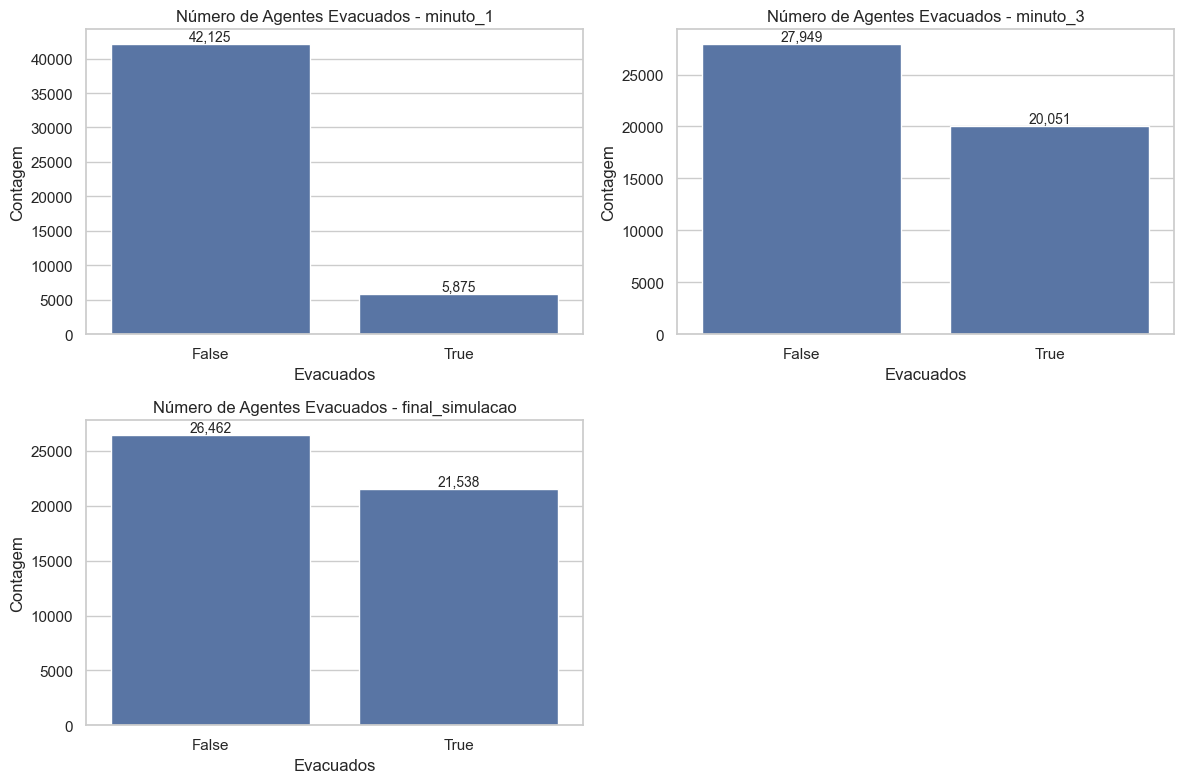

In [282]:
# status de evacuação ao longo da simulação
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    sns.countplot(data=df, x='evacuated', order=[False, True], ax=ax)

    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f"{count:,}", 
                    (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='bottom', fontsize=10)

    ax.set(title=f"Número de Agentes Evacuados - {folder}", xlabel="Evacuados", ylabel="Contagem")

# Hide any unused subplot axes
for j in range(len(report_folders), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
fig.savefig(download_dir / "grid_evacuated_count_LINEAR.png")
plt.show()
plt.close(fig)


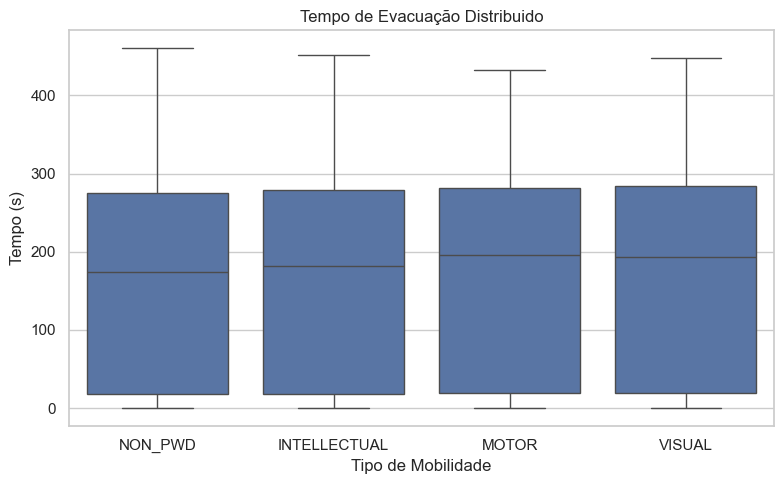

In [283]:
# Evacuation Time Distribution (boxplot) ** final da simulação
fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(data=df_one_risk_area_all_done, x='mobility_type', y='time_s', ax=ax)
ax.set(title="Tempo de Evacuação Distribuido", xlabel="Tipo de Mobilidade", ylabel="Tempo (s)")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "boxplot_time.png")
plt.close(fig)

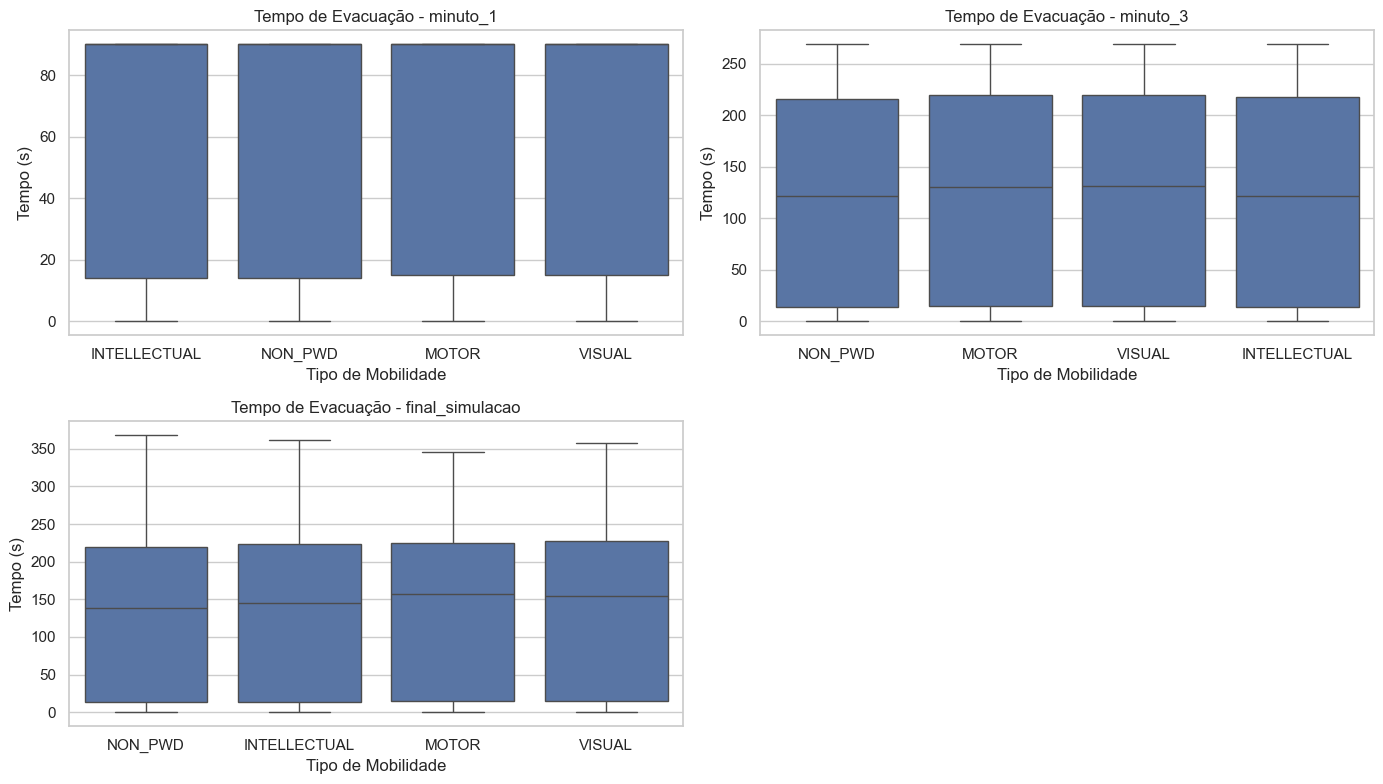

In [284]:
# boxplot ao longo da simulação
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'mobility_type' in df.columns and 'time_s' in df.columns and not df.empty:
        sns.boxplot(data=df, x='mobility_type', y='time_s', ax=ax)
        ax.set(title=f"Tempo de Evacuação - {folder}", xlabel="Tipo de Mobilidade", ylabel="Tempo (s)")
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set(title=f"Tempo de Evacuação - {folder}")

for j in range(len(report_folders), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
fig.savefig(download_dir / "grid_boxplot_time.png")
plt.show()
plt.close(fig)


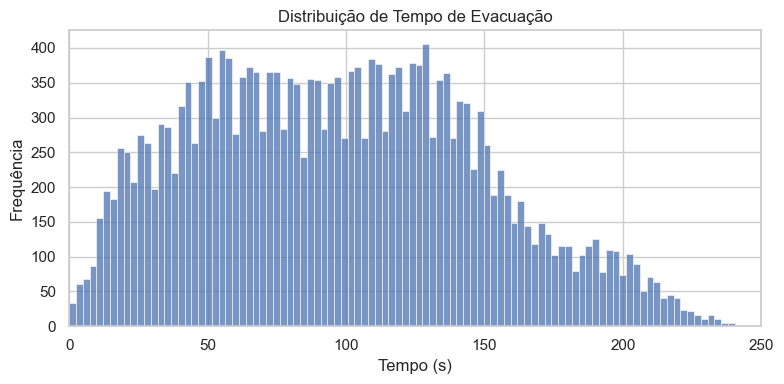

In [188]:
# Distribution of Evacuation Time (histograma)
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(df[df["evacuated"] == True], x="time_s", bins=100)
plt.xlim(0, 250)
ax.set(title="Distribuição de Tempo de Evacuação", xlabel="Tempo (s)", ylabel="Frequência")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "hist_time.png")
plt.close(fig)

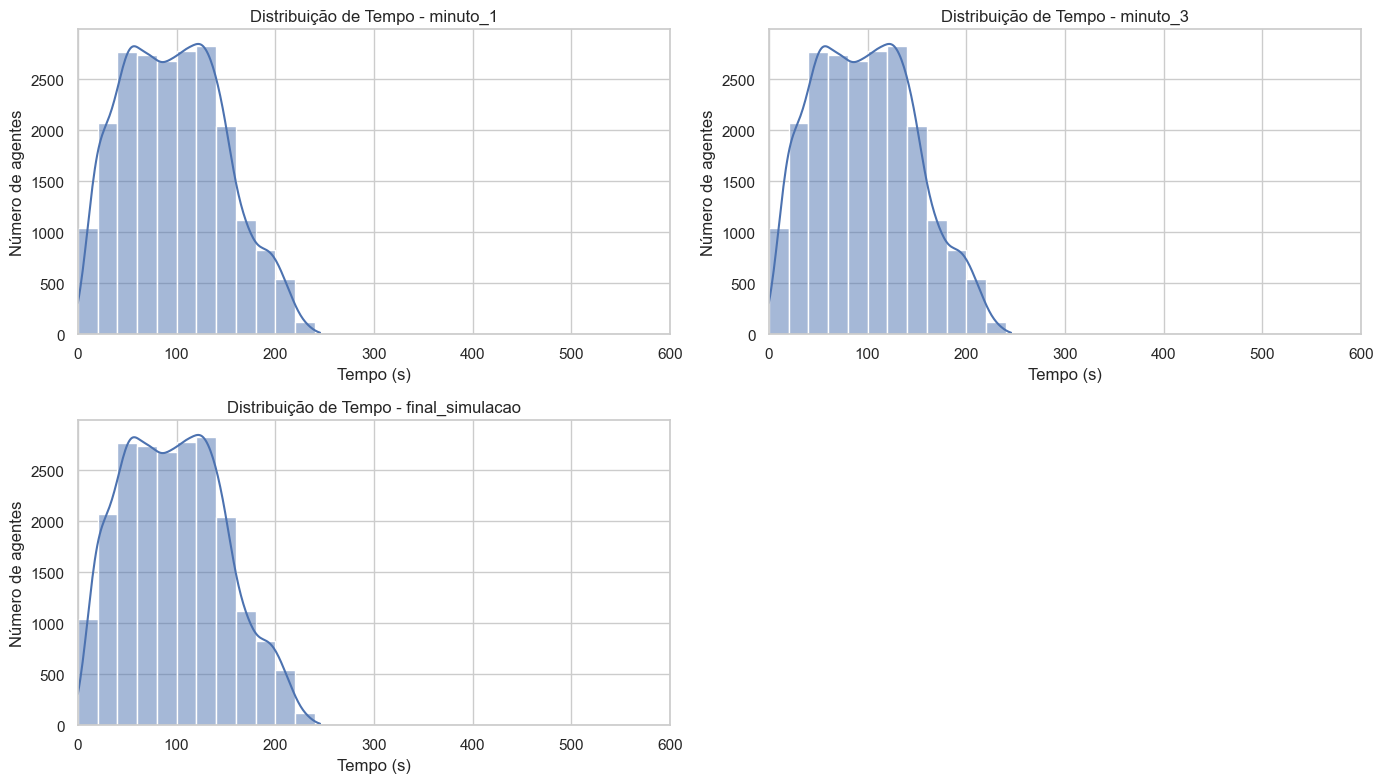

In [197]:
# distribuição do tempo de movimento
# X-axis (time_s) = how long agents took to evacuate
# Y-axis (frequência) = how many agents had that evacuation time (binned)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'time_s' in df.columns and not df['time_s'].dropna().empty:
        sns.histplot(data=df_evacuated, x='time_s', bins=30, binrange=(0,600), kde=True, ax=ax)
        ax.set_xlim(0, 600)
        ax.set(title=f"Distribuição de Tempo - {folder}", xlabel="Tempo (s)", ylabel="Número de agentes")
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set(title=f"Distribuição de Tempo - {folder}")

axes[3].remove()

fig.tight_layout()
fig.savefig(download_dir / "grid_hist_time.png")
plt.show()
plt.close(fig)

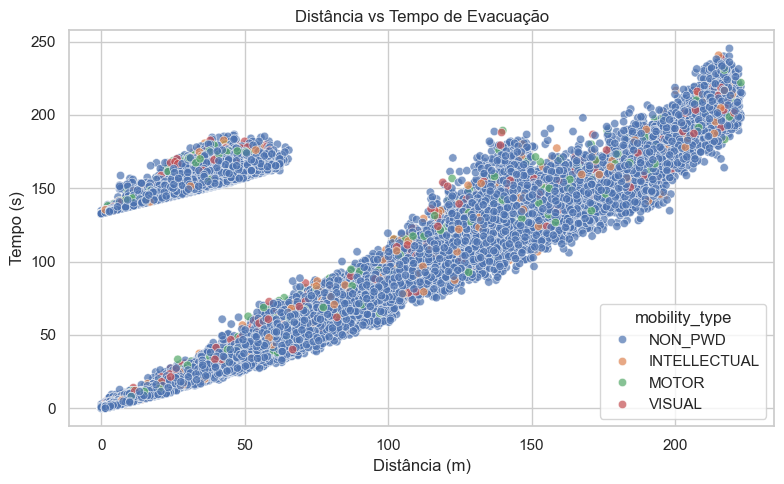

In [60]:
# Distance vs. Time (scatter)
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=df_all_risk_areas_all_done, x='distance_m', y='time_s', hue='mobility_type', alpha=0.7, ax=ax)
ax.set(title="Distância vs Tempo de Evacuação", xlabel="Distância (m)", ylabel="Tempo (s)")
fig.tight_layout()
plt.show()
fig.savefig(download_dir / "scatter_dist_vs_time.png")
plt.close(fig)

Agentes com Baixa Eficiência (dist < 75m e tempo > 100s): 12862
Percentual do total: 26.8%


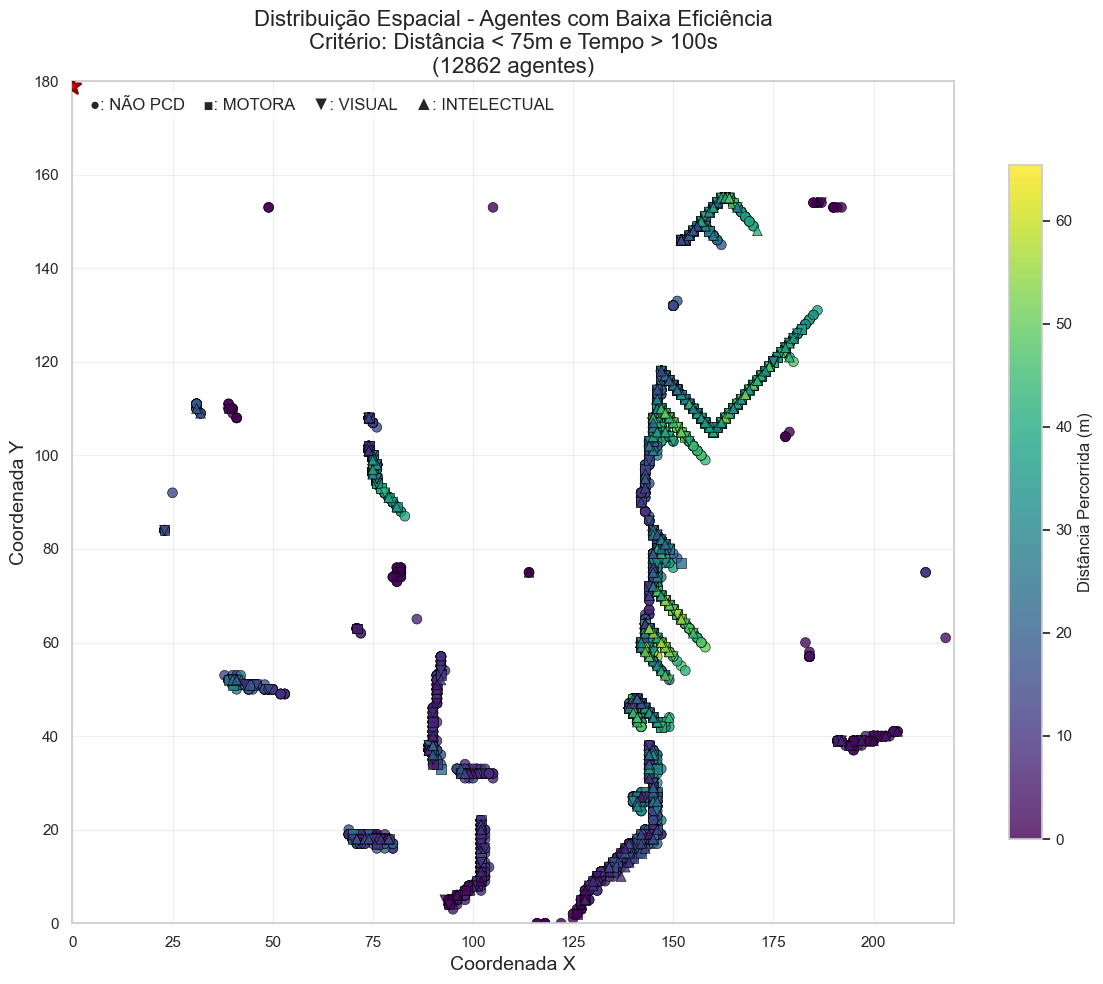


ANÁLISE ESTATÍSTICA DOS AGENTES INEFICIENTES

Resumo Geral:
  Total de agentes ineficientes: 12862
  Distância percorrida:
    Min: 0.0m
    Max: 65.4m
    Média: 28.6m
    Mediana: 28.3m
  Tempo gasto:
    Min: 132.7s
    Max: 186.7s
    Média: 152.9s
    Mediana: 151.3s
  Velocidade média:
    Min: 0.000m/s
    Max: 0.384m/s
    Média: 0.182m/s

Por tipo de mobilidade:
  INTELLECTUAL: 385 agentes (3.0%)
    Distância média: 28.4m
    Tempo médio: 154.4s
    Velocidade média: 0.180m/s
  MOTOR: 378 agentes (2.9%)
    Distância média: 27.7m
    Tempo médio: 154.8s
    Velocidade média: 0.170m/s
  NON_PWD: 11706 agentes (91.0%)
    Distância média: 28.7m
    Tempo médio: 152.7s
    Velocidade média: 0.180m/s
  VISUAL: 393 agentes (3.1%)
    Distância média: 28.1m
    Tempo médio: 155.1s
    Velocidade média: 0.180m/s

Análise Espacial - Regiões com maior concentração:
  Top 5 regiões com mais agentes ineficientes:
    Região (140-160, 100-120): 2613.0 agentes
      Dist. média: 34.2m, T

In [70]:
# filtrar scatter
# Análise Espacial - Agentes com Alta Ineficiência (Baixa Distância + Alto Tempo)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Filtrar agentes com alta ineficiência ---
# Critério: distância < 75m E tempo > 100s
inefficient_agents = df_all_risk_areas_all_done[
    (df_all_risk_areas_all_done['distance_m'] < 75) & 
    (df_all_risk_areas_all_done['time_s'] > 100)
].copy()

print(f"Agentes com Baixa Eficiência (dist < 75m e tempo > 100s): {len(inefficient_agents)}")
print(f"Percentual do total: {len(inefficient_agents)/len(df_all_risk_areas_all_done)*100:.1f}%")

if inefficient_agents.empty:
    print("Nenhum agente encontrado com os critérios especificados!")
else:
    # Extrair coordenadas x, y da posição final
    inefficient_agents[['x', 'y']] = inefficient_agents['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # --- Configurações do plot ---
    mobility_markers = {
        "NON_PWD": "o", 
        "MOTOR": "s", 
        "VISUAL": "v", 
        "INTELLECTUAL": "^"
    }
    
    # Determinar range para distância (para coloração)
    vmin_dist = inefficient_agents['distance_m'].min()
    vmax_dist = inefficient_agents['distance_m'].max()
    
    # --- Criar gráfico ---
    fig, ax = plt.subplots(figsize=(12, 10))
    
    sc_for_colorbar = None
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = inefficient_agents[inefficient_agents["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=50, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, 
                           edgecolors='black', linewidth=0.5)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc
    
    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=150, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=2)
    
    # Configurações do plot
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=14)
    ax.set_ylabel('Coordenada Y', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Distribuição Espacial - Agentes com Baixa Eficiência\n" +
                f"Critério: Distância < 75m e Tempo > 100s\n" +
                f"({len(inefficient_agents)} agentes)", fontsize=16)
    
    # Legenda dos marcadores
    ax.text(0.02, 0.98, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Adicionar colorbar
    if sc_for_colorbar:
        cbar = plt.colorbar(sc_for_colorbar, ax=ax, shrink=0.8)
        cbar.set_label("Distância Percorrida (m)", fontsize=12)
        cbar.ax.tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # --- Análise estatística detalhada ---
    print("\n" + "="*70)
    print("ANÁLISE ESTATÍSTICA DOS AGENTES INEFICIENTES")
    print("="*70)
    
    print(f"\nResumo Geral:")
    print(f"  Total de agentes ineficientes: {len(inefficient_agents)}")
    print(f"  Distância percorrida:")
    print(f"    Min: {inefficient_agents['distance_m'].min():.1f}m")
    print(f"    Max: {inefficient_agents['distance_m'].max():.1f}m")
    print(f"    Média: {inefficient_agents['distance_m'].mean():.1f}m")
    print(f"    Mediana: {inefficient_agents['distance_m'].median():.1f}m")
    
    print(f"  Tempo gasto:")
    print(f"    Min: {inefficient_agents['time_s'].min():.1f}s")
    print(f"    Max: {inefficient_agents['time_s'].max():.1f}s")
    print(f"    Média: {inefficient_agents['time_s'].mean():.1f}s")
    print(f"    Mediana: {inefficient_agents['time_s'].median():.1f}s")
    
    print(f"  Velocidade média:")
    print(f"    Min: {inefficient_agents['velocity_m_s'].min():.3f}m/s")
    print(f"    Max: {inefficient_agents['velocity_m_s'].max():.3f}m/s")
    print(f"    Média: {inefficient_agents['velocity_m_s'].mean():.3f}m/s")
    
    # Análise por tipo de mobilidade
    print(f"\nPor tipo de mobilidade:")
    mobility_stats = inefficient_agents.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median'],
        'time_s': ['mean', 'median'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        mean_time = mobility_stats.loc[mob_type, ('time_s', 'mean')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        percentage = (count / len(inefficient_agents)) * 100
        
        print(f"  {mob_type}: {count} agentes ({percentage:.1f}%)")
        print(f"    Distância média: {mean_dist:.1f}m")
        print(f"    Tempo médio: {mean_time:.1f}s")
        print(f"    Velocidade média: {mean_vel:.3f}m/s")
    
    # Análise espacial - regiões com maior concentração
    print(f"\nAnálise Espacial - Regiões com maior concentração:")
    inefficient_agents['region_x'] = (inefficient_agents['x'] // 20) * 20  # Grupos de 20 unidades
    inefficient_agents['region_y'] = (inefficient_agents['y'] // 20) * 20
    
    regions = inefficient_agents.groupby(['region_x', 'region_y']).agg({
        'agent_id': 'count',
        'distance_m': 'mean',
        'time_s': 'mean',
        'velocity_m_s': 'mean'
    }).round(2)
    regions.columns = ['count', 'avg_dist', 'avg_time', 'avg_velocity']
    regions = regions.sort_values('count', ascending=False)
    
    print("  Top 5 regiões com mais agentes ineficientes:")
    for (x, y), row in regions.head(5).iterrows():
        print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {row['count']} agentes")
        print(f"      Dist. média: {row['avg_dist']:.1f}m, Tempo médio: {row['avg_time']:.1f}s")
        print(f"      Velocidade média: {row['avg_velocity']:.3f}m/s")
    
    # Status de evacuação
    print(f"\nStatus de Evacuação:")
    evacuation_stats = inefficient_agents['evacuated'].value_counts()
    for status, count in evacuation_stats.items():
        percentage = (count / len(inefficient_agents)) * 100
        status_name = "Evacuados" if status else "Não Evacuados"
        print(f"  {status_name}: {count} agentes ({percentage:.1f}%)")
    
    # Outros status importantes
    if 'stuck' in inefficient_agents.columns:
        stuck_count = inefficient_agents['stuck'].sum()
        print(f"  Agentes 'stuck': {stuck_count} ({stuck_count/len(inefficient_agents)*100:.1f}%)")
    
    if 'impacted_by_landslide' in inefficient_agents.columns:
        landslide_count = inefficient_agents['impacted_by_landslide'].sum()
        print(f"  Impactados por deslizamento: {landslide_count} ({landslide_count/len(inefficient_agents)*100:.1f}%)")
    
    print("\n" + "="*70)
    print("INTERPRETAÇÃO PARA SEU TCC:")
    print("="*70)
    print("1. Agentes com ALTA INEFICIÊNCIA (baixa distância + alto tempo) indicam:")
    print("   - Gargalos críticos no sistema de evacuação")
    print("   - Obstáculos ou barreiras que impedem movimento eficiente")
    print("   - Possíveis falhas no algoritmo de pathfinding")
    print("   - Aglomerações que causam congestionamento")
    print("\n2. A distribuição espacial revela:")
    print("   - Zonas problemáticas específicas no ambiente")
    print("   - Padrões de concentração de agentes ineficientes")
    print("   - Relação entre localização e performance de evacuação")
    print("\n3. A análise por tipo de mobilidade mostra:")
    print("   - Se algum grupo específico é mais afetado")
    print("   - Diferenças na capacidade de superar obstáculos")
    print("   - Necessidades específicas de cada tipo de agente")

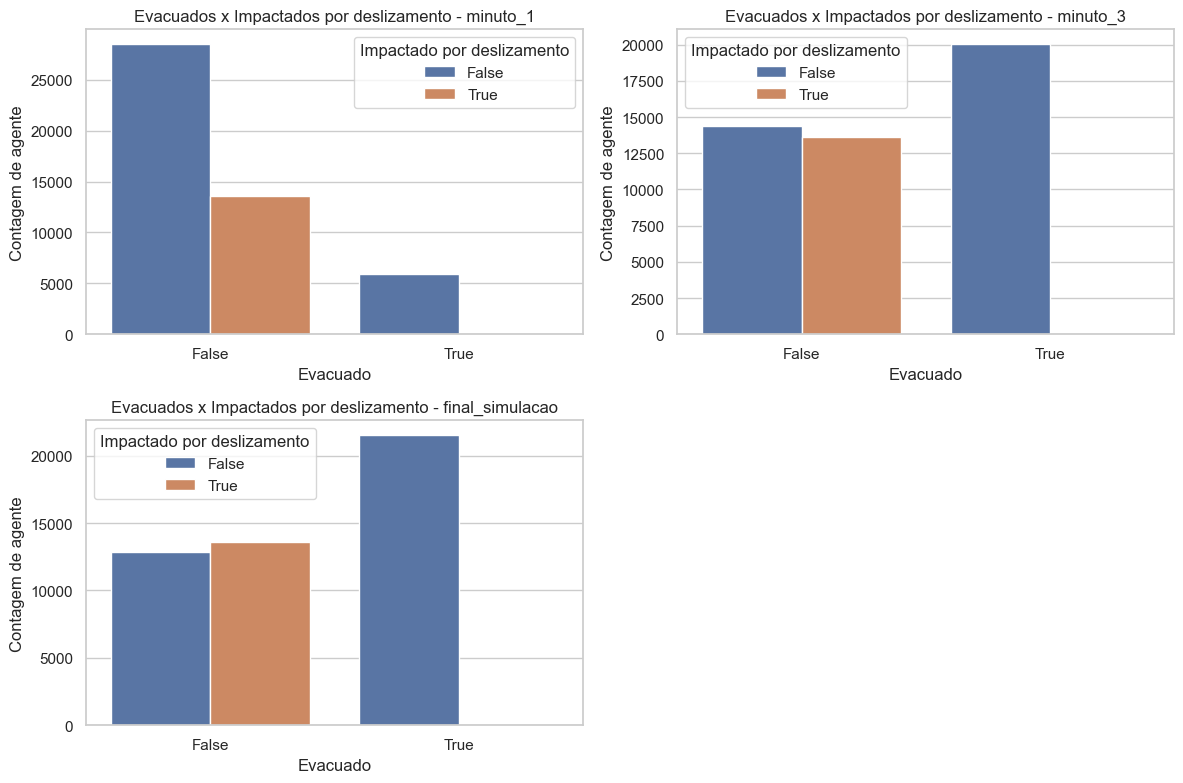

In [287]:
# evacuados x impactados ao longo da simulacao
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, folder in enumerate(report_folders):
    df = report_dfs[folder]
    ax = axes[i]

    if 'evacuated' in df.columns and 'impacted_by_landslide' in df.columns:
        sns.countplot(data=df, x='evacuated', hue='impacted_by_landslide', ax=ax)
        ax.set(title=f"Evacuados x Impactados por deslizamento - {folder}",
               xlabel="Evacuado", ylabel="Contagem de agente")
        ax.legend(title="Impactado por deslizamento")
    else:
        ax.text(0.5, 0.5, "No data", ha='center', va='center')
        ax.set_xticks([]); ax.set_yticks([])

for j in range(len(report_folders), len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
fig.savefig(download_dir / "grid_evacuated_by_landslide_hue.png")
plt.show()
plt.close(fig)

In [32]:
# descobrir tempo total da simulação
from pathlib import Path
import pandas as pd

# CONFIGURAÇÕES - AJUSTE PARA SEU CENÁRIO
base_path = Path("reports/all_risk_areas")  # <<<< MUDE AQUI

# Configurações da simulação (mantenha iguais)
step_length = 1.0
base_speed = 1.5
time_per_step = step_length / base_speed

print("=== DESCOBRINDO TEMPO TOTAL DA SIMULAÇÃO ===")
print(f"Analisando pasta: {base_path}")
print()

# Função para descobrir o tempo máximo em cada momento
def discover_max_time(folder_path):
    """Descobre o tempo máximo real da simulação analisando os dados"""
    try:
        # Pegar o arquivo mais recente
        all_csvs = list(folder_path.glob("*.csv"))
        if not all_csvs:
            return None, "Nenhum arquivo CSV encontrado"
        
        latest_file = min(all_csvs, key=lambda x: x.stat().st_mtime)
        df = pd.read_csv(latest_file)
        
        # Converter dados
        df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
        
        # Para descobrir o tempo total, precisamos analisar os agentes evacuados
        # pois eles têm o tempo completo até a evacuação
        evacuated_agents = df[df['evacuated'] == True]
        
        if len(evacuated_agents) > 0:
            max_time_ticks = evacuated_agents['time_spent'].max()
            max_time_seconds = max_time_ticks * time_per_step
            
            return max_time_seconds, f"Baseado em {len(evacuated_agents)} agentes evacuados"
        else:
            # Se ninguém foi evacuado, usar o máximo geral
            max_time_ticks = df['time_spent'].max()
            max_time_seconds = max_time_ticks * time_per_step
            
            return max_time_seconds, "Baseado no máximo geral (nenhum agente evacuado)"
            
    except Exception as e:
        return None, f"Erro: {e}"

# Descobrir os tempos para cada momento
discovered_times = {}
for folder in report_folders:
    folder_path = base_path / folder
    max_time, info = discover_max_time(folder_path)
    
    if max_time is not None:
        discovered_times[folder] = max_time
        print(f"{folder}:")
        print(f"  Tempo máximo descoberto: {max_time:.1f} segundos")
        print(f"  Info: {info}")
        print()
    else:
        print(f"{folder}: ERRO - {info}")
        print()

# Gerar o código que você deve usar no script principal
print("="*50)
print("CÓDIGO PARA USAR NO SEU SCRIPT PRINCIPAL:")
print("="*50)
print()
print("# Tempos descobertos automaticamente:")
print("simulation_elapsed_time = {")
for folder, time_val in discovered_times.items():
    print(f'    "{folder}": {time_val:.1f},')
print("}")
print()

# Validação - os tempos fazem sentido?
print("="*30)
print("VALIDAÇÃO:")
print("="*30)
expected_times = {
    "minuto_1": 60,
    "minuto_3": 180, 
    "minuto_5": 300
}

for folder, expected in expected_times.items():
    if folder in discovered_times:
        discovered = discovered_times[folder]
        if abs(discovered - expected) > 30:  # Margem de 30 segundos
            print(f"⚠️  {folder}: Esperado ~{expected}s, descoberto {discovered:.1f}s")
        else:
            print(f"{folder}: OK ({discovered:.1f}s ≈ {expected}s)")
    else:
        print(f"{folder}: Não foi possível descobrir o tempo")

if "final_simulacao" in discovered_times:
    final_time = discovered_times["final_simulacao"]
    print(f"final_simulacao: {final_time:.1f}s (tempo total da simulação)")

=== DESCOBRINDO TEMPO TOTAL DA SIMULAÇÃO ===
Analisando pasta: reports/all_risk_areas

minuto_1:
  Tempo máximo descoberto: 59.3 segundos
  Info: Baseado em 52 agentes evacuados

minuto_3:
  Tempo máximo descoberto: 178.7 segundos
  Info: Baseado em 196 agentes evacuados

final_simulacao:
  Tempo máximo descoberto: 209.3 segundos
  Info: Baseado em 208 agentes evacuados

CÓDIGO PARA USAR NO SEU SCRIPT PRINCIPAL:

# Tempos descobertos automaticamente:
simulation_elapsed_time = {
    "minuto_1": 59.3,
    "minuto_3": 178.7,
    "final_simulacao": 209.3,
}

VALIDAÇÃO:
✅ minuto_1: OK (59.3s ≈ 60s)
✅ minuto_3: OK (178.7s ≈ 180s)
❌ minuto_5: Não foi possível descobrir o tempo
✅ final_simulacao: 209.3s (tempo total da simulação)


minuto_1: minute_1_report_20250602-054013.csv
minuto_3: minute_3_report_20250602-054925.csv
final_simulacao: all_done_report_20250602-054925.csv

=== minuto_1 ===
Total de agentes: 480
Não evacuados: 428
time_spent (ticks) - min: 0.0, max: 90.0
time_s (segundos) - min: 0.0, max: 60.0
Tempo decorrido na simulação: 60 segundos
Eficiência média de movimento: 69.8%
⚠️  146 agentes com baixa eficiência de movimento (<30%)

=== minuto_3 ===
Total de agentes: 480
Não evacuados: 284
time_spent (ticks) - min: 0.0, max: 268.0
time_s (segundos) - min: 0.0, max: 178.7
Tempo decorrido na simulação: 180 segundos
Eficiência média de movimento: 46.9%
⚠️  179 agentes com baixa eficiência de movimento (<30%)

=== final_simulacao ===
Total de agentes: 480
Não evacuados: 272
time_spent (ticks) - min: 0.0, max: 314.0
time_s (segundos) - min: 0.0, max: 209.3
Tempo decorrido na simulação: 209.3 segundos
Eficiência média de movimento: 41.9%
⚠️  192 agentes com baixa eficiência de movimento (<30%)


/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/656977045.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


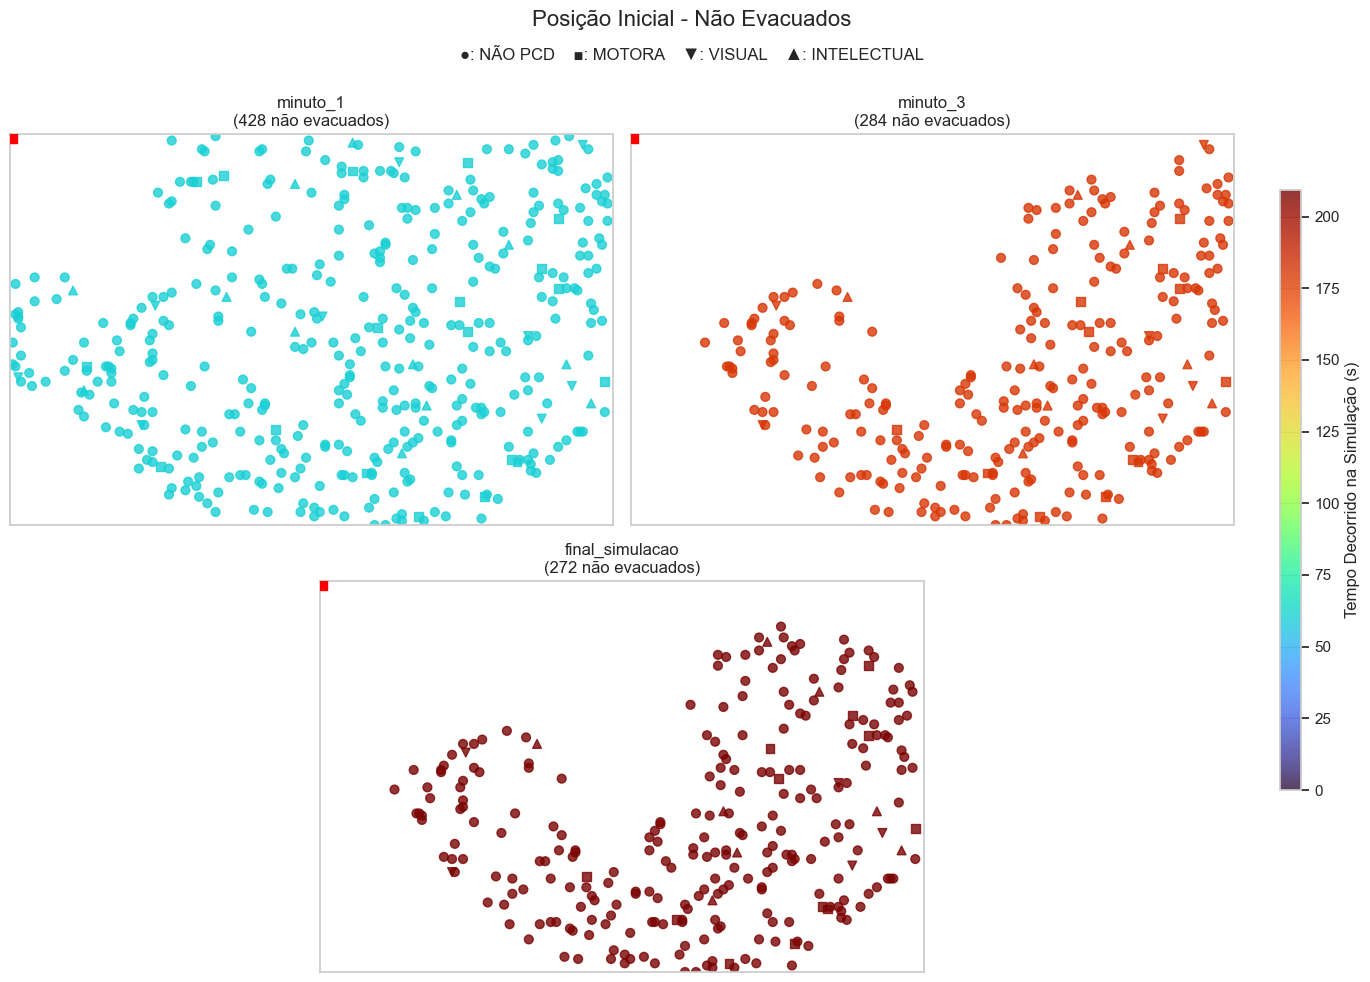


ANÁLISE DETALHADA

minuto_1:
  Agentes não evacuados: 428
  Time_spent (ticks): count    428.000000
mean      64.018692
std       38.425263
min        0.000000
25%       12.000000
50%       90.000000
75%       90.000000
max       90.000000
Name: time_spent, dtype: float64
  Time_s (segundos): count    428.000000
mean      42.679128
std       25.616842
min        0.000000
25%        8.000000
50%       60.000000
75%       60.000000
max       60.000000
Name: time_s, dtype: float64

minuto_3:
  Agentes não evacuados: 284
  Time_spent (ticks): count    284.000000
mean     118.489437
std      110.061675
min        0.000000
25%        7.000000
50%       90.000000
75%      225.250000
max      262.000000
Name: time_spent, dtype: float64
  Time_s (segundos): count    284.000000
mean      78.992958
std       73.374450
min        0.000000
25%        4.666667
50%       60.000000
75%      150.166667
max      174.666667
Name: time_s, dtype: float64

final_simulacao:
  Agentes não evacuados: 272
  Ti

In [33]:
# posicao inicial - nao evacuados
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

base_path = Path("reports/all_risk_areas")

# Tempo decorrido na simulação para cada momento (em segundos)
simulation_elapsed_time = {
    "minuto_1": 60,
    "minuto_3": 180,
    "final_simulacao": 209.3  # Baseado no max observado
}

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step  # ESTA é a conversão correta para segundos
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Total de agentes: {len(df)}")
    print(f"Não evacuados: {len(df[df['evacuated'] == False])}")
    print(f"time_spent (ticks) - min: {df['time_spent'].min():.1f}, max: {df['time_spent'].max():.1f}")
    print(f"time_s (segundos) - min: {df['time_s'].min():.1f}, max: {df['time_s'].max():.1f}")
    print(f"Tempo decorrido na simulação: {simulation_elapsed_time[folder]} segundos")
    
    # Calcular eficiência de movimento (% do tempo que passaram se movendo)
    if simulation_elapsed_time[folder] > 0:
        df['movement_efficiency'] = (df['time_s'] / simulation_elapsed_time[folder]) * 100
        avg_efficiency = df['movement_efficiency'].mean()
        print(f"Eficiência média de movimento: {avg_efficiency:.1f}%")
        
        # Agentes que passaram muito pouco tempo se movendo (podem estar stuck)
        low_efficiency = df[df['movement_efficiency'] < 30]  # Menos de 30% do tempo se movendo
        if len(low_efficiency) > 0:
            print(f"⚠️  {len(low_efficiency)} agentes com baixa eficiência de movimento (<30%)")

# --- Step 3: Plotar os dados corrigidos (3 plots) ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Criar figura com 3 subplots: 2 em cima, 1 embaixo centralizado
fig = plt.figure(figsize=(14, 10))
fig.suptitle("Posição Inicial - Não Evacuados", fontsize=16)
fig.text(0.5, 0.93, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

# Criar os 3 subplots manualmente com GridSpec para controlar proporções
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0:2])  # Primeiro plot (metade superior esquerda)
ax2 = fig.add_subplot(gs[0, 2:4])  # Segundo plot (metade superior direita)
ax3 = fig.add_subplot(gs[1, 1:3])  # Terceiro plot (centro inferior, mesma largura)
axes = [ax1, ax2, ax3]

# Determinar o range global para a cor (baseado no tempo decorrido da simulação)
vmin, vmax = 0, max(simulation_elapsed_time.values())

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    df_not_evacuated = df[df["evacuated"] == False].copy()
    ax = axes[i]
    
    # Tempo decorrido na simulação para este momento
    elapsed_time = simulation_elapsed_time[folder]

    if df_not_evacuated.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=12)
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder)
        continue

    # Extrair coordenadas x, y da posição inicial
    df_not_evacuated[['x', 'y']] = df_not_evacuated['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Plotar por tipo de mobilidade
    for mob, marker in mobility_markers.items():
        sub = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub.empty:
            # CORREÇÃO: usar o tempo decorrido da simulação em vez de time_s individual
            # Todos os agentes não evacuados têm o mesmo "tempo na simulação"
            time_color = [elapsed_time] * len(sub)
            sc = ax.scatter(sub['x'], sub['y'], c=time_color, cmap='turbo',
                           s=40, alpha=0.8, marker=marker, vmin=vmin, vmax=vmax, label=mob)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='s', label='Zona Segura', zorder=10)
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{folder}\n({len(df_not_evacuated)} não evacuados)")

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Tempo Decorrido na Simulação (s)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- Análise adicional para entender os dados ---
print("\n" + "="*50)
print("ANÁLISE DETALHADA")
print("="*50)

for folder in report_folders:
    df = dataframes[folder]
    df_not_evac = df[df["evacuated"] == False]
    
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df_not_evac)}")
    if len(df_not_evac) > 0:
        print(f"  Time_spent (ticks): {df_not_evac['time_spent'].describe()}")
        print(f"  Time_s (segundos): {df_not_evac['time_s'].describe()}")
        
        # Verificar se há agentes com time_spent inconsistente
        if folder == "minuto_1":
            max_expected_ticks = 60 / time_per_step  # ~90 ticks para 1 minuto
            weird_agents = df_not_evac[df_not_evac['time_spent'] > max_expected_ticks]
            if len(weird_agents) > 0:
                print(f"  ⚠️  Agentes com time_spent > {max_expected_ticks:.0f} ticks:")
                print(f"     {weird_agents[['agent_id', 'time_spent', 'time_s']].to_string()}")

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736007548.py:88: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736007548.py:88: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736007548.py:88: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'],
/var/folders/r1/vzkzbr

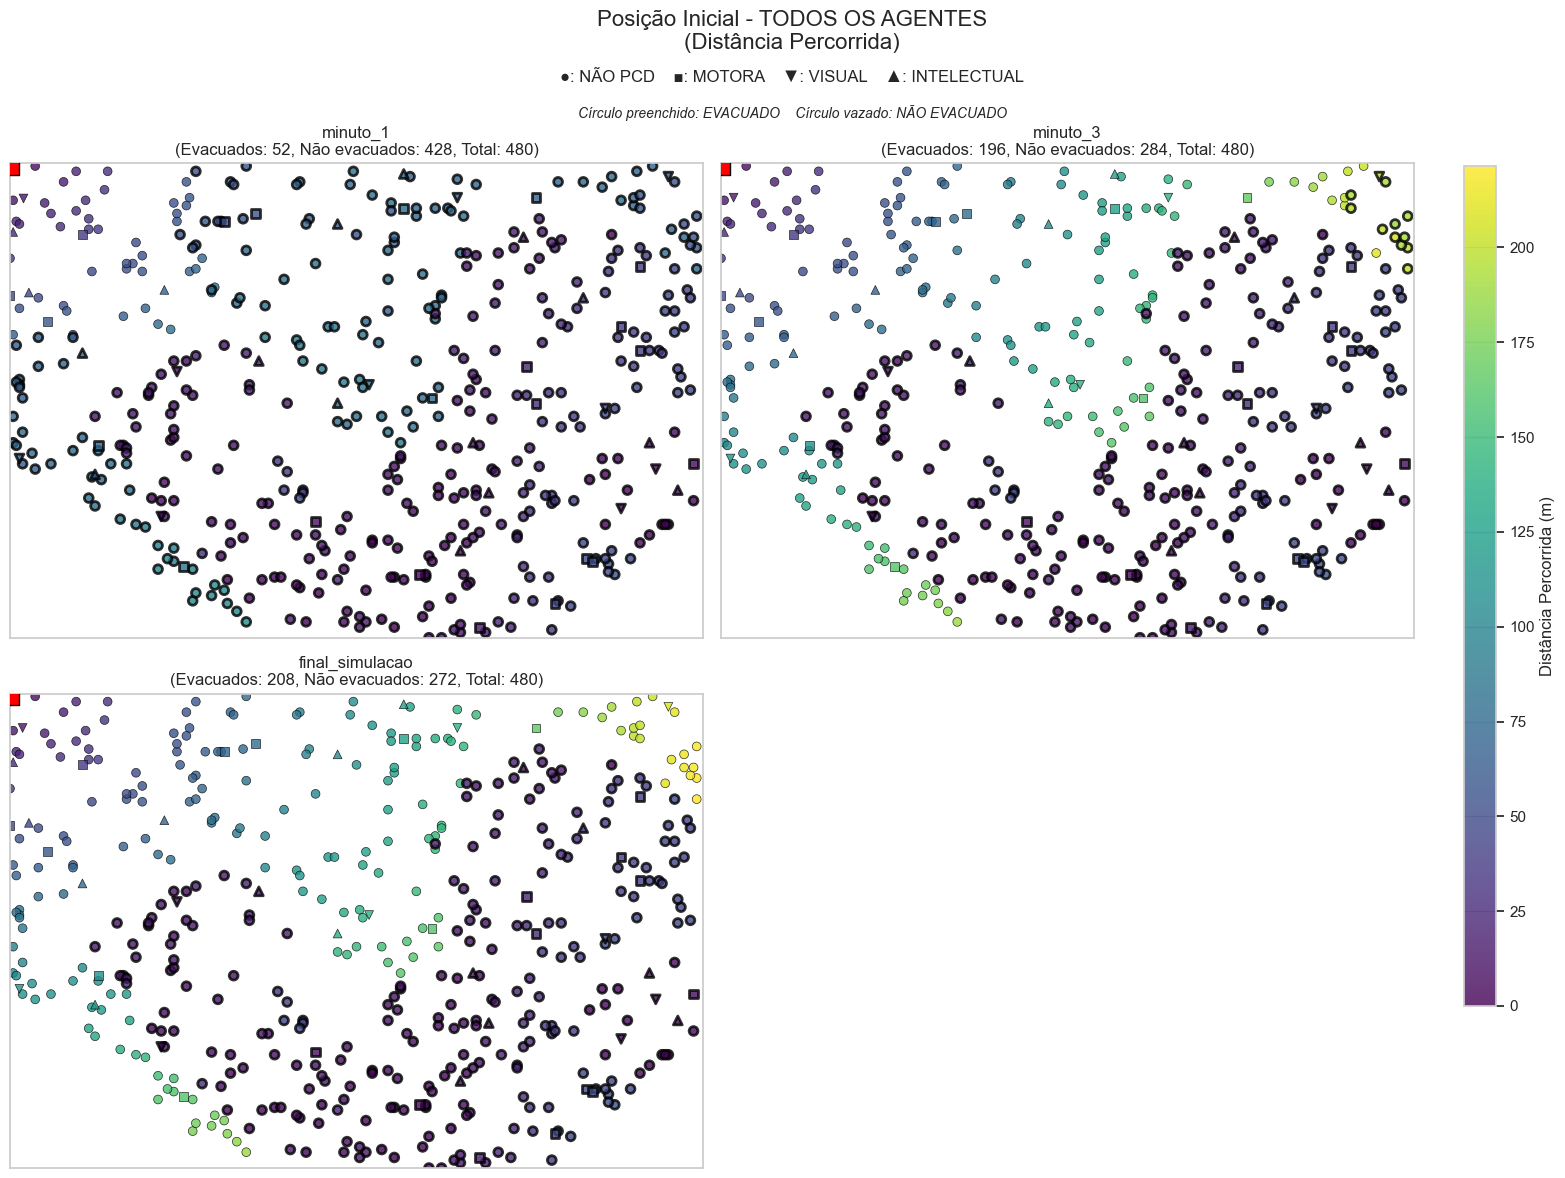

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736007548.py:168: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736007548.py:168: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/2736007548.py:168: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'],
/var/folde

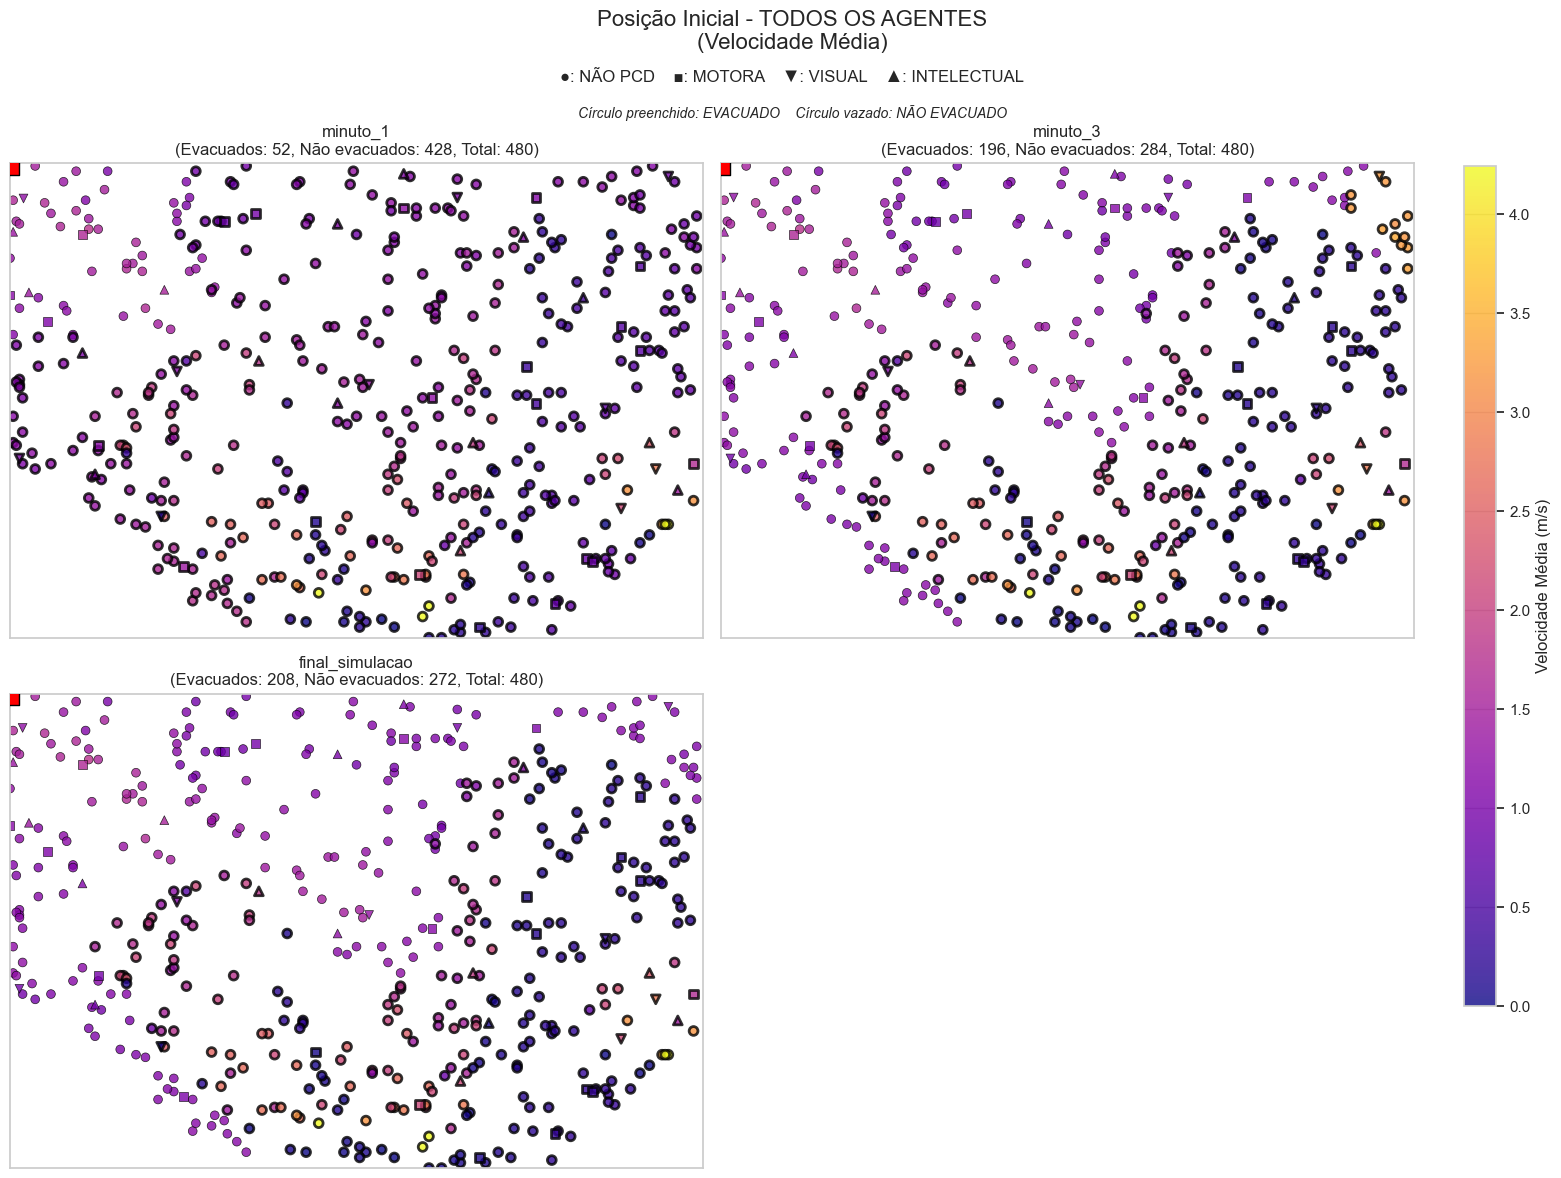


ESTATÍSTICAS COMPLETAS PARA O TCC

MINUTO_1:
  Total de agentes: 480
  Evacuados: 52 (10.8%)
  Não evacuados: 428 (89.2%)

  TODOS OS AGENTES:
    Distância percorrida:
      Média: 40.3m
      Min-Max: 0.0m - 107.8m
    Velocidade média:
      Média: 1.24 m/s
      Min-Max: 0.00 - 4.24 m/s

  AGENTES EVACUADOS:
    Distância média: 47.0m
    Velocidade média: 1.39 m/s
    Tempo médio: 35.1s

  AGENTES NÃO EVACUADOS:
    Distância média: 39.5m
    Velocidade média: 1.23 m/s
    Tempo: 60.0s

  POR TIPO DE MOBILIDADE:
    MOTOR       :  22 agentes total, evacuação:  13.6%
                 dist:  44.5m, vel: 0.98m/s
    NON_PWD     : 432 agentes total, evacuação:  10.4%
                 dist:  40.4m, vel: 1.25m/s
    VISUAL      :  10 agentes total, evacuação:  10.0%
                 dist:  35.1m, vel: 1.27m/s
    INTELLECTUAL:  16 agentes total, evacuação:  18.8%
                 dist:  36.1m, vel: 1.34m/s

MINUTO_3:
  Total de agentes: 480
  Evacuados: 196 (40.8%)
  Não evacuados: 284

In [34]:
# pos inicial - todos os agentes - distancia e velocidade
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

base_path = Path("reports/all_risk_areas")

# --- Carregar dados ---
latest_files = {}
for folder in report_folders:
    folder_path = base_path / folder
    all_csvs = list(folder_path.glob("*.csv"))
    latest_file = min(all_csvs, key=os.path.getmtime)
    latest_files[folder] = latest_file

dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    dataframes[folder] = df

# --- VISUALIZAÇÃO 1: TODOS OS AGENTES POR DISTÂNCIA PERCORRIDA ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Posição Inicial - TODOS OS AGENTES\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
         ha='center', fontsize=12)
fig.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
         ha='center', fontsize=10, style='italic')

# Encontrar range global de distâncias para todos os agentes
all_distances = []
for folder in report_folders:
    df = dataframes[folder]
    all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin, vmax = min(all_distances), max(all_distances)
else:
    vmin, vmax = 0, 100

sc_for_colorbar = None

# Posições dos plots: [0,0], [0,1], [1,0] e [1,1] será vazio
plot_positions = [(0, 0), (0, 1), (1, 0)]

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    row, col = plot_positions[i]
    ax = axes[row, col]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['distance_m'], 
                           cmap='viridis', s=40, alpha=0.8, marker=marker, 
                           vmin=vmin, vmax=vmax, facecolors='none', 
                           edgecolors='black', linewidth=2)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Remover o subplot vazio (posição [1,1])
axes[1, 1].remove()

# Colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- VISUALIZAÇÃO 2: TODOS OS AGENTES POR VELOCIDADE MÉDIA ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle("Posição Inicial - TODOS OS AGENTES\n(Velocidade Média)", fontsize=16)
fig2.text(0.5, 0.92, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL", 
          ha='center', fontsize=12)
fig2.text(0.5, 0.89, "Círculo preenchido: EVACUADO    Círculo vazado: NÃO EVACUADO", 
          ha='center', fontsize=10, style='italic')

# Range global de velocidades para todos os agentes
all_velocities = []
for folder in report_folders:
    df = dataframes[folder]
    all_velocities.extend(df['velocity_m_s'].tolist())

if all_velocities:
    vmin_vel, vmax_vel = min(all_velocities), max(all_velocities)
else:
    vmin_vel, vmax_vel = 0, 2

sc_for_colorbar2 = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder].copy()
    row, col = plot_positions[i]
    ax = axes2[row, col]

    # Extrair coordenadas
    df[['x', 'y']] = df['start_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    # Separar evacuados e não evacuados
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    # Plotar agentes evacuados (preenchidos)
    for mob, marker in mobility_markers.items():
        sub_evac = df_evacuated[df_evacuated["mobility_type"] == mob]
        if not sub_evac.empty:
            sc2 = ax.scatter(sub_evac['x'], sub_evac['y'], c=sub_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, edgecolors='black', linewidth=0.5)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2
    
    # Plotar agentes não evacuados (vazados)
    for mob, marker in mobility_markers.items():
        sub_not_evac = df_not_evacuated[df_not_evacuated["mobility_type"] == mob]
        if not sub_not_evac.empty:
            sc2 = ax.scatter(sub_not_evac['x'], sub_not_evac['y'], c=sub_not_evac['velocity_m_s'], 
                            cmap='plasma', s=40, alpha=0.8, marker=marker, 
                            vmin=vmin_vel, vmax=vmax_vel, facecolors='none', 
                            edgecolors='black', linewidth=2)
            if sc_for_colorbar2 is None:
                sc_for_colorbar2 = sc2

    # Zona segura
    ax.scatter(0, 179, color='red', s=150, marker='s', label='Zona Segura', 
               zorder=10, edgecolors='black', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xticks([])
    ax.set_yticks([])
    
    evacuated_count = len(df_evacuated)
    not_evacuated_count = len(df_not_evacuated)
    total_count = len(df)
    
    ax.set_title(f"{folder}\n(Evacuados: {evacuated_count}, Não evacuados: {not_evacuated_count}, Total: {total_count})")

# Remover o subplot vazio (posição [1,1])
axes2[1, 1].remove()

# Colorbar
if sc_for_colorbar2:
    cbar_ax2 = fig2.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar2 = fig2.colorbar(sc_for_colorbar2, cax=cbar_ax2, label="Velocidade Média (m/s)")

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

# --- ESTATÍSTICAS COMPARATIVAS COMPLETAS ---
print("\n" + "="*80)
print("ESTATÍSTICAS COMPLETAS PARA O TCC")
print("="*80)

for folder in report_folders:
    df = dataframes[folder]
    df_evacuated = df[df['evacuated'] == True]
    df_not_evacuated = df[df['evacuated'] == False]
    
    print(f"\n{folder.upper()}:")
    print(f"  Total de agentes: {len(df)}")
    print(f"  Evacuados: {len(df_evacuated)} ({len(df_evacuated)/len(df)*100:.1f}%)")
    print(f"  Não evacuados: {len(df_not_evacuated)} ({len(df_not_evacuated)/len(df)*100:.1f}%)")
    
    if len(df) > 0:
        print(f"\n  TODOS OS AGENTES:")
        print(f"    Distância percorrida:")
        print(f"      Média: {df['distance_m'].mean():.1f}m")
        print(f"      Min-Max: {df['distance_m'].min():.1f}m - {df['distance_m'].max():.1f}m")
        print(f"    Velocidade média:")
        print(f"      Média: {df['velocity_m_s'].mean():.2f} m/s")
        print(f"      Min-Max: {df['velocity_m_s'].min():.2f} - {df['velocity_m_s'].max():.2f} m/s")
        
        # Análise por status de evacuação
        if len(df_evacuated) > 0:
            print(f"\n  AGENTES EVACUADOS:")
            print(f"    Distância média: {df_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo médio: {df_evacuated['time_s'].mean():.1f}s")
        
        if len(df_not_evacuated) > 0:
            print(f"\n  AGENTES NÃO EVACUADOS:")
            print(f"    Distância média: {df_not_evacuated['distance_m'].mean():.1f}m")
            print(f"    Velocidade média: {df_not_evacuated['velocity_m_s'].mean():.2f} m/s")
            print(f"    Tempo: {df_not_evacuated['time_s'].iloc[0]:.1f}s")
        
        # Análise por tipo de mobilidade
        print(f"\n  POR TIPO DE MOBILIDADE:")
        for mob_type in df['mobility_type'].unique():
            subset = df[df['mobility_type'] == mob_type]
            evacuated_subset = subset[subset['evacuated'] == True]
            not_evacuated_subset = subset[subset['evacuated'] == False]
            
            evacuation_rate = len(evacuated_subset) / len(subset) * 100 if len(subset) > 0 else 0
            avg_dist = subset['distance_m'].mean()
            avg_vel = subset['velocity_m_s'].mean()
            
            print(f"    {mob_type:12}: {len(subset):3} agentes total, "
                  f"evacuação: {evacuation_rate:5.1f}%")
            print(f"                 dist: {avg_dist:5.1f}m, vel: {avg_vel:.2f}m/s")

print("\n" + "="*80)
print("RESUMO COMPARATIVO ENTRE TEMPOS:")
print("="*80)

# Comparação de taxa de evacuação entre os tempos
evacuation_rates = {}
for folder in report_folders:
    df = dataframes[folder]
    rate = len(df[df['evacuated'] == True]) / len(df) * 100 if len(df) > 0 else 0
    evacuation_rates[folder] = rate

print("\nTaxas de Evacuação:")
for folder, rate in evacuation_rates.items():
    print(f"  {folder:15}: {rate:5.1f}%")

# Comparação de desempenho médio
print("\nDesempenho Médio (Todos os Agentes):")
for folder in report_folders:
    df = dataframes[folder]
    if len(df) > 0:
        avg_dist = df['distance_m'].mean()
        avg_vel = df['velocity_m_s'].mean()
        print(f"  {folder:15}: dist={avg_dist:5.1f}m, vel={avg_vel:.2f}m/s")

minuto_1: minute_1_report_20250602-054013.csv
minuto_3: minute_3_report_20250602-054925.csv
final_simulacao: all_done_report_20250602-054925.csv

=== minuto_1 ===
Agentes não evacuados: 428
Distância percorrida - min: 0.0m, max: 107.8m
Velocidade média - min: 0.00m/s, max: 4.24m/s

=== minuto_3 ===
Agentes não evacuados: 284
Distância percorrida - min: 0.0m, max: 205.8m
Velocidade média - min: 0.00m/s, max: 4.24m/s

=== final_simulacao ===
Agentes não evacuados: 272
Distância percorrida - min: 0.0m, max: 55.9m
Velocidade média - min: 0.00m/s, max: 4.24m/s


/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/1740988457.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


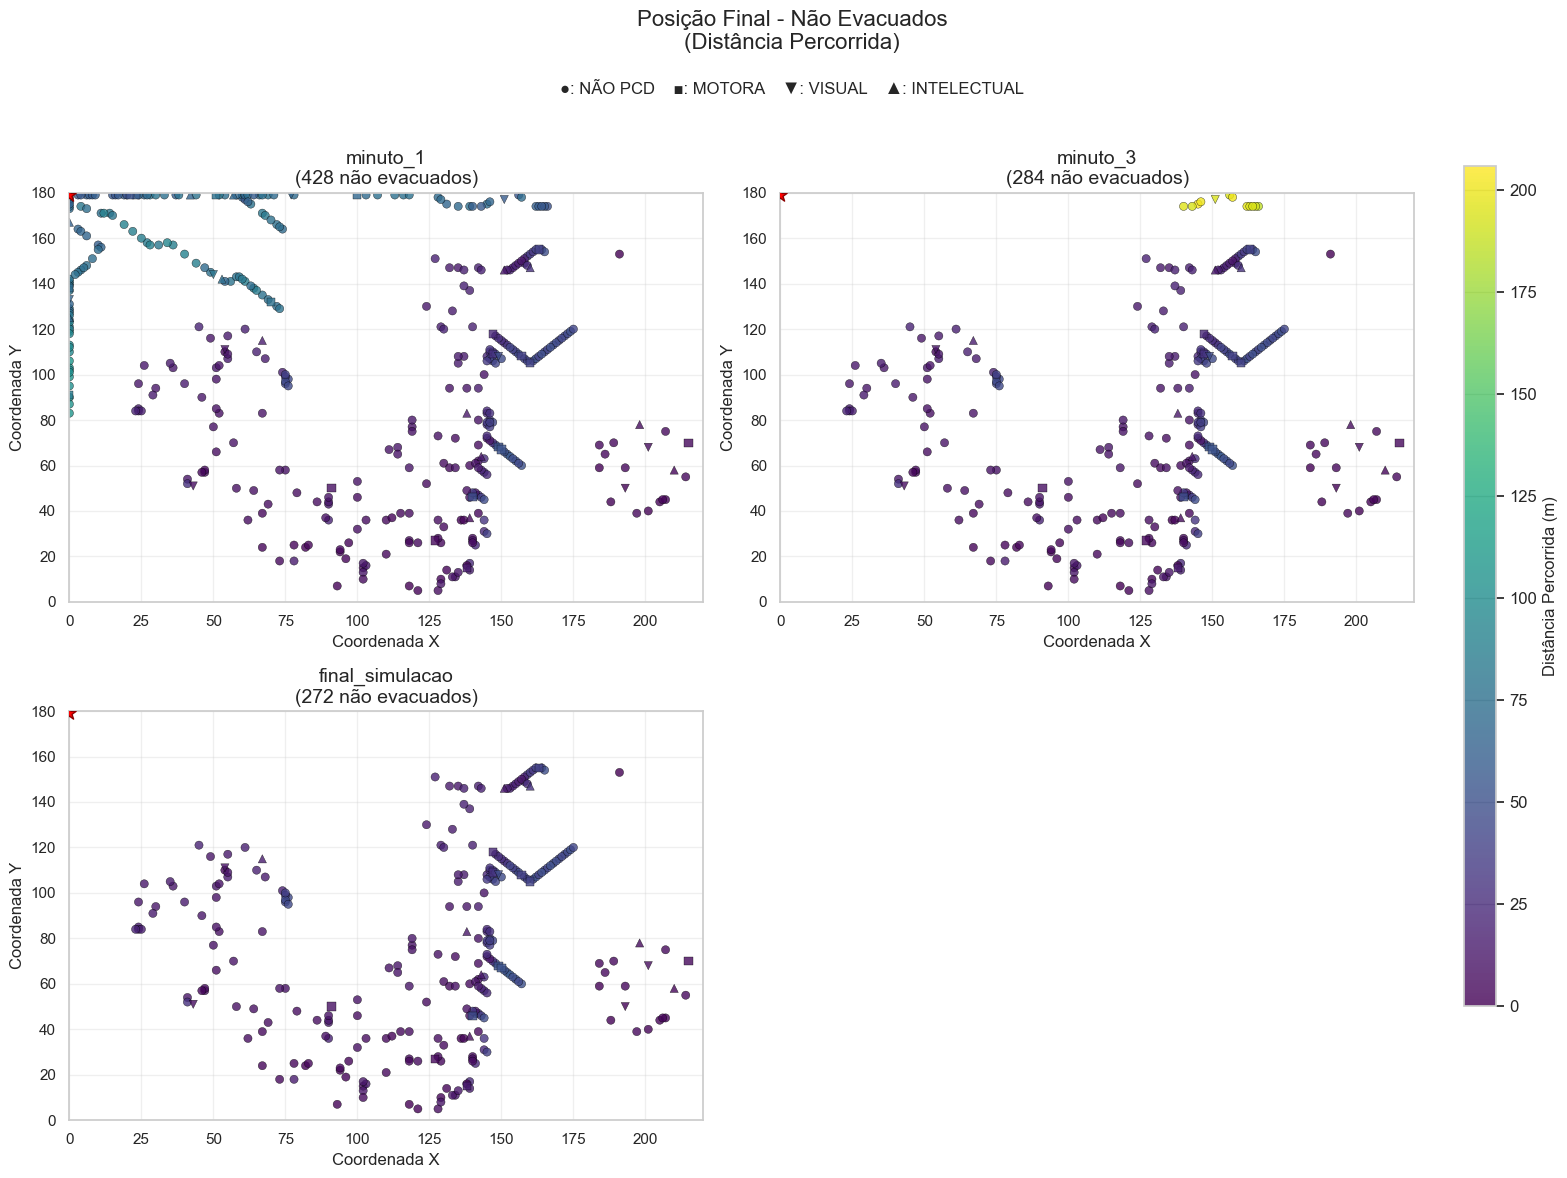


ANÁLISE ESTATÍSTICA DETALHADA

minuto_1:
  Agentes não evacuados: 428
  Distância percorrida (m):
    Min: 0.0m
    Max: 107.8m
    Média: 39.5m
    Mediana: 35.4m
    Q1 (25%): 11.3m
    Q3 (75%): 68.7m
  Agentes com baixa mobilidade (≤11.3m): 115 (26.9%)
  Agentes com alta mobilidade (≥68.7m): 107 (25.0%)
  Por tipo de mobilidade:
    INTELLECTUAL: 13 agentes
      Distância média: 33.6m (mediana: 15.6m)
      Velocidade média: 1.32m/s
    MOTOR: 19 agentes
      Distância média: 44.0m (mediana: 46.7m)
      Velocidade média: 0.93m/s
    NON_PWD: 387 agentes
      Distância média: 39.5m (mediana: 33.5m)
      Velocidade média: 1.24m/s
    VISUAL: 9 agentes
      Distância média: 37.6m (mediana: 45.2m)
      Velocidade média: 1.27m/s
  Regiões com agentes de baixa mobilidade:
    Região (120-140, 20-40): 9 agentes
    Região (100-120, 20-40): 9 agentes
    Região (120-140, 0-20): 8 agentes

minuto_3:
  Agentes não evacuados: 284
  Distância percorrida (m):
    Min: 0.0m
    Max: 205.

/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/1740988457.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/1740988457.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
/var/folders/r1/vzkzbrkx1h107mdm0z331hh80000gn/T/ipykernel_89588/1740988457.py:188: SettingWithCopyWarning: 
A 

In [35]:
# pos final - nao evacuados
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

base_path = Path("reports/all_risk_areas")

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Filtrar apenas não evacuados
    df = df[df["evacuated"] != True].copy()
    
    if df.empty:
        dataframes[folder] = df
        print(f"\n=== {folder} ===")
        print("Todos os agentes foram evacuados!")
        continue
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    # Extrair coordenadas x, y da posição final
    df[['x', 'y']] = df['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Agentes não evacuados: {len(df)}")
    print(f"Distância percorrida - min: {df['distance_m'].min():.1f}m, max: {df['distance_m'].max():.1f}m")
    print(f"Velocidade média - min: {df['velocity_m_s'].min():.2f}m/s, max: {df['velocity_m_s'].max():.2f}m/s")

# --- Step 3: Plotar com DISTÂNCIA como variável de cor ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Determinar o range global para distância
all_distances = []
for df in dataframes.values():
    if not df.empty:
        all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin_dist, vmax_dist = 0, max(all_distances)
else:
    vmin_dist, vmax_dist = 0, 100

# Criar gráfico
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Posição Final - Não Evacuados\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.91, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

sc_for_colorbar = None

# Posições dos plots: [0,0], [0,1], [1,0] e [1,1] será vazio
plot_positions = [(0, 0), (0, 1), (1, 0)]

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    row, col = plot_positions[i]
    ax = axes[row, col]

    if df.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, weight='bold')
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder, fontsize=14)
        continue
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = df[df["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=35, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, edgecolors='black', linewidth=0.3)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=12)
    ax.set_ylabel('Coordenada Y', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{folder}\n({len(df)} não evacuados)", fontsize=14)

# Remover o subplot vazio (posição [1,1])
axes[1, 1].remove()

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()

# --- Análise estatística aprimorada ---
print("\n" + "="*70)
print("ANÁLISE ESTATÍSTICA DETALHADA")
print("="*70)

for folder in report_folders:
    df = dataframes[folder]
    
    if df.empty:
        print(f"\n{folder}: Todos evacuados!")
        continue
        
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df)}")
    print(f"  Distância percorrida (m):")
    print(f"    Min: {df['distance_m'].min():.1f}m")
    print(f"    Max: {df['distance_m'].max():.1f}m")
    print(f"    Média: {df['distance_m'].mean():.1f}m")
    print(f"    Mediana: {df['distance_m'].median():.1f}m")
    
    # Análise por quartis de distância
    q1 = df['distance_m'].quantile(0.25)
    q3 = df['distance_m'].quantile(0.75)
    print(f"    Q1 (25%): {q1:.1f}m")
    print(f"    Q3 (75%): {q3:.1f}m")
    
    # Identificar agentes com baixa mobilidade
    low_mobility = df[df['distance_m'] <= q1]
    high_mobility = df[df['distance_m'] >= q3]
    
    print(f"  Agentes com baixa mobilidade (≤{q1:.1f}m): {len(low_mobility)} ({len(low_mobility)/len(df)*100:.1f}%)")
    print(f"  Agentes com alta mobilidade (≥{q3:.1f}m): {len(high_mobility)} ({len(high_mobility)/len(df)*100:.1f}%)")
    
    # Análise por tipo de mobilidade
    print(f"  Por tipo de mobilidade:")
    mobility_stats = df.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median', 'std'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        median_dist = mobility_stats.loc[mob_type, ('distance_m', 'median')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        print(f"    {mob_type}: {count} agentes")
        print(f"      Distância média: {mean_dist:.1f}m (mediana: {median_dist:.1f}m)")
        print(f"      Velocidade média: {mean_vel:.2f}m/s")
    
    # Análise espacial - onde estão os agentes com menor mobilidade
    if len(low_mobility) > 0:
        print(f"  Regiões com agentes de baixa mobilidade:")
        # Agrupar por regiões aproximadas
        low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
        low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
        
        regions = low_mobility.groupby(['region_x', 'region_y']).size().sort_values(ascending=False)
        for (x, y), count in regions.head(3).items():
            print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {count} agentes")

print("\n" + "="*70)
print("INTERPRETAÇÃO PARA SEU TCC:")
print("="*70)
print("1. A coloração por DISTÂNCIA revela padrões espaciais importantes")
print("2. Agentes com cores mais escuras (menor distância) podem indicar:")
print("   - Obstáculos locais que impedem movimento")
print("   - Gargalos de evacuação")
print("   - Problemas de pathfinding")
print("3. A uniformidade temporal confirma que o fator crítico é ESPACIAL, não temporal")
print("4. Diferentes tipos de mobilidade mostram padrões distintos de movimento")

In [ ]:
# pos final - nao evacuados - dois plots
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configurações da simulação
step_length = 1.0                # metros por movimento/step
base_speed = 1.5                 # m/s
time_per_step = step_length / base_speed    # segundos por step de simulação

report_folders = ["minuto_1","final_simulacao"]
base_path = Path("reports/all_risk_areas")

# --- Step 1: Carregar arquivos mais recentes ---
latest_files = {}
try:
    for folder in report_folders:
        folder_path = base_path / folder
        all_csvs = list(folder_path.glob("*.csv"))
        latest_file = min(all_csvs, key=os.path.getmtime)
        latest_files[folder] = latest_file
        print(f"{folder}: {latest_file.name}")
except Exception as e:
    print(f"Erro ao encontrar arquivos: {e}")
    exit()

# --- Step 2: Carregar e processar dados ---
dataframes = {}
for folder in report_folders:
    file = latest_files[folder]
    df = pd.read_csv(file)
    
    # Filtrar apenas não evacuados
    df = df[df["evacuated"] != True].copy()
    
    if df.empty:
        dataframes[folder] = df
        print(f"\n=== {folder} ===")
        print("Todos os agentes foram evacuados!")
        continue
    
    # Conversões necessárias
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
    df['steps'] = pd.to_numeric(df['steps'], errors='coerce')
    
    # Cálculos derivados
    df['distance_m'] = df['distance'] * step_length
    df['time_s'] = df['time_spent'] * time_per_step
    df['velocity_m_s'] = np.where(df['time_s'] > 0, df['distance_m'] / df['time_s'], 0)
    
    # Extrair coordenadas x, y da posição final
    df[['x', 'y']] = df['final_pos'].str.strip("()").str.split(",", expand=True).astype(float)
    
    dataframes[folder] = df
    
    # Diagnóstico dos dados
    print(f"\n=== {folder} ===")
    print(f"Agentes não evacuados: {len(df)}")
    print(f"Distância percorrida - min: {df['distance_m'].min():.1f}m, max: {df['distance_m'].max():.1f}m")
    print(f"Velocidade média - min: {df['velocity_m_s'].min():.2f}m/s, max: {df['velocity_m_s'].max():.2f}m/s")

# --- Step 3: Plotar com DISTÂNCIA como variável de cor ---
mobility_markers = {
    "NON_PWD": "o", "MOTOR": "s", "VISUAL": "v", "INTELLECTUAL": "^"
}

# Determinar o range global para distância
all_distances = []
for df in dataframes.values():
    if not df.empty:
        all_distances.extend(df['distance_m'].tolist())

if all_distances:
    vmin_dist, vmax_dist = 0, max(all_distances)
else:
    vmin_dist, vmax_dist = 0, 100

# Criar gráfico
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Posição Final - Não Evacuados\n(Distância Percorrida)", fontsize=16)
fig.text(0.5, 0.85, "●: NÃO PCD    ■: MOTORA    ▼: VISUAL    ▲: INTELECTUAL",
         ha='center', fontsize=12)

sc_for_colorbar = None

for i, folder in enumerate(report_folders):
    df = dataframes[folder]
    ax = axes[i]

    if df.empty:
        ax.text(0.5, 0.5, "Todos evacuados", ha='center', va='center', 
                transform=ax.transAxes, fontsize=14, weight='bold')
        ax.set_xlim(0, 220)
        ax.set_ylim(0, 180)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(folder, fontsize=14)
        continue
    
    # Plotar por tipo de mobilidade usando DISTÂNCIA como cor
    for mob, marker in mobility_markers.items():
        sub = df[df["mobility_type"] == mob]
        if not sub.empty:
            sc = ax.scatter(sub['x'], sub['y'], c=sub['distance_m'], 
                           cmap='viridis', s=35, alpha=0.8, marker=marker,
                           vmin=vmin_dist, vmax=vmax_dist, edgecolors='black', linewidth=0.3)
            if sc_for_colorbar is None:
                sc_for_colorbar = sc

    # Marcar zona segura
    ax.scatter(0, 179, color='red', s=100, marker='*', 
               label='Zona Segura', zorder=10, edgecolors='darkred', linewidth=1)
    
    ax.set_xlim(0, 220)
    ax.set_ylim(0, 180)
    ax.set_xlabel('Coordenada X', fontsize=12)
    ax.set_ylabel('Coordenada Y', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{folder}\n({len(df)} não evacuados)", fontsize=14)

# Adicionar colorbar
if sc_for_colorbar:
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(sc_for_colorbar, cax=cbar_ax, label="Distância Percorrida (m)")
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 0.93])
plt.show()

# --- Análise estatística aprimorada ---
print("\n" + "="*70)
print("ANÁLISE ESTATÍSTICA DETALHADA")
print("="*70)

for folder in report_folders:
    df = dataframes[folder]
    
    if df.empty:
        print(f"\n{folder}: Todos evacuados!")
        continue
        
    print(f"\n{folder}:")
    print(f"  Agentes não evacuados: {len(df)}")
    print(f"  Distância percorrida (m):")
    print(f"    Min: {df['distance_m'].min():.1f}m")
    print(f"    Max: {df['distance_m'].max():.1f}m")
    print(f"    Média: {df['distance_m'].mean():.1f}m")
    print(f"    Mediana: {df['distance_m'].median():.1f}m")
    
    # Análise por quartis de distância
    q1 = df['distance_m'].quantile(0.25)
    q3 = df['distance_m'].quantile(0.75)
    print(f"    Q1 (25%): {q1:.1f}m")
    print(f"    Q3 (75%): {q3:.1f}m")
    
    # Identificar agentes com baixa mobilidade
    low_mobility = df[df['distance_m'] <= q1]
    high_mobility = df[df['distance_m'] >= q3]
    
    print(f"  Agentes com baixa mobilidade (≤{q1:.1f}m): {len(low_mobility)} ({len(low_mobility)/len(df)*100:.1f}%)")
    print(f"  Agentes com alta mobilidade (≥{q3:.1f}m): {len(high_mobility)} ({len(high_mobility)/len(df)*100:.1f}%)")
    
    # Análise por tipo de mobilidade
    print(f"  Por tipo de mobilidade:")
    mobility_stats = df.groupby('mobility_type').agg({
        'distance_m': ['count', 'mean', 'median', 'std'],
        'velocity_m_s': 'mean'
    }).round(2)
    
    for mob_type in mobility_stats.index:
        count = mobility_stats.loc[mob_type, ('distance_m', 'count')]
        mean_dist = mobility_stats.loc[mob_type, ('distance_m', 'mean')]
        median_dist = mobility_stats.loc[mob_type, ('distance_m', 'median')]
        mean_vel = mobility_stats.loc[mob_type, ('velocity_m_s', 'mean')]
        print(f"    {mob_type}: {count} agentes")
        print(f"      Distância média: {mean_dist:.1f}m (mediana: {median_dist:.1f}m)")
        print(f"      Velocidade média: {mean_vel:.2f}m/s")
    
    # Análise espacial - onde estão os agentes com menor mobilidade
    if len(low_mobility) > 0:
        print(f"  Regiões com agentes de baixa mobilidade:")
        # Agrupar por regiões aproximadas
        low_mobility['region_x'] = (low_mobility['x'] // 20) * 20  # Grupos de 20 unidades
        low_mobility['region_y'] = (low_mobility['y'] // 20) * 20
        
        regions = low_mobility.groupby(['region_x', 'region_y']).size().sort_values(ascending=False)
        for (x, y), count in regions.head(3).items():
            print(f"    Região ({x:.0f}-{x+20:.0f}, {y:.0f}-{y+20:.0f}): {count} agentes")

print("\n" + "="*70)
print("INTERPRETAÇÃO PARA SEU TCC:")
print("="*70)
print("1. A coloração por DISTÂNCIA revela padrões espaciais importantes")
print("2. Agentes com cores mais escuras (menor distância) podem indicar:")
print("   - Obstáculos locais que impedem movimento")
print("   - Gargalos de evacuação")
print("   - Problemas de pathfinding")
print("3. A uniformidade temporal confirma que o fator crítico é ESPACIAL, não temporal")
print("4. Diferentes tipos de mobilidade mostram padrões distintos de movimento")

In [293]:
summary_time_related = df_all_risk_areas_all_done.groupby('mobility_type').agg({
    'time_s':       'mean',
    'distance_m':   'mean',
    'steps':        'mean',
    'velocity_m_s': 'mean',
    'agent_id':     'count'
}).rename(columns={'agent_id':'count_agents'})

In [294]:
summary_time_related

time_s  distance_m      steps  velocity_m_s  count_agents
mobility_type                                                               
INTELLECTUAL   165.267155   58.933835  54.522516      0.558131          1399
MOTOR          169.855480   58.776294  54.183934      0.538824          1332
NON_PWD        161.041923   59.928385  55.306011      0.613627         43884
VISUAL         169.749097   58.567032  54.147292      0.539739          1385

In [295]:
total_agents = len(df_all_risk_areas_all_done)
evacuated_count = df_all_risk_areas_all_done['evacuated'].sum()
not_evacuated_count = total_agents - evacuated_count
impacted_count = df_all_risk_areas_all_done['impacted_by_landslide'].sum()
not_impacted_count = total_agents - impacted_count

In [296]:
summary_evacuation = pd.DataFrame({
    'metric': [
        'total_agents',
        'evacuated',
        'not_evacuated',
        'impacted_by_landslide',
        'not_impacted_by_landslide'
    ],
    'count': [
        total_agents,
        evacuated_count,
        not_evacuated_count,
        impacted_count,
        not_impacted_count
    ]
})

In [297]:
summary_evacuation

metric  count
0               total_agents  48000
1                  evacuated  21538
2              not_evacuated  26462
3      impacted_by_landslide  13600
4  not_impacted_by_landslide  34400

# Visual of the elevation

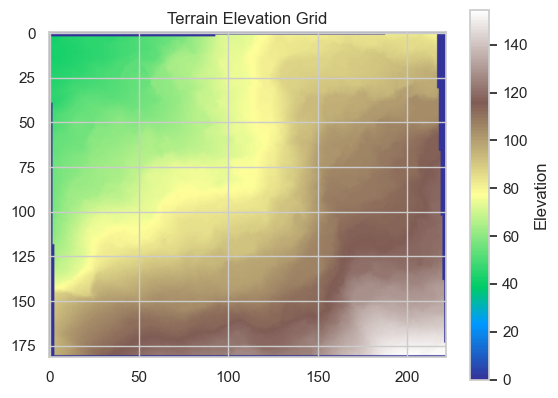

In [58]:
import numpy as np
import matplotlib.pyplot as plt

elev = np.load("data/processed/elevation.npy")
plt.imshow(elev, cmap="terrain")
plt.colorbar(label="Elevation")
plt.title("Terrain Elevation Grid")
plt.show()

# result analysis

Sem Deslizamento: 47944 agentes evacuados
1 Área de Risco: 29151 agentes evacuados
Todas as Áreas de Risco: 21538 agentes evacuados


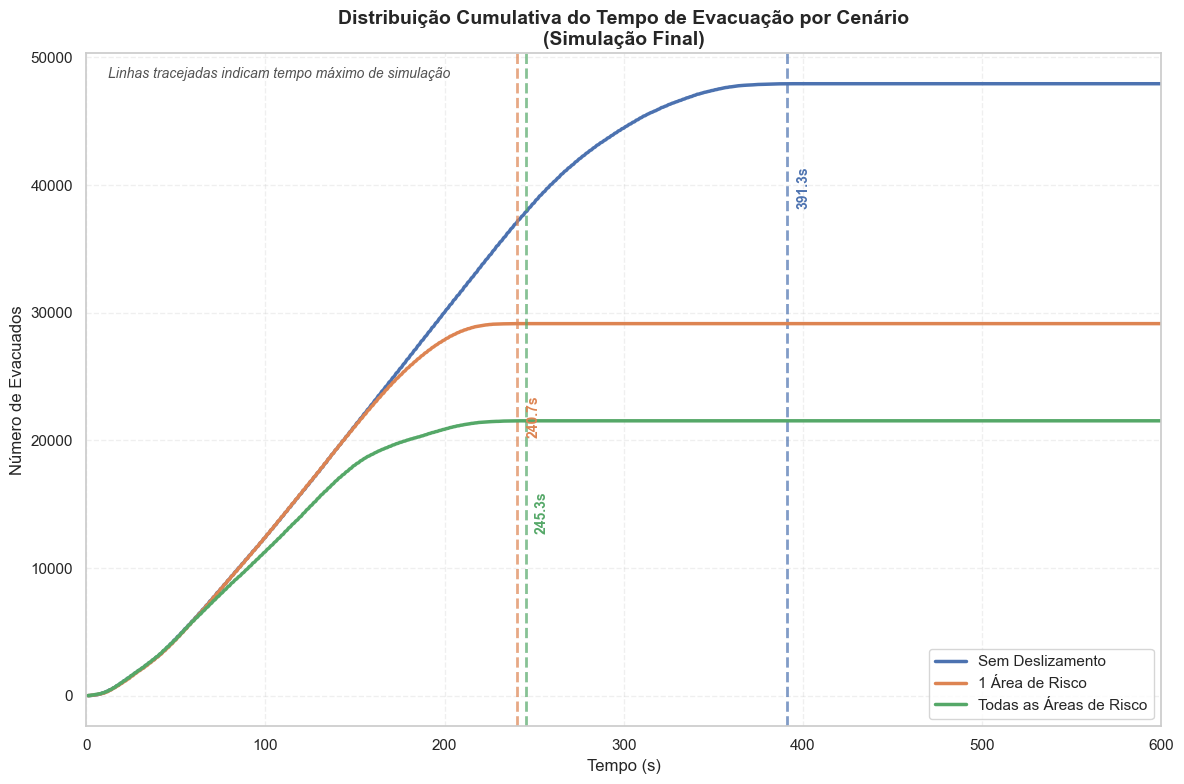


=== ESTATÍSTICAS RESUMIDAS ===
Sem Deslizamento:
  Tempo máximo: 391.3s
  Equivalente a: 6.5 minutos
1 Área de Risco:
  Tempo máximo: 240.7s
  Equivalente a: 4.0 minutos
Todas as Áreas de Risco:
  Tempo máximo: 245.3s
  Equivalente a: 4.1 minutos


In [83]:
# distribuição cumulativa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Define your simulation folders
scenarios = {
    "Sem Deslizamento": Path("reports/no_landslide"),
    "1 Área de Risco": Path("reports/one_risk_area"),
    "Todas as Áreas de Risco": Path("reports/all_risk_areas")
}

# Tempos máximos descobertos para cada cenário
max_times = {
    "Sem Deslizamento": 391.3,
    "1 Área de Risco": 240.7,
    "Todas as Áreas de Risco": 245.3
}

plt.figure(figsize=(12, 8))

# Lista para armazenar as cores de cada cenário
colors = {}
scenario_index = 0

for label, folder in scenarios.items():
    # Pegar apenas os arquivos da pasta final_simulacao
    final_folder = folder / "final_simulacao"
    all_files = list(final_folder.glob("*.csv"))
    
    if not all_files:
        print(f"Aviso: Nenhum arquivo encontrado em {final_folder}")
        continue
    
    dfs = [pd.read_csv(f) for f in all_files]
    df = pd.concat(dfs, ignore_index=True)
    
    df['evacuated'] = df['evacuated'].astype(bool)
    df['time_spent'] = pd.to_numeric(df['time_spent'], errors='coerce')
    
    # Convert ticks to seconds
    base_speed = 1.5  # m/s
    step_length = 1.0
    time_per_step = step_length / base_speed
    df['time_s'] = df['time_spent'] * time_per_step
    
    # Filter only evacuated agents
    evac = df[df['evacuated']]
    
    print(f"{label}: {len(evac)} agentes evacuados")
    
    # Bin evacuation times into 1-second intervals
    bins = np.arange(0, 601, 1)  # from 0 to 600 seconds
    counts, edges = np.histogram(evac['time_s'], bins=bins)
    cumulative = np.cumsum(counts)
    
    # Plot da curva cumulativa
    line = plt.plot(edges[1:], cumulative, label=label, linewidth=2.5)
    colors[label] = line[0].get_color()
    
    # Adicionar linha vertical no tempo máximo
    plt.axvline(x=max_times[label], color=colors[label], linestyle='--', alpha=0.7, linewidth=2)
    
    # Adicionar texto com o tempo máximo
    plt.text(max_times[label] + 5, max(cumulative) * 0.8 - scenario_index * max(cumulative) * 0.1, 
             f'{max_times[label]:.1f}s', 
             rotation=90, color=colors[label], fontweight='bold', fontsize=10)
    
    scenario_index += 1

plt.xlabel("Tempo (s)", fontsize=12)
plt.ylabel("Número de Evacuados", fontsize=12)
plt.title("Distribuição Cumulativa do Tempo de Evacuação por Cenário\n(Simulação Final)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(fontsize=11)

# Melhorar os limites do eixo X
plt.xlim(0, 600)

# Adicionar anotação explicativa
plt.text(0.02, 0.98, 'Linhas tracejadas indicam tempo máximo de simulação', 
         transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', style='italic', alpha=0.8)

plt.tight_layout()
plt.show()

# Estatísticas resumidas
print("\n=== ESTATÍSTICAS RESUMIDAS ===")
for label in scenarios.keys():
    print(f"{label}:")
    print(f"  Tempo máximo: {max_times[label]:.1f}s")
    print(f"  Equivalente a: {max_times[label]/60:.1f} minutos")